## Calculating Global Coherence

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate the significance and sensitivity of [global coherence](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.global_coherence) between insolation and oxygen isotopes from our set of records. This notebook directly follows the `Global Coherence MIS` notebook, and shows how we approach testing significance and sensitivity of these kinds of relationships. The details are documented in the original publication.

The notebook is structured as follows:

1. Define functions that will be used to calculate maximum global coherence in a given period band and calculate the significance of that coherence via AR1 surrogates
2. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
3. Calculate correlation between insolation and records to find most correlated latitude of insolation
4. Calculate global coherence between insolation at the most correlated latitude and each record
5. Plot results

In [1]:
# Importing the necessary libraries

import pickle

from tqdm import tqdm

import pyleoclim as pyleo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
from pylipd.lipd import LiPD

Tokenization took: 1.42 ms
Type conversion took: 0.94 ms
Parser memory cleanup took: 0.00 ms


In [2]:
# Defining functions

def gcoh_band_power(gcoh,pmin,pmax,method='max'):
    '''Function to calculate the amount of coherence power within a given frequency band
    
    Parameters
    ----------
    
    gcoh : pyleoclim.GlobalCoherence
        Coherence object
        
    pmin : float
        Minimum periodicity of the band
        
    pmax : float
        Maximum periodicity of the band
        
    method : str
        Method to calculate the power. Options are 'max' and 'sum'
    '''
    
    periods = 1/gcoh.coh.frequency
    coherence = gcoh.global_coh

    mask = (periods >= pmin) & (periods <= pmax)

    if method == 'max':
        power = np.max(coherence[mask])
    elif method == 'sum':
        power = np.sum(coherence[mask])
    else:
        raise ValueError('Method not recognized')
    return power

def calc_signif(series,inso_series,pmin,pmax,number=2000,sim_method='ar1sim',band_method='max'):
    '''Function to calculate the significance of coherence power in a given band using AR1 surrogates
    
    Parameters
    ----------
    
    series : pyleo.Series
        Series object used to calculate ar1 surrogates
        
    inso_series : pyleo.Series
        Insolation series object to calculate coherence with
        
    pmin : float
        Minimum periodicity of the band
        
    pmax : float
        Maximum periodicity of the band
    
    number : int
        Number of surrogates to calculate

    sim_method : str
        Method to generate the surrogates. Options are 'ar1sim' and 'phaseran'
        
    band_method : str
        Method to calculate the power. Options are 'max' and 'sum'
    '''
    
    signif = []
    surrogates = pyleo.SurrogateSeries(method=sim_method,number=number)
    surrogates.from_series(series)
    for surr_series in tqdm(surrogates.series_list):
        gcoh = surr_series.global_coherence(inso_series)
        power = gcoh_band_power(gcoh=gcoh,pmin=pmin,pmax=pmax,method=band_method)
        signif.append(power)
    return signif

In [3]:
with open('../../data/geo_ms_composite_dict.pkl','rb') as handle:
    geo_ms_composite_dict = pickle.load(handle)

Loading U1446 data as it isn't stored as part of our speleothem database:

In [4]:
# Loading the marine sediment data

lipd_path = '/Users/alexjames/Desktop/SISAL_inso/data/used_lipd/U1446.IndianOcean.2021.lpd'

L = LiPD()

if __name__=='__main__':
    L.load(lipd_path)

ms_dict = {}

for _,row in L.get_timeseries_essentials().iterrows():
    time = row['time_values']
    time_name = row['time_variableName']
    time_unit = row['time_units']
    value = row['paleoData_values']
    value_name = row['paleoData_variableName']
    value_unit = row['paleoData_units']
    lat = row['geo_meanLat']
    lon = row['geo_meanLon']
    series = pyleo.GeoSeries(
        time=time, 
        value=value, 
        time_name=time_name, 
        time_unit=time_unit, 
        value_name=value_name, 
        value_unit=value_unit,
        lat=lat,
        lon=lon,
        archiveType='Marine Sediment',
        label='U1446',
        verbose=False).interp()
        
    ms_dict[series.value_name] = series.slice([0,800])

u1446 = ms_dict['d18O SW TEX86']

Loading 1 LiPD files


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.88it/s]

Loaded..


Creating a [MultipleGeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multiplegeoseries-pyleoclim-multiplegeoseries) object for ease of analysis:

In [5]:
# Creating a multiple series with the three series

ms = pyleo.MultipleGeoSeries([geo_ms_composite_dict['Sanbao.China.2016'],u1446,geo_ms_composite_dict['BuckeyeCreek.WestVirginia.2019']]).convert_time_unit('kyr BP')

Creating integrated summer insolation curves at 30N:

In [6]:
# Creating insolation objects with the most correlated latitude of insolation

with open('../../data/correlated_latitude.pkl','rb') as handle:
    correlated_latitude = pickle.load(handle)

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-3000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

#Day numbers from June 1st to August 31st
jja_days = np.arange(152,243)

lat = 30

days = jja_days
inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim='day')
inso_series = pyleo.Series(time=0-years[::-1],value=inso[::-1],time_name='Age',time_unit='Kyr BP',value_name=f'JJA Insolation {lat} N',value_unit='W/m^2',verbose=False)

Defining glacial/interglacial boundaries:

In [7]:
#Create glacial/interglacial segment timings

MIS_df = pd.read_table('https://lorraine-lisiecki.com/LR04_MISboundaries.txt',skiprows=1,header=0,delim_whitespace=True,nrows=90,index_col='Boundary') 

interglacial_to_glacial = [f'{idx}/{idx+1}' for idx in np.arange(1,78,2)]
glacial_to_interglacial = [f'{idx}/{idx+1}' for idx in np.arange(2,79,2)]

glacial_timing = [(MIS_df.loc[interglacial_to_glacial[idx]]['Age(ka)'],MIS_df.loc[glacial_to_interglacial[idx]]['Age(ka)']) for idx in range(len(glacial_to_interglacial))]
interglacial_timing = [(glacial_timing[idx-1][1],glacial_timing[idx][0]) for idx in range(1,len(glacial_to_interglacial))]
interglacial_timing.insert(0,(0,glacial_timing[0][0]))

Creating interglacial/glacial series objects for each our records and calculating the maximum coherence in the precessional band (here defined as 10-30 kyr):

In [8]:
# Creating interglacial/glacial series objects

glacial_coh_dict = {}
interglacial_coh_dict = {}
surrogate_coh = {series.label:[] for series in ms.series_list}

for series in ms.series_list:
    #create glacial and interglacial series
    series = series.convert_time_unit('Kyr BP')
    value = []
    time = []
    for interval in interglacial_timing:
        series_interval = series.slice(interval)
        if len(series_interval.time) > 1:
            value.extend(series_interval.value)
            time.extend(series_interval.time)
    interglacial_series = series.copy()
    interglacial_series.time = time
    interglacial_series.value = value

    interglacial_coh_dict[series.label] = interglacial_series.global_coherence(inso_series)
    
    value = []
    time = []
    for interval in glacial_timing:
        series_interval = series.slice(interval)
        if len(series_interval.time) > 1:
            value.extend(series_interval.value)
            time.extend(series_interval.time)
    glacial_series = series.copy()
    glacial_series.time = time
    glacial_series.value = value

    glacial_coh_dict[series.label] = glacial_series.global_coherence(inso_series)

    num_sim = 1000

    for i in tqdm(range(num_sim)):
        surrogate_timing = []
        end_time = np.random.randint(0,50)
        max_age = int(max(series.time))
        while end_time < max_age:
            start_time = end_time
            end_time += np.random.randint(30,60)
            surrogate_timing.append([start_time,end_time])
            end_time += np.random.randint(30,60)

        value = []
        time = []
        for interval in surrogate_timing:
            series_interval = series.slice(interval)
            if len(series_interval.time) > 1:
                value.extend(series_interval.value)
                time.extend(series_interval.time)
        surrogate_series = series.copy()
        surrogate_series.time = time
        surrogate_series.value = value

        coh = surrogate_series.global_coherence(inso_series)
        surrogate_coh[series.label].append(gcoh_band_power(coh,10,30))

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                  | 1/1000 [00:00<03:19,  5.01it/s]

  0%|▏                                                                                 | 2/1000 [00:00<03:56,  4.22it/s]

  0%|▏                                                                                 | 3/1000 [00:00<04:12,  3.95it/s]

  0%|▎                                                                                 | 4/1000 [00:00<03:58,  4.17it/s]

  0%|▍                                                                                 | 5/1000 [00:01<04:29,  3.69it/s]

  1%|▍                                                                                 | 6/1000 [00:01<04:11,  3.95it/s]

  1%|▌                                                                                 | 7/1000 [00:01<04:18,  3.84it/s]

  1%|▋                                                                                 | 8/1000 [00:02<04:33,  3.62it/s]

  1%|▋                                                                                 | 9/1000 [00:02<05:10,  3.19it/s]

  1%|▊                                                                                | 10/1000 [00:02<04:47,  3.45it/s]

  1%|▉                                                                                | 11/1000 [00:03<05:30,  3.00it/s]

  1%|▉                                                                                | 12/1000 [00:03<06:00,  2.74it/s]

  1%|█                                                                                | 13/1000 [00:03<05:22,  3.06it/s]

  1%|█▏                                                                               | 14/1000 [00:04<05:14,  3.13it/s]

  2%|█▏                                                                               | 15/1000 [00:04<06:15,  2.62it/s]

  2%|█▎                                                                               | 16/1000 [00:04<05:56,  2.76it/s]

  2%|█▍                                                                               | 17/1000 [00:05<05:37,  2.91it/s]

  2%|█▍                                                                               | 18/1000 [00:05<05:06,  3.20it/s]

  2%|█▌                                                                               | 19/1000 [00:05<05:49,  2.80it/s]

  2%|█▌                                                                               | 20/1000 [00:06<05:53,  2.77it/s]

  2%|█▋                                                                               | 21/1000 [00:06<05:58,  2.73it/s]

  2%|█▊                                                                               | 22/1000 [00:07<05:43,  2.84it/s]

  2%|█▊                                                                               | 23/1000 [00:07<05:29,  2.97it/s]

  2%|█▉                                                                               | 24/1000 [00:07<05:24,  3.01it/s]

  2%|██                                                                               | 25/1000 [00:07<05:09,  3.15it/s]

  3%|██                                                                               | 26/1000 [00:08<05:07,  3.17it/s]

  3%|██▏                                                                              | 27/1000 [00:08<04:57,  3.27it/s]

  3%|██▎                                                                              | 28/1000 [00:08<05:17,  3.06it/s]

  3%|██▎                                                                              | 29/1000 [00:09<05:04,  3.19it/s]

  3%|██▍                                                                              | 30/1000 [00:09<05:09,  3.14it/s]

  3%|██▌                                                                              | 31/1000 [00:09<04:57,  3.26it/s]

  3%|██▌                                                                              | 32/1000 [00:10<04:34,  3.53it/s]

  3%|██▋                                                                              | 33/1000 [00:10<04:28,  3.61it/s]

  3%|██▊                                                                              | 34/1000 [00:10<04:47,  3.36it/s]

  4%|██▊                                                                              | 35/1000 [00:10<04:40,  3.44it/s]

  4%|██▉                                                                              | 36/1000 [00:11<04:34,  3.51it/s]

  4%|██▉                                                                              | 37/1000 [00:11<04:26,  3.62it/s]

  4%|███                                                                              | 38/1000 [00:11<05:06,  3.14it/s]

  4%|███▏                                                                             | 39/1000 [00:12<05:14,  3.06it/s]

  4%|███▏                                                                             | 40/1000 [00:12<04:52,  3.28it/s]

  4%|███▎                                                                             | 41/1000 [00:12<04:46,  3.35it/s]

  4%|███▍                                                                             | 42/1000 [00:12<04:27,  3.58it/s]

  4%|███▍                                                                             | 43/1000 [00:13<05:06,  3.13it/s]

  4%|███▌                                                                             | 44/1000 [00:13<05:48,  2.74it/s]

  4%|███▋                                                                             | 45/1000 [00:14<05:06,  3.12it/s]

  5%|███▋                                                                             | 46/1000 [00:14<04:45,  3.35it/s]

  5%|███▊                                                                             | 47/1000 [00:14<05:28,  2.90it/s]

  5%|███▉                                                                             | 48/1000 [00:15<05:38,  2.81it/s]

  5%|███▉                                                                             | 49/1000 [00:15<05:46,  2.74it/s]

  5%|████                                                                             | 50/1000 [00:15<05:19,  2.97it/s]

  5%|████▏                                                                            | 51/1000 [00:16<05:29,  2.88it/s]

  5%|████▏                                                                            | 52/1000 [00:16<06:02,  2.61it/s]

  5%|████▎                                                                            | 53/1000 [00:17<05:50,  2.70it/s]

  5%|████▎                                                                            | 54/1000 [00:17<05:23,  2.93it/s]

  6%|████▍                                                                            | 55/1000 [00:17<06:04,  2.59it/s]

  6%|████▌                                                                            | 56/1000 [00:18<06:05,  2.58it/s]

  6%|████▌                                                                            | 57/1000 [00:18<05:43,  2.75it/s]

  6%|████▋                                                                            | 58/1000 [00:18<05:14,  3.00it/s]

  6%|████▊                                                                            | 59/1000 [00:18<04:54,  3.19it/s]

  6%|████▊                                                                            | 60/1000 [00:19<05:13,  3.00it/s]

  6%|████▉                                                                            | 61/1000 [00:19<04:55,  3.18it/s]

  6%|█████                                                                            | 62/1000 [00:19<04:43,  3.31it/s]

  6%|█████                                                                            | 63/1000 [00:20<04:35,  3.40it/s]

  6%|█████▏                                                                           | 64/1000 [00:20<04:52,  3.20it/s]

  6%|█████▎                                                                           | 65/1000 [00:20<04:40,  3.34it/s]

  7%|█████▎                                                                           | 66/1000 [00:21<04:33,  3.41it/s]

  7%|█████▍                                                                           | 67/1000 [00:21<05:01,  3.09it/s]

  7%|█████▌                                                                           | 68/1000 [00:22<06:42,  2.31it/s]

  7%|█████▌                                                                           | 69/1000 [00:22<06:28,  2.40it/s]

  7%|█████▋                                                                           | 70/1000 [00:22<05:21,  2.89it/s]

  7%|█████▊                                                                           | 71/1000 [00:23<05:56,  2.61it/s]

  7%|█████▊                                                                           | 72/1000 [00:23<05:17,  2.92it/s]

  7%|█████▉                                                                           | 73/1000 [00:23<04:48,  3.21it/s]

  7%|█████▉                                                                           | 74/1000 [00:23<04:33,  3.38it/s]

  8%|██████                                                                           | 75/1000 [00:24<04:24,  3.50it/s]

  8%|██████▏                                                                          | 76/1000 [00:24<05:09,  2.98it/s]

  8%|██████▏                                                                          | 77/1000 [00:25<06:13,  2.47it/s]

  8%|██████▎                                                                          | 78/1000 [00:25<05:32,  2.77it/s]

  8%|██████▍                                                                          | 79/1000 [00:25<05:03,  3.03it/s]

  8%|██████▍                                                                          | 80/1000 [00:26<05:44,  2.67it/s]

  8%|██████▌                                                                          | 81/1000 [00:26<06:08,  2.50it/s]

  8%|██████▋                                                                          | 82/1000 [00:26<05:40,  2.69it/s]

  8%|██████▋                                                                          | 83/1000 [00:27<05:03,  3.02it/s]

  8%|██████▊                                                                          | 84/1000 [00:27<05:03,  3.01it/s]

  8%|██████▉                                                                          | 85/1000 [00:27<05:00,  3.05it/s]

  9%|██████▉                                                                          | 86/1000 [00:28<04:41,  3.25it/s]

  9%|███████                                                                          | 87/1000 [00:28<04:49,  3.16it/s]

  9%|███████▏                                                                         | 88/1000 [00:28<04:44,  3.21it/s]

  9%|███████▏                                                                         | 89/1000 [00:29<04:28,  3.39it/s]

  9%|███████▎                                                                         | 90/1000 [00:29<04:20,  3.49it/s]

  9%|███████▎                                                                         | 91/1000 [00:29<04:13,  3.59it/s]

  9%|███████▍                                                                         | 92/1000 [00:29<04:42,  3.22it/s]

  9%|███████▌                                                                         | 93/1000 [00:30<04:25,  3.42it/s]

  9%|███████▌                                                                         | 94/1000 [00:30<04:09,  3.63it/s]

 10%|███████▋                                                                         | 95/1000 [00:30<04:03,  3.72it/s]

 10%|███████▊                                                                         | 96/1000 [00:30<03:58,  3.79it/s]

 10%|███████▊                                                                         | 97/1000 [00:31<04:19,  3.49it/s]

 10%|███████▉                                                                         | 98/1000 [00:31<04:26,  3.39it/s]

 10%|████████                                                                         | 99/1000 [00:31<04:20,  3.46it/s]

 10%|████████                                                                        | 100/1000 [00:32<04:10,  3.59it/s]

 10%|████████                                                                        | 101/1000 [00:32<04:06,  3.64it/s]

 10%|████████▏                                                                       | 102/1000 [00:32<04:04,  3.67it/s]

 10%|████████▏                                                                       | 103/1000 [00:33<04:59,  2.99it/s]

 10%|████████▎                                                                       | 104/1000 [00:33<04:19,  3.45it/s]

 10%|████████▍                                                                       | 105/1000 [00:33<04:37,  3.22it/s]

 11%|████████▍                                                                       | 106/1000 [00:33<04:34,  3.26it/s]

 11%|████████▌                                                                       | 107/1000 [00:34<04:02,  3.68it/s]

 11%|████████▋                                                                       | 108/1000 [00:34<04:20,  3.42it/s]

 11%|████████▋                                                                       | 109/1000 [00:34<04:06,  3.61it/s]

 11%|████████▊                                                                       | 110/1000 [00:35<04:26,  3.34it/s]

 11%|████████▉                                                                       | 111/1000 [00:35<04:26,  3.34it/s]

 11%|████████▉                                                                       | 112/1000 [00:35<04:09,  3.55it/s]

 11%|█████████                                                                       | 113/1000 [00:36<04:34,  3.23it/s]

 11%|█████████                                                                       | 114/1000 [00:36<04:19,  3.42it/s]

 12%|█████████▏                                                                      | 115/1000 [00:36<04:46,  3.09it/s]

 12%|█████████▎                                                                      | 116/1000 [00:36<04:14,  3.48it/s]

 12%|█████████▎                                                                      | 117/1000 [00:37<04:25,  3.33it/s]

 12%|█████████▍                                                                      | 118/1000 [00:37<04:22,  3.36it/s]

 12%|█████████▌                                                                      | 119/1000 [00:37<03:58,  3.69it/s]

 12%|█████████▌                                                                      | 120/1000 [00:38<05:16,  2.78it/s]

 12%|█████████▋                                                                      | 121/1000 [00:38<04:55,  2.98it/s]

 12%|█████████▊                                                                      | 122/1000 [00:38<05:18,  2.76it/s]

 12%|█████████▊                                                                      | 123/1000 [00:39<04:40,  3.13it/s]

 12%|█████████▉                                                                      | 124/1000 [00:39<04:37,  3.16it/s]

 12%|██████████                                                                      | 125/1000 [00:39<04:37,  3.15it/s]

 13%|██████████                                                                      | 126/1000 [00:40<04:32,  3.20it/s]

 13%|██████████▏                                                                     | 127/1000 [00:40<04:48,  3.02it/s]

 13%|██████████▏                                                                     | 128/1000 [00:40<04:42,  3.09it/s]

 13%|██████████▎                                                                     | 129/1000 [00:41<04:27,  3.26it/s]

 13%|██████████▍                                                                     | 130/1000 [00:41<04:58,  2.91it/s]

 13%|██████████▍                                                                     | 131/1000 [00:41<05:07,  2.83it/s]

 13%|██████████▌                                                                     | 132/1000 [00:42<05:39,  2.56it/s]

 13%|██████████▋                                                                     | 133/1000 [00:42<04:52,  2.97it/s]

 13%|██████████▋                                                                     | 134/1000 [00:42<04:41,  3.08it/s]

 14%|██████████▊                                                                     | 135/1000 [00:43<05:02,  2.86it/s]

 14%|██████████▉                                                                     | 136/1000 [00:43<04:51,  2.97it/s]

 14%|██████████▉                                                                     | 137/1000 [00:43<04:33,  3.15it/s]

 14%|███████████                                                                     | 138/1000 [00:43<03:50,  3.74it/s]

 14%|███████████                                                                     | 139/1000 [00:44<03:39,  3.93it/s]

 14%|███████████▏                                                                    | 140/1000 [00:44<04:07,  3.47it/s]

 14%|███████████▎                                                                    | 141/1000 [00:44<04:13,  3.39it/s]

 14%|███████████▎                                                                    | 142/1000 [00:45<04:42,  3.04it/s]

 14%|███████████▍                                                                    | 143/1000 [00:45<04:15,  3.36it/s]

 14%|███████████▌                                                                    | 144/1000 [00:45<03:56,  3.62it/s]

 14%|███████████▌                                                                    | 145/1000 [00:46<03:59,  3.57it/s]

 15%|███████████▋                                                                    | 146/1000 [00:46<04:17,  3.31it/s]

 15%|███████████▊                                                                    | 147/1000 [00:46<04:23,  3.24it/s]

 15%|███████████▊                                                                    | 148/1000 [00:47<04:41,  3.03it/s]

 15%|███████████▉                                                                    | 149/1000 [00:47<04:32,  3.12it/s]

 15%|████████████                                                                    | 150/1000 [00:47<04:40,  3.03it/s]

 15%|████████████                                                                    | 151/1000 [00:47<04:06,  3.44it/s]

 15%|████████████▏                                                                   | 152/1000 [00:48<04:17,  3.30it/s]

 15%|████████████▏                                                                   | 153/1000 [00:48<03:57,  3.57it/s]

 15%|████████████▎                                                                   | 154/1000 [00:49<05:26,  2.59it/s]

 16%|████████████▍                                                                   | 155/1000 [00:49<04:45,  2.96it/s]

 16%|████████████▍                                                                   | 156/1000 [00:49<04:56,  2.84it/s]

 16%|████████████▌                                                                   | 157/1000 [00:50<05:32,  2.54it/s]

 16%|████████████▋                                                                   | 158/1000 [00:50<05:02,  2.78it/s]

 16%|████████████▋                                                                   | 159/1000 [00:50<05:05,  2.75it/s]

 16%|████████████▊                                                                   | 160/1000 [00:51<04:34,  3.05it/s]

 16%|████████████▉                                                                   | 161/1000 [00:51<04:20,  3.22it/s]

 16%|████████████▉                                                                   | 162/1000 [00:52<05:43,  2.44it/s]

 16%|█████████████                                                                   | 163/1000 [00:52<05:23,  2.58it/s]

 16%|█████████████                                                                   | 164/1000 [00:52<04:42,  2.96it/s]

 16%|█████████████▏                                                                  | 165/1000 [00:52<04:14,  3.28it/s]

 17%|█████████████▎                                                                  | 166/1000 [00:53<04:29,  3.09it/s]

 17%|█████████████▎                                                                  | 167/1000 [00:53<04:54,  2.83it/s]

 17%|█████████████▍                                                                  | 168/1000 [00:53<04:28,  3.10it/s]

 17%|█████████████▌                                                                  | 169/1000 [00:54<04:35,  3.01it/s]

 17%|█████████████▌                                                                  | 170/1000 [00:54<04:23,  3.15it/s]

 17%|█████████████▋                                                                  | 171/1000 [00:54<04:34,  3.02it/s]

 17%|█████████████▊                                                                  | 172/1000 [00:55<04:05,  3.37it/s]

 17%|█████████████▊                                                                  | 173/1000 [00:55<03:56,  3.49it/s]

 17%|█████████████▉                                                                  | 174/1000 [00:55<05:06,  2.69it/s]

 18%|██████████████                                                                  | 175/1000 [00:56<04:56,  2.78it/s]

 18%|██████████████                                                                  | 176/1000 [00:56<05:14,  2.62it/s]

 18%|██████████████▏                                                                 | 177/1000 [00:57<05:00,  2.74it/s]

 18%|██████████████▏                                                                 | 178/1000 [00:57<04:42,  2.91it/s]

 18%|██████████████▎                                                                 | 179/1000 [00:57<04:22,  3.13it/s]

 18%|██████████████▍                                                                 | 180/1000 [00:57<03:56,  3.47it/s]

 18%|██████████████▍                                                                 | 181/1000 [00:58<04:09,  3.28it/s]

 18%|██████████████▌                                                                 | 182/1000 [00:58<04:21,  3.12it/s]

 18%|██████████████▋                                                                 | 183/1000 [00:58<04:49,  2.82it/s]

 18%|██████████████▋                                                                 | 184/1000 [00:59<04:37,  2.94it/s]

 18%|██████████████▊                                                                 | 185/1000 [00:59<04:16,  3.18it/s]

 19%|██████████████▉                                                                 | 186/1000 [00:59<04:19,  3.13it/s]

 19%|██████████████▉                                                                 | 187/1000 [01:00<04:10,  3.25it/s]

 19%|███████████████                                                                 | 188/1000 [01:00<04:06,  3.30it/s]

 19%|███████████████                                                                 | 189/1000 [01:00<04:14,  3.19it/s]

 19%|███████████████▏                                                                | 190/1000 [01:00<03:59,  3.38it/s]

 19%|███████████████▎                                                                | 191/1000 [01:01<03:57,  3.41it/s]

 19%|███████████████▎                                                                | 192/1000 [01:01<04:15,  3.16it/s]

 19%|███████████████▍                                                                | 193/1000 [01:01<04:12,  3.19it/s]

 19%|███████████████▌                                                                | 194/1000 [01:02<04:33,  2.95it/s]

 20%|███████████████▌                                                                | 195/1000 [01:02<03:47,  3.55it/s]

 20%|███████████████▋                                                                | 196/1000 [01:02<04:01,  3.33it/s]

 20%|███████████████▊                                                                | 197/1000 [01:03<04:55,  2.72it/s]

 20%|███████████████▊                                                                | 198/1000 [01:03<04:21,  3.06it/s]

 20%|███████████████▉                                                                | 199/1000 [01:03<04:11,  3.19it/s]

 20%|████████████████                                                                | 200/1000 [01:04<04:01,  3.32it/s]

 20%|████████████████                                                                | 201/1000 [01:04<03:51,  3.45it/s]

 20%|████████████████▏                                                               | 202/1000 [01:04<04:02,  3.29it/s]

 20%|████████████████▏                                                               | 203/1000 [01:05<04:05,  3.24it/s]

 20%|████████████████▎                                                               | 204/1000 [01:05<04:11,  3.16it/s]

 20%|████████████████▍                                                               | 205/1000 [01:05<04:00,  3.30it/s]

 21%|████████████████▍                                                               | 206/1000 [01:05<03:43,  3.55it/s]

 21%|████████████████▌                                                               | 207/1000 [01:06<03:53,  3.39it/s]

 21%|████████████████▋                                                               | 208/1000 [01:06<03:52,  3.40it/s]

 21%|████████████████▋                                                               | 209/1000 [01:06<03:29,  3.77it/s]

 21%|████████████████▊                                                               | 210/1000 [01:07<04:08,  3.17it/s]

 21%|████████████████▉                                                               | 211/1000 [01:07<04:07,  3.19it/s]

 21%|████████████████▉                                                               | 212/1000 [01:07<03:52,  3.39it/s]

 21%|█████████████████                                                               | 213/1000 [01:08<04:55,  2.66it/s]

 21%|█████████████████                                                               | 214/1000 [01:08<04:48,  2.73it/s]

 22%|█████████████████▏                                                              | 215/1000 [01:09<05:11,  2.52it/s]

 22%|█████████████████▎                                                              | 216/1000 [01:09<05:43,  2.29it/s]

 22%|█████████████████▎                                                              | 217/1000 [01:09<04:51,  2.69it/s]

 22%|█████████████████▍                                                              | 218/1000 [01:10<04:20,  3.00it/s]

 22%|█████████████████▌                                                              | 219/1000 [01:10<04:21,  2.99it/s]

 22%|█████████████████▌                                                              | 220/1000 [01:10<04:10,  3.11it/s]

 22%|█████████████████▋                                                              | 221/1000 [01:11<04:10,  3.10it/s]

 22%|█████████████████▊                                                              | 222/1000 [01:11<04:14,  3.06it/s]

 22%|█████████████████▊                                                              | 223/1000 [01:11<03:51,  3.36it/s]

 22%|█████████████████▉                                                              | 224/1000 [01:11<04:02,  3.20it/s]

 22%|██████████████████                                                              | 225/1000 [01:12<04:14,  3.04it/s]

 23%|██████████████████                                                              | 226/1000 [01:12<03:59,  3.23it/s]

 23%|██████████████████▏                                                             | 227/1000 [01:12<04:20,  2.97it/s]

 23%|██████████████████▏                                                             | 228/1000 [01:13<04:32,  2.84it/s]

 23%|██████████████████▎                                                             | 229/1000 [01:13<04:55,  2.61it/s]

 23%|██████████████████▍                                                             | 230/1000 [01:13<04:02,  3.18it/s]

 23%|██████████████████▍                                                             | 231/1000 [01:14<04:11,  3.06it/s]

 23%|██████████████████▌                                                             | 232/1000 [01:14<04:02,  3.17it/s]

 23%|██████████████████▋                                                             | 233/1000 [01:14<03:46,  3.38it/s]

 23%|██████████████████▋                                                             | 234/1000 [01:15<04:36,  2.77it/s]

 24%|██████████████████▊                                                             | 235/1000 [01:15<04:15,  3.00it/s]

 24%|██████████████████▉                                                             | 236/1000 [01:15<04:05,  3.11it/s]

 24%|██████████████████▉                                                             | 237/1000 [01:16<04:00,  3.17it/s]

 24%|███████████████████                                                             | 238/1000 [01:16<04:04,  3.11it/s]

 24%|███████████████████                                                             | 239/1000 [01:17<04:49,  2.63it/s]

 24%|███████████████████▏                                                            | 240/1000 [01:17<04:35,  2.76it/s]

 24%|███████████████████▎                                                            | 241/1000 [01:17<04:16,  2.95it/s]

 24%|███████████████████▎                                                            | 242/1000 [01:18<04:12,  3.00it/s]

 24%|███████████████████▍                                                            | 243/1000 [01:18<04:28,  2.82it/s]

 24%|███████████████████▌                                                            | 244/1000 [01:18<04:16,  2.95it/s]

 24%|███████████████████▌                                                            | 245/1000 [01:19<04:46,  2.64it/s]

 25%|███████████████████▋                                                            | 246/1000 [01:19<04:37,  2.71it/s]

 25%|███████████████████▊                                                            | 247/1000 [01:19<04:22,  2.87it/s]

 25%|███████████████████▊                                                            | 248/1000 [01:20<04:34,  2.74it/s]

 25%|███████████████████▉                                                            | 249/1000 [01:20<04:24,  2.84it/s]

 25%|████████████████████                                                            | 250/1000 [01:21<04:52,  2.56it/s]

 25%|████████████████████                                                            | 251/1000 [01:21<04:29,  2.78it/s]

 25%|████████████████████▏                                                           | 252/1000 [01:21<04:00,  3.11it/s]

 25%|████████████████████▏                                                           | 253/1000 [01:21<03:29,  3.57it/s]

 25%|████████████████████▎                                                           | 254/1000 [01:22<04:10,  2.98it/s]

 26%|████████████████████▍                                                           | 255/1000 [01:22<04:20,  2.86it/s]

 26%|████████████████████▍                                                           | 256/1000 [01:22<03:47,  3.27it/s]

 26%|████████████████████▌                                                           | 257/1000 [01:23<03:25,  3.61it/s]

 26%|████████████████████▋                                                           | 258/1000 [01:23<03:34,  3.45it/s]

 26%|████████████████████▋                                                           | 259/1000 [01:23<03:47,  3.26it/s]

 26%|████████████████████▊                                                           | 260/1000 [01:23<03:43,  3.31it/s]

 26%|████████████████████▉                                                           | 261/1000 [01:24<03:42,  3.32it/s]

 26%|████████████████████▉                                                           | 262/1000 [01:24<03:42,  3.32it/s]

 26%|█████████████████████                                                           | 263/1000 [01:24<03:54,  3.15it/s]

 26%|█████████████████████                                                           | 264/1000 [01:25<03:21,  3.65it/s]

 26%|█████████████████████▏                                                          | 265/1000 [01:25<03:16,  3.73it/s]

 27%|█████████████████████▎                                                          | 266/1000 [01:25<03:28,  3.51it/s]

 27%|█████████████████████▎                                                          | 267/1000 [01:25<03:32,  3.45it/s]

 27%|█████████████████████▍                                                          | 268/1000 [01:26<03:25,  3.56it/s]

 27%|█████████████████████▌                                                          | 269/1000 [01:26<03:03,  3.99it/s]

 27%|█████████████████████▌                                                          | 270/1000 [01:26<02:56,  4.13it/s]

 27%|█████████████████████▋                                                          | 271/1000 [01:26<03:16,  3.71it/s]

 27%|█████████████████████▊                                                          | 272/1000 [01:27<03:22,  3.59it/s]

 27%|█████████████████████▊                                                          | 273/1000 [01:27<04:19,  2.80it/s]

 27%|█████████████████████▉                                                          | 274/1000 [01:28<03:58,  3.04it/s]

 28%|██████████████████████                                                          | 275/1000 [01:28<03:53,  3.11it/s]

 28%|██████████████████████                                                          | 276/1000 [01:28<03:49,  3.16it/s]

 28%|██████████████████████▏                                                         | 277/1000 [01:28<03:29,  3.45it/s]

 28%|██████████████████████▏                                                         | 278/1000 [01:29<04:09,  2.89it/s]

 28%|██████████████████████▎                                                         | 279/1000 [01:29<03:52,  3.10it/s]

 28%|██████████████████████▍                                                         | 280/1000 [01:29<03:44,  3.21it/s]

 28%|██████████████████████▍                                                         | 281/1000 [01:30<03:35,  3.33it/s]

 28%|██████████████████████▌                                                         | 282/1000 [01:30<03:25,  3.49it/s]

 28%|██████████████████████▋                                                         | 283/1000 [01:30<03:41,  3.24it/s]

 28%|██████████████████████▋                                                         | 284/1000 [01:31<03:29,  3.43it/s]

 28%|██████████████████████▊                                                         | 285/1000 [01:31<03:38,  3.27it/s]

 29%|██████████████████████▉                                                         | 286/1000 [01:31<03:35,  3.31it/s]

 29%|██████████████████████▉                                                         | 287/1000 [01:32<03:49,  3.11it/s]

 29%|███████████████████████                                                         | 288/1000 [01:32<03:58,  2.98it/s]

 29%|███████████████████████                                                         | 289/1000 [01:32<03:59,  2.97it/s]

 29%|███████████████████████▏                                                        | 290/1000 [01:33<04:21,  2.71it/s]

 29%|███████████████████████▎                                                        | 291/1000 [01:33<04:22,  2.70it/s]

 29%|███████████████████████▎                                                        | 292/1000 [01:33<04:17,  2.75it/s]

 29%|███████████████████████▍                                                        | 293/1000 [01:34<03:58,  2.96it/s]

 29%|███████████████████████▌                                                        | 294/1000 [01:34<04:05,  2.88it/s]

 30%|███████████████████████▌                                                        | 295/1000 [01:34<03:46,  3.11it/s]

 30%|███████████████████████▋                                                        | 296/1000 [01:35<04:02,  2.90it/s]

 30%|███████████████████████▊                                                        | 297/1000 [01:35<03:33,  3.30it/s]

 30%|███████████████████████▊                                                        | 298/1000 [01:35<03:46,  3.10it/s]

 30%|███████████████████████▉                                                        | 299/1000 [01:36<03:45,  3.10it/s]

 30%|████████████████████████                                                        | 300/1000 [01:36<03:50,  3.03it/s]

 30%|████████████████████████                                                        | 301/1000 [01:36<03:34,  3.26it/s]

 30%|████████████████████████▏                                                       | 302/1000 [01:37<03:40,  3.16it/s]

 30%|████████████████████████▏                                                       | 303/1000 [01:37<03:29,  3.33it/s]

 30%|████████████████████████▎                                                       | 304/1000 [01:37<03:53,  2.98it/s]

 30%|████████████████████████▍                                                       | 305/1000 [01:38<03:46,  3.06it/s]

 31%|████████████████████████▍                                                       | 306/1000 [01:38<04:03,  2.85it/s]

 31%|████████████████████████▌                                                       | 307/1000 [01:38<03:46,  3.06it/s]

 31%|████████████████████████▋                                                       | 308/1000 [01:39<03:39,  3.15it/s]

 31%|████████████████████████▋                                                       | 309/1000 [01:39<03:39,  3.15it/s]

 31%|████████████████████████▊                                                       | 310/1000 [01:39<04:05,  2.81it/s]

 31%|████████████████████████▉                                                       | 311/1000 [01:40<03:47,  3.03it/s]

 31%|████████████████████████▉                                                       | 312/1000 [01:40<03:45,  3.06it/s]

 31%|█████████████████████████                                                       | 313/1000 [01:40<03:51,  2.96it/s]

 31%|█████████████████████████                                                       | 314/1000 [01:41<03:52,  2.95it/s]

 32%|█████████████████████████▏                                                      | 315/1000 [01:41<04:18,  2.65it/s]

 32%|█████████████████████████▎                                                      | 316/1000 [01:41<03:36,  3.15it/s]

 32%|█████████████████████████▎                                                      | 317/1000 [01:42<03:37,  3.14it/s]

 32%|█████████████████████████▍                                                      | 318/1000 [01:42<03:48,  2.98it/s]

 32%|█████████████████████████▌                                                      | 319/1000 [01:42<03:26,  3.30it/s]

 32%|█████████████████████████▌                                                      | 320/1000 [01:43<03:35,  3.15it/s]

 32%|█████████████████████████▋                                                      | 321/1000 [01:43<03:12,  3.52it/s]

 32%|█████████████████████████▊                                                      | 322/1000 [01:43<03:33,  3.18it/s]

 32%|█████████████████████████▊                                                      | 323/1000 [01:43<03:28,  3.24it/s]

 32%|█████████████████████████▉                                                      | 324/1000 [01:44<03:51,  2.92it/s]

 32%|██████████████████████████                                                      | 325/1000 [01:44<03:46,  2.98it/s]

 33%|██████████████████████████                                                      | 326/1000 [01:45<03:45,  2.99it/s]

 33%|██████████████████████████▏                                                     | 327/1000 [01:45<03:38,  3.08it/s]

 33%|██████████████████████████▏                                                     | 328/1000 [01:45<03:41,  3.03it/s]

 33%|██████████████████████████▎                                                     | 329/1000 [01:46<03:46,  2.96it/s]

 33%|██████████████████████████▍                                                     | 330/1000 [01:46<03:10,  3.52it/s]

 33%|██████████████████████████▍                                                     | 331/1000 [01:46<03:37,  3.07it/s]

 33%|██████████████████████████▌                                                     | 332/1000 [01:46<03:26,  3.24it/s]

 33%|██████████████████████████▋                                                     | 333/1000 [01:47<03:10,  3.50it/s]

 33%|██████████████████████████▋                                                     | 334/1000 [01:47<03:22,  3.29it/s]

 34%|██████████████████████████▊                                                     | 335/1000 [01:47<03:28,  3.19it/s]

 34%|██████████████████████████▉                                                     | 336/1000 [01:48<04:05,  2.70it/s]

 34%|██████████████████████████▉                                                     | 337/1000 [01:48<03:47,  2.91it/s]

 34%|███████████████████████████                                                     | 338/1000 [01:49<04:09,  2.65it/s]

 34%|███████████████████████████                                                     | 339/1000 [01:49<04:01,  2.73it/s]

 34%|███████████████████████████▏                                                    | 340/1000 [01:49<04:18,  2.55it/s]

 34%|███████████████████████████▎                                                    | 341/1000 [01:50<03:46,  2.90it/s]

 34%|███████████████████████████▎                                                    | 342/1000 [01:50<03:21,  3.26it/s]

 34%|███████████████████████████▍                                                    | 343/1000 [01:50<03:11,  3.43it/s]

 34%|███████████████████████████▌                                                    | 344/1000 [01:50<03:23,  3.22it/s]

 34%|███████████████████████████▌                                                    | 345/1000 [01:51<03:30,  3.11it/s]

 35%|███████████████████████████▋                                                    | 346/1000 [01:51<03:49,  2.85it/s]

 35%|███████████████████████████▊                                                    | 347/1000 [01:51<03:39,  2.97it/s]

 35%|███████████████████████████▊                                                    | 348/1000 [01:52<03:29,  3.11it/s]

 35%|███████████████████████████▉                                                    | 349/1000 [01:52<03:09,  3.44it/s]

 35%|████████████████████████████                                                    | 350/1000 [01:52<03:01,  3.57it/s]

 35%|████████████████████████████                                                    | 351/1000 [01:53<03:28,  3.12it/s]

 35%|████████████████████████████▏                                                   | 352/1000 [01:53<03:22,  3.20it/s]

 35%|████████████████████████████▏                                                   | 353/1000 [01:53<03:23,  3.19it/s]

 35%|████████████████████████████▎                                                   | 354/1000 [01:53<03:12,  3.36it/s]

 36%|████████████████████████████▍                                                   | 355/1000 [01:54<03:22,  3.18it/s]

 36%|████████████████████████████▍                                                   | 356/1000 [01:54<03:12,  3.35it/s]

 36%|████████████████████████████▌                                                   | 357/1000 [01:54<02:58,  3.60it/s]

 36%|████████████████████████████▋                                                   | 358/1000 [01:55<02:55,  3.66it/s]

 36%|████████████████████████████▋                                                   | 359/1000 [01:55<02:50,  3.75it/s]

 36%|████████████████████████████▊                                                   | 360/1000 [01:55<03:17,  3.23it/s]

 36%|████████████████████████████▉                                                   | 361/1000 [01:56<03:39,  2.91it/s]

 36%|████████████████████████████▉                                                   | 362/1000 [01:56<03:38,  2.92it/s]

 36%|█████████████████████████████                                                   | 363/1000 [01:56<03:34,  2.97it/s]

 36%|█████████████████████████████                                                   | 364/1000 [01:57<03:24,  3.11it/s]

 36%|█████████████████████████████▏                                                  | 365/1000 [01:57<03:14,  3.27it/s]

 37%|█████████████████████████████▎                                                  | 366/1000 [01:57<03:11,  3.31it/s]

 37%|█████████████████████████████▎                                                  | 367/1000 [01:57<02:53,  3.64it/s]

 37%|█████████████████████████████▍                                                  | 368/1000 [01:58<03:23,  3.11it/s]

 37%|█████████████████████████████▌                                                  | 369/1000 [01:58<03:48,  2.77it/s]

 37%|█████████████████████████████▌                                                  | 370/1000 [01:59<03:28,  3.01it/s]

 37%|█████████████████████████████▋                                                  | 371/1000 [01:59<03:30,  2.98it/s]

 37%|█████████████████████████████▊                                                  | 372/1000 [01:59<03:12,  3.26it/s]

 37%|█████████████████████████████▊                                                  | 373/1000 [01:59<03:15,  3.20it/s]

 37%|█████████████████████████████▉                                                  | 374/1000 [02:00<04:22,  2.39it/s]

 38%|██████████████████████████████                                                  | 375/1000 [02:01<04:15,  2.45it/s]

 38%|██████████████████████████████                                                  | 376/1000 [02:01<03:52,  2.69it/s]

 38%|██████████████████████████████▏                                                 | 377/1000 [02:01<03:34,  2.91it/s]

 38%|██████████████████████████████▏                                                 | 378/1000 [02:01<03:39,  2.83it/s]

 38%|██████████████████████████████▎                                                 | 379/1000 [02:02<03:13,  3.21it/s]

 38%|██████████████████████████████▍                                                 | 380/1000 [02:02<02:58,  3.47it/s]

 38%|██████████████████████████████▍                                                 | 381/1000 [02:02<02:42,  3.81it/s]

 38%|██████████████████████████████▌                                                 | 382/1000 [02:02<02:52,  3.58it/s]

 38%|██████████████████████████████▋                                                 | 383/1000 [02:03<03:04,  3.35it/s]

 38%|██████████████████████████████▋                                                 | 384/1000 [02:03<03:23,  3.03it/s]

 38%|██████████████████████████████▊                                                 | 385/1000 [02:03<03:12,  3.19it/s]

 39%|██████████████████████████████▉                                                 | 386/1000 [02:04<03:11,  3.21it/s]

 39%|██████████████████████████████▉                                                 | 387/1000 [02:04<02:54,  3.50it/s]

 39%|███████████████████████████████                                                 | 388/1000 [02:04<03:11,  3.20it/s]

 39%|███████████████████████████████                                                 | 389/1000 [02:05<03:07,  3.27it/s]

 39%|███████████████████████████████▏                                                | 390/1000 [02:05<03:06,  3.27it/s]

 39%|███████████████████████████████▎                                                | 391/1000 [02:05<03:07,  3.24it/s]

 39%|███████████████████████████████▎                                                | 392/1000 [02:06<03:46,  2.69it/s]

 39%|███████████████████████████████▍                                                | 393/1000 [02:06<03:43,  2.71it/s]

 39%|███████████████████████████████▌                                                | 394/1000 [02:06<03:34,  2.82it/s]

 40%|███████████████████████████████▌                                                | 395/1000 [02:07<03:54,  2.58it/s]

 40%|███████████████████████████████▋                                                | 396/1000 [02:07<04:23,  2.29it/s]

 40%|███████████████████████████████▊                                                | 397/1000 [02:08<04:18,  2.34it/s]

 40%|███████████████████████████████▊                                                | 398/1000 [02:08<03:40,  2.73it/s]

 40%|███████████████████████████████▉                                                | 399/1000 [02:08<03:40,  2.73it/s]

 40%|████████████████████████████████                                                | 400/1000 [02:09<03:30,  2.85it/s]

 40%|████████████████████████████████                                                | 401/1000 [02:09<03:50,  2.60it/s]

 40%|████████████████████████████████▏                                               | 402/1000 [02:10<03:37,  2.75it/s]

 40%|████████████████████████████████▏                                               | 403/1000 [02:10<03:52,  2.57it/s]

 40%|████████████████████████████████▎                                               | 404/1000 [02:10<03:45,  2.64it/s]

 40%|████████████████████████████████▍                                               | 405/1000 [02:11<03:38,  2.72it/s]

 41%|████████████████████████████████▍                                               | 406/1000 [02:11<03:59,  2.48it/s]

 41%|████████████████████████████████▌                                               | 407/1000 [02:12<04:03,  2.44it/s]

 41%|████████████████████████████████▋                                               | 408/1000 [02:12<03:38,  2.71it/s]

 41%|████████████████████████████████▋                                               | 409/1000 [02:12<03:49,  2.57it/s]

 41%|████████████████████████████████▊                                               | 410/1000 [02:13<03:27,  2.85it/s]

 41%|████████████████████████████████▉                                               | 411/1000 [02:13<03:09,  3.12it/s]

 41%|████████████████████████████████▉                                               | 412/1000 [02:13<02:55,  3.35it/s]

 41%|█████████████████████████████████                                               | 413/1000 [02:13<02:49,  3.46it/s]

 41%|█████████████████████████████████                                               | 414/1000 [02:14<02:41,  3.63it/s]

 42%|█████████████████████████████████▏                                              | 415/1000 [02:14<02:39,  3.66it/s]

 42%|█████████████████████████████████▎                                              | 416/1000 [02:14<02:31,  3.86it/s]

 42%|█████████████████████████████████▎                                              | 417/1000 [02:14<02:50,  3.42it/s]

 42%|█████████████████████████████████▍                                              | 418/1000 [02:15<02:50,  3.41it/s]

 42%|█████████████████████████████████▌                                              | 419/1000 [02:15<02:58,  3.25it/s]

 42%|█████████████████████████████████▌                                              | 420/1000 [02:15<03:10,  3.04it/s]

 42%|█████████████████████████████████▋                                              | 421/1000 [02:16<03:05,  3.13it/s]

 42%|█████████████████████████████████▊                                              | 422/1000 [02:16<02:50,  3.40it/s]

 42%|█████████████████████████████████▊                                              | 423/1000 [02:16<02:52,  3.35it/s]

 42%|█████████████████████████████████▉                                              | 424/1000 [02:17<02:49,  3.40it/s]

 42%|██████████████████████████████████                                              | 425/1000 [02:17<02:32,  3.77it/s]

 43%|██████████████████████████████████                                              | 426/1000 [02:17<02:19,  4.12it/s]

 43%|██████████████████████████████████▏                                             | 427/1000 [02:17<02:17,  4.17it/s]

 43%|██████████████████████████████████▏                                             | 428/1000 [02:17<02:12,  4.31it/s]

 43%|██████████████████████████████████▎                                             | 429/1000 [02:18<02:19,  4.10it/s]

 43%|██████████████████████████████████▍                                             | 430/1000 [02:18<02:37,  3.61it/s]

 43%|██████████████████████████████████▍                                             | 431/1000 [02:18<02:50,  3.33it/s]

 43%|██████████████████████████████████▌                                             | 432/1000 [02:19<02:44,  3.44it/s]

 43%|██████████████████████████████████▋                                             | 433/1000 [02:19<02:27,  3.85it/s]

 43%|██████████████████████████████████▋                                             | 434/1000 [02:19<02:25,  3.89it/s]

 44%|██████████████████████████████████▊                                             | 435/1000 [02:19<02:25,  3.89it/s]

 44%|██████████████████████████████████▉                                             | 436/1000 [02:20<02:26,  3.84it/s]

 44%|██████████████████████████████████▉                                             | 437/1000 [02:20<02:11,  4.29it/s]

 44%|███████████████████████████████████                                             | 438/1000 [02:20<02:41,  3.49it/s]

 44%|███████████████████████████████████                                             | 439/1000 [02:21<02:45,  3.39it/s]

 44%|███████████████████████████████████▏                                            | 440/1000 [02:21<02:37,  3.55it/s]

 44%|███████████████████████████████████▎                                            | 441/1000 [02:21<02:53,  3.23it/s]

 44%|███████████████████████████████████▎                                            | 442/1000 [02:21<02:33,  3.64it/s]

 44%|███████████████████████████████████▍                                            | 443/1000 [02:22<02:56,  3.15it/s]

 44%|███████████████████████████████████▌                                            | 444/1000 [02:22<02:44,  3.37it/s]

 44%|███████████████████████████████████▌                                            | 445/1000 [02:23<03:14,  2.86it/s]

 45%|███████████████████████████████████▋                                            | 446/1000 [02:23<02:59,  3.08it/s]

 45%|███████████████████████████████████▊                                            | 447/1000 [02:23<02:56,  3.14it/s]

 45%|███████████████████████████████████▊                                            | 448/1000 [02:23<02:37,  3.51it/s]

 45%|███████████████████████████████████▉                                            | 449/1000 [02:24<02:34,  3.56it/s]

 45%|████████████████████████████████████                                            | 450/1000 [02:24<02:51,  3.20it/s]

 45%|████████████████████████████████████                                            | 451/1000 [02:24<02:50,  3.23it/s]

 45%|████████████████████████████████████▏                                           | 452/1000 [02:24<02:36,  3.51it/s]

 45%|████████████████████████████████████▏                                           | 453/1000 [02:25<02:24,  3.78it/s]

 45%|████████████████████████████████████▎                                           | 454/1000 [02:25<02:33,  3.57it/s]

 46%|████████████████████████████████████▍                                           | 455/1000 [02:25<02:59,  3.03it/s]

 46%|████████████████████████████████████▍                                           | 456/1000 [02:26<03:08,  2.89it/s]

 46%|████████████████████████████████████▌                                           | 457/1000 [02:26<03:33,  2.55it/s]

 46%|████████████████████████████████████▋                                           | 458/1000 [02:27<03:22,  2.68it/s]

 46%|████████████████████████████████████▋                                           | 459/1000 [02:27<03:18,  2.72it/s]

 46%|████████████████████████████████████▊                                           | 460/1000 [02:27<03:29,  2.57it/s]

 46%|████████████████████████████████████▉                                           | 461/1000 [02:28<03:22,  2.66it/s]

 46%|████████████████████████████████████▉                                           | 462/1000 [02:28<03:14,  2.76it/s]

 46%|█████████████████████████████████████                                           | 463/1000 [02:28<03:07,  2.87it/s]

 46%|█████████████████████████████████████                                           | 464/1000 [02:29<02:42,  3.29it/s]

 46%|█████████████████████████████████████▏                                          | 465/1000 [02:29<02:50,  3.14it/s]

 47%|█████████████████████████████████████▎                                          | 466/1000 [02:29<02:39,  3.34it/s]

 47%|█████████████████████████████████████▎                                          | 467/1000 [02:30<02:50,  3.13it/s]

 47%|█████████████████████████████████████▍                                          | 468/1000 [02:30<02:54,  3.05it/s]

 47%|█████████████████████████████████████▌                                          | 469/1000 [02:30<02:30,  3.53it/s]

 47%|█████████████████████████████████████▌                                          | 470/1000 [02:30<02:32,  3.49it/s]

 47%|█████████████████████████████████████▋                                          | 471/1000 [02:31<02:22,  3.72it/s]

 47%|█████████████████████████████████████▊                                          | 472/1000 [02:31<02:45,  3.18it/s]

 47%|█████████████████████████████████████▊                                          | 473/1000 [02:31<02:47,  3.14it/s]

 47%|█████████████████████████████████████▉                                          | 474/1000 [02:32<02:37,  3.34it/s]

 48%|██████████████████████████████████████                                          | 475/1000 [02:32<02:32,  3.43it/s]

 48%|██████████████████████████████████████                                          | 476/1000 [02:32<02:44,  3.18it/s]

 48%|██████████████████████████████████████▏                                         | 477/1000 [02:33<02:32,  3.43it/s]

 48%|██████████████████████████████████████▏                                         | 478/1000 [02:33<02:24,  3.61it/s]

 48%|██████████████████████████████████████▎                                         | 479/1000 [02:33<02:27,  3.52it/s]

 48%|██████████████████████████████████████▍                                         | 480/1000 [02:33<02:25,  3.57it/s]

 48%|██████████████████████████████████████▍                                         | 481/1000 [02:34<02:19,  3.73it/s]

 48%|██████████████████████████████████████▌                                         | 482/1000 [02:34<02:14,  3.86it/s]

 48%|██████████████████████████████████████▋                                         | 483/1000 [02:34<02:41,  3.21it/s]

 48%|██████████████████████████████████████▋                                         | 484/1000 [02:35<03:02,  2.83it/s]

 48%|██████████████████████████████████████▊                                         | 485/1000 [02:35<03:03,  2.80it/s]

 49%|██████████████████████████████████████▉                                         | 486/1000 [02:35<03:06,  2.76it/s]

 49%|██████████████████████████████████████▉                                         | 487/1000 [02:36<02:54,  2.94it/s]

 49%|███████████████████████████████████████                                         | 488/1000 [02:36<02:53,  2.96it/s]

 49%|███████████████████████████████████████                                         | 489/1000 [02:36<02:38,  3.22it/s]

 49%|███████████████████████████████████████▏                                        | 490/1000 [02:37<02:25,  3.51it/s]

 49%|███████████████████████████████████████▎                                        | 491/1000 [02:37<02:38,  3.22it/s]

 49%|███████████████████████████████████████▎                                        | 492/1000 [02:37<02:33,  3.31it/s]

 49%|███████████████████████████████████████▍                                        | 493/1000 [02:37<02:20,  3.62it/s]

 49%|███████████████████████████████████████▌                                        | 494/1000 [02:38<02:31,  3.35it/s]

 50%|███████████████████████████████████████▌                                        | 495/1000 [02:38<02:46,  3.04it/s]

 50%|███████████████████████████████████████▋                                        | 496/1000 [02:39<02:49,  2.98it/s]

 50%|███████████████████████████████████████▊                                        | 497/1000 [02:39<02:53,  2.90it/s]

 50%|███████████████████████████████████████▊                                        | 498/1000 [02:39<02:30,  3.34it/s]

 50%|███████████████████████████████████████▉                                        | 499/1000 [02:39<02:11,  3.82it/s]

 50%|████████████████████████████████████████                                        | 500/1000 [02:40<03:04,  2.72it/s]

 50%|████████████████████████████████████████                                        | 501/1000 [02:40<03:07,  2.66it/s]

 50%|████████████████████████████████████████▏                                       | 502/1000 [02:40<02:44,  3.03it/s]

 50%|████████████████████████████████████████▏                                       | 503/1000 [02:41<02:33,  3.24it/s]

 50%|████████████████████████████████████████▎                                       | 504/1000 [02:41<02:25,  3.41it/s]

 50%|████████████████████████████████████████▍                                       | 505/1000 [02:41<02:20,  3.53it/s]

 51%|████████████████████████████████████████▍                                       | 506/1000 [02:42<02:17,  3.59it/s]

 51%|████████████████████████████████████████▌                                       | 507/1000 [02:42<02:59,  2.74it/s]

 51%|████████████████████████████████████████▋                                       | 508/1000 [02:42<02:46,  2.95it/s]

 51%|████████████████████████████████████████▋                                       | 509/1000 [02:43<02:28,  3.31it/s]

 51%|████████████████████████████████████████▊                                       | 510/1000 [02:43<02:14,  3.64it/s]

 51%|████████████████████████████████████████▉                                       | 511/1000 [02:43<02:29,  3.27it/s]

 51%|████████████████████████████████████████▉                                       | 512/1000 [02:44<02:33,  3.19it/s]

 51%|█████████████████████████████████████████                                       | 513/1000 [02:44<02:28,  3.28it/s]

 51%|█████████████████████████████████████████                                       | 514/1000 [02:44<02:28,  3.27it/s]

 52%|█████████████████████████████████████████▏                                      | 515/1000 [02:45<02:41,  3.01it/s]

 52%|█████████████████████████████████████████▎                                      | 516/1000 [02:45<02:31,  3.20it/s]

 52%|█████████████████████████████████████████▎                                      | 517/1000 [02:45<02:34,  3.12it/s]

 52%|█████████████████████████████████████████▍                                      | 518/1000 [02:45<02:41,  2.99it/s]

 52%|█████████████████████████████████████████▌                                      | 519/1000 [02:46<02:30,  3.20it/s]

 52%|█████████████████████████████████████████▌                                      | 520/1000 [02:46<03:00,  2.66it/s]

 52%|█████████████████████████████████████████▋                                      | 521/1000 [02:47<02:53,  2.76it/s]

 52%|█████████████████████████████████████████▊                                      | 522/1000 [02:47<02:49,  2.82it/s]

 52%|█████████████████████████████████████████▊                                      | 523/1000 [02:47<02:47,  2.85it/s]

 52%|█████████████████████████████████████████▉                                      | 524/1000 [02:48<02:45,  2.87it/s]

 52%|██████████████████████████████████████████                                      | 525/1000 [02:48<02:24,  3.30it/s]

 53%|██████████████████████████████████████████                                      | 526/1000 [02:48<02:25,  3.26it/s]

 53%|██████████████████████████████████████████▏                                     | 527/1000 [02:48<02:12,  3.57it/s]

 53%|██████████████████████████████████████████▏                                     | 528/1000 [02:49<02:14,  3.52it/s]

 53%|██████████████████████████████████████████▎                                     | 529/1000 [02:49<02:15,  3.47it/s]

 53%|██████████████████████████████████████████▍                                     | 530/1000 [02:49<02:29,  3.14it/s]

 53%|██████████████████████████████████████████▍                                     | 531/1000 [02:50<02:34,  3.04it/s]

 53%|██████████████████████████████████████████▌                                     | 532/1000 [02:50<02:24,  3.24it/s]

 53%|██████████████████████████████████████████▋                                     | 533/1000 [02:50<02:41,  2.89it/s]

 53%|██████████████████████████████████████████▋                                     | 534/1000 [02:51<02:43,  2.85it/s]

 54%|██████████████████████████████████████████▊                                     | 535/1000 [02:51<02:51,  2.72it/s]

 54%|██████████████████████████████████████████▉                                     | 536/1000 [02:52<02:57,  2.62it/s]

 54%|██████████████████████████████████████████▉                                     | 537/1000 [02:52<02:48,  2.75it/s]

 54%|███████████████████████████████████████████                                     | 538/1000 [02:52<02:56,  2.62it/s]

 54%|███████████████████████████████████████████                                     | 539/1000 [02:53<02:53,  2.66it/s]

 54%|███████████████████████████████████████████▏                                    | 540/1000 [02:53<02:49,  2.71it/s]

 54%|███████████████████████████████████████████▎                                    | 541/1000 [02:53<02:46,  2.75it/s]

 54%|███████████████████████████████████████████▎                                    | 542/1000 [02:54<03:04,  2.49it/s]

 54%|███████████████████████████████████████████▍                                    | 543/1000 [02:54<02:47,  2.73it/s]

 54%|███████████████████████████████████████████▌                                    | 544/1000 [02:54<02:20,  3.25it/s]

 55%|███████████████████████████████████████████▌                                    | 545/1000 [02:55<02:13,  3.41it/s]

 55%|███████████████████████████████████████████▋                                    | 546/1000 [02:55<02:25,  3.13it/s]

 55%|███████████████████████████████████████████▊                                    | 547/1000 [02:55<02:26,  3.10it/s]

 55%|███████████████████████████████████████████▊                                    | 548/1000 [02:56<03:05,  2.44it/s]

 55%|███████████████████████████████████████████▉                                    | 549/1000 [02:56<02:54,  2.59it/s]

 55%|████████████████████████████████████████████                                    | 550/1000 [02:57<02:48,  2.67it/s]

 55%|████████████████████████████████████████████                                    | 551/1000 [02:57<02:29,  3.01it/s]

 55%|████████████████████████████████████████████▏                                   | 552/1000 [02:57<02:12,  3.37it/s]

 55%|████████████████████████████████████████████▏                                   | 553/1000 [02:57<02:25,  3.08it/s]

 55%|████████████████████████████████████████████▎                                   | 554/1000 [02:58<02:40,  2.78it/s]

 56%|████████████████████████████████████████████▍                                   | 555/1000 [02:58<02:35,  2.86it/s]

 56%|████████████████████████████████████████████▍                                   | 556/1000 [02:59<02:31,  2.94it/s]

 56%|████████████████████████████████████████████▌                                   | 557/1000 [02:59<02:36,  2.84it/s]

 56%|████████████████████████████████████████████▋                                   | 558/1000 [02:59<02:35,  2.84it/s]

 56%|████████████████████████████████████████████▋                                   | 559/1000 [02:59<02:12,  3.32it/s]

 56%|████████████████████████████████████████████▊                                   | 560/1000 [03:00<02:15,  3.24it/s]

 56%|████████████████████████████████████████████▉                                   | 561/1000 [03:00<02:10,  3.36it/s]

 56%|████████████████████████████████████████████▉                                   | 562/1000 [03:00<02:06,  3.46it/s]

 56%|█████████████████████████████████████████████                                   | 563/1000 [03:01<02:22,  3.07it/s]

 56%|█████████████████████████████████████████████                                   | 564/1000 [03:01<02:17,  3.17it/s]

 56%|█████████████████████████████████████████████▏                                  | 565/1000 [03:01<02:22,  3.04it/s]

 57%|█████████████████████████████████████████████▎                                  | 566/1000 [03:02<02:23,  3.03it/s]

 57%|█████████████████████████████████████████████▎                                  | 567/1000 [03:02<02:19,  3.10it/s]

 57%|█████████████████████████████████████████████▍                                  | 568/1000 [03:03<03:00,  2.40it/s]

 57%|█████████████████████████████████████████████▌                                  | 569/1000 [03:03<02:42,  2.66it/s]

 57%|█████████████████████████████████████████████▌                                  | 570/1000 [03:03<02:19,  3.07it/s]

 57%|█████████████████████████████████████████████▋                                  | 571/1000 [03:03<02:07,  3.36it/s]

 57%|█████████████████████████████████████████████▊                                  | 572/1000 [03:04<01:52,  3.81it/s]

 57%|█████████████████████████████████████████████▊                                  | 573/1000 [03:04<01:59,  3.57it/s]

 57%|█████████████████████████████████████████████▉                                  | 574/1000 [03:04<02:14,  3.17it/s]

 57%|██████████████████████████████████████████████                                  | 575/1000 [03:05<02:20,  3.02it/s]

 58%|██████████████████████████████████████████████                                  | 576/1000 [03:05<02:15,  3.14it/s]

 58%|██████████████████████████████████████████████▏                                 | 577/1000 [03:05<02:00,  3.51it/s]

 58%|██████████████████████████████████████████████▏                                 | 578/1000 [03:05<01:43,  4.06it/s]

 58%|██████████████████████████████████████████████▎                                 | 579/1000 [03:06<01:43,  4.09it/s]

 58%|██████████████████████████████████████████████▍                                 | 580/1000 [03:06<01:49,  3.84it/s]

 58%|██████████████████████████████████████████████▍                                 | 581/1000 [03:06<01:49,  3.84it/s]

 58%|██████████████████████████████████████████████▌                                 | 582/1000 [03:06<01:57,  3.55it/s]

 58%|██████████████████████████████████████████████▋                                 | 583/1000 [03:07<02:22,  2.93it/s]

 58%|██████████████████████████████████████████████▋                                 | 584/1000 [03:07<02:25,  2.86it/s]

 58%|██████████████████████████████████████████████▊                                 | 585/1000 [03:08<02:43,  2.54it/s]

 59%|██████████████████████████████████████████████▉                                 | 586/1000 [03:08<02:19,  2.96it/s]

 59%|██████████████████████████████████████████████▉                                 | 587/1000 [03:08<02:19,  2.96it/s]

 59%|███████████████████████████████████████████████                                 | 588/1000 [03:09<02:27,  2.79it/s]

 59%|███████████████████████████████████████████████                                 | 589/1000 [03:09<02:16,  3.02it/s]

 59%|███████████████████████████████████████████████▏                                | 590/1000 [03:09<02:14,  3.05it/s]

 59%|███████████████████████████████████████████████▎                                | 591/1000 [03:10<02:26,  2.79it/s]

 59%|███████████████████████████████████████████████▎                                | 592/1000 [03:10<02:16,  2.98it/s]

 59%|███████████████████████████████████████████████▍                                | 593/1000 [03:10<02:03,  3.29it/s]

 59%|███████████████████████████████████████████████▌                                | 594/1000 [03:11<02:06,  3.20it/s]

 60%|███████████████████████████████████████████████▌                                | 595/1000 [03:11<02:05,  3.23it/s]

 60%|███████████████████████████████████████████████▋                                | 596/1000 [03:11<02:17,  2.94it/s]

 60%|███████████████████████████████████████████████▊                                | 597/1000 [03:12<02:09,  3.11it/s]

 60%|███████████████████████████████████████████████▊                                | 598/1000 [03:12<01:57,  3.43it/s]

 60%|███████████████████████████████████████████████▉                                | 599/1000 [03:12<02:00,  3.33it/s]

 60%|████████████████████████████████████████████████                                | 600/1000 [03:12<02:03,  3.24it/s]

 60%|████████████████████████████████████████████████                                | 601/1000 [03:13<01:55,  3.44it/s]

 60%|████████████████████████████████████████████████▏                               | 602/1000 [03:13<02:14,  2.95it/s]

 60%|████████████████████████████████████████████████▏                               | 603/1000 [03:14<02:25,  2.72it/s]

 60%|████████████████████████████████████████████████▎                               | 604/1000 [03:14<02:20,  2.81it/s]

 60%|████████████████████████████████████████████████▍                               | 605/1000 [03:14<02:01,  3.26it/s]

 61%|████████████████████████████████████████████████▍                               | 606/1000 [03:14<02:11,  2.99it/s]

 61%|████████████████████████████████████████████████▌                               | 607/1000 [03:15<02:03,  3.19it/s]

 61%|████████████████████████████████████████████████▋                               | 608/1000 [03:15<02:09,  3.03it/s]

 61%|████████████████████████████████████████████████▋                               | 609/1000 [03:15<01:56,  3.36it/s]

 61%|████████████████████████████████████████████████▊                               | 610/1000 [03:16<02:04,  3.13it/s]

 61%|████████████████████████████████████████████████▉                               | 611/1000 [03:16<02:06,  3.07it/s]

 61%|████████████████████████████████████████████████▉                               | 612/1000 [03:16<01:53,  3.43it/s]

 61%|█████████████████████████████████████████████████                               | 613/1000 [03:17<01:55,  3.35it/s]

 61%|█████████████████████████████████████████████████                               | 614/1000 [03:17<02:11,  2.94it/s]

 62%|█████████████████████████████████████████████████▏                              | 615/1000 [03:18<02:46,  2.31it/s]

 62%|█████████████████████████████████████████████████▎                              | 616/1000 [03:18<02:26,  2.63it/s]

 62%|█████████████████████████████████████████████████▎                              | 617/1000 [03:18<02:23,  2.67it/s]

 62%|█████████████████████████████████████████████████▍                              | 618/1000 [03:19<02:14,  2.85it/s]

 62%|█████████████████████████████████████████████████▌                              | 619/1000 [03:19<02:12,  2.88it/s]

 62%|█████████████████████████████████████████████████▌                              | 620/1000 [03:19<02:00,  3.16it/s]

 62%|█████████████████████████████████████████████████▋                              | 621/1000 [03:19<01:58,  3.21it/s]

 62%|█████████████████████████████████████████████████▊                              | 622/1000 [03:20<02:17,  2.75it/s]

 62%|█████████████████████████████████████████████████▊                              | 623/1000 [03:20<01:50,  3.41it/s]

 62%|█████████████████████████████████████████████████▉                              | 624/1000 [03:20<01:38,  3.82it/s]

 62%|██████████████████████████████████████████████████                              | 625/1000 [03:21<01:37,  3.84it/s]

 63%|██████████████████████████████████████████████████                              | 626/1000 [03:21<01:43,  3.61it/s]

 63%|██████████████████████████████████████████████████▏                             | 627/1000 [03:21<01:56,  3.20it/s]

 63%|██████████████████████████████████████████████████▏                             | 628/1000 [03:22<02:00,  3.08it/s]

 63%|██████████████████████████████████████████████████▎                             | 629/1000 [03:22<01:50,  3.37it/s]

 63%|██████████████████████████████████████████████████▍                             | 630/1000 [03:22<01:43,  3.58it/s]

 63%|██████████████████████████████████████████████████▍                             | 631/1000 [03:22<01:41,  3.65it/s]

 63%|██████████████████████████████████████████████████▌                             | 632/1000 [03:23<01:53,  3.24it/s]

 63%|██████████████████████████████████████████████████▋                             | 633/1000 [03:23<02:04,  2.94it/s]

 63%|██████████████████████████████████████████████████▋                             | 634/1000 [03:23<02:08,  2.84it/s]

 64%|██████████████████████████████████████████████████▊                             | 635/1000 [03:24<02:04,  2.94it/s]

 64%|██████████████████████████████████████████████████▉                             | 636/1000 [03:24<02:07,  2.85it/s]

 64%|██████████████████████████████████████████████████▉                             | 637/1000 [03:25<02:24,  2.51it/s]

 64%|███████████████████████████████████████████████████                             | 638/1000 [03:25<02:09,  2.79it/s]

 64%|███████████████████████████████████████████████████                             | 639/1000 [03:25<02:17,  2.63it/s]

 64%|███████████████████████████████████████████████████▏                            | 640/1000 [03:26<02:13,  2.70it/s]

 64%|███████████████████████████████████████████████████▎                            | 641/1000 [03:26<01:58,  3.03it/s]

 64%|███████████████████████████████████████████████████▎                            | 642/1000 [03:26<02:08,  2.79it/s]

 64%|███████████████████████████████████████████████████▍                            | 643/1000 [03:27<02:18,  2.59it/s]

 64%|███████████████████████████████████████████████████▌                            | 644/1000 [03:27<02:12,  2.69it/s]

 64%|███████████████████████████████████████████████████▌                            | 645/1000 [03:27<01:57,  3.01it/s]

 65%|███████████████████████████████████████████████████▋                            | 646/1000 [03:28<01:55,  3.06it/s]

 65%|███████████████████████████████████████████████████▊                            | 647/1000 [03:28<01:55,  3.07it/s]

 65%|███████████████████████████████████████████████████▊                            | 648/1000 [03:28<02:05,  2.81it/s]

 65%|███████████████████████████████████████████████████▉                            | 649/1000 [03:29<01:51,  3.16it/s]

 65%|████████████████████████████████████████████████████                            | 650/1000 [03:29<01:41,  3.43it/s]

 65%|████████████████████████████████████████████████████                            | 651/1000 [03:29<01:42,  3.41it/s]

 65%|████████████████████████████████████████████████████▏                           | 652/1000 [03:30<01:42,  3.41it/s]

 65%|████████████████████████████████████████████████████▏                           | 653/1000 [03:30<01:41,  3.43it/s]

 65%|████████████████████████████████████████████████████▎                           | 654/1000 [03:30<01:29,  3.86it/s]

 66%|████████████████████████████████████████████████████▍                           | 655/1000 [03:30<01:35,  3.60it/s]

 66%|████████████████████████████████████████████████████▍                           | 656/1000 [03:31<01:48,  3.18it/s]

 66%|████████████████████████████████████████████████████▌                           | 657/1000 [03:31<02:13,  2.58it/s]

 66%|████████████████████████████████████████████████████▋                           | 658/1000 [03:32<01:56,  2.94it/s]

 66%|████████████████████████████████████████████████████▋                           | 659/1000 [03:32<01:42,  3.31it/s]

 66%|████████████████████████████████████████████████████▊                           | 660/1000 [03:32<01:35,  3.55it/s]

 66%|████████████████████████████████████████████████████▉                           | 661/1000 [03:32<01:42,  3.30it/s]

 66%|████████████████████████████████████████████████████▉                           | 662/1000 [03:33<01:38,  3.44it/s]

 66%|█████████████████████████████████████████████████████                           | 663/1000 [03:33<02:05,  2.69it/s]

 66%|█████████████████████████████████████████████████████                           | 664/1000 [03:33<01:54,  2.94it/s]

 66%|█████████████████████████████████████████████████████▏                          | 665/1000 [03:34<01:56,  2.88it/s]

 67%|█████████████████████████████████████████████████████▎                          | 666/1000 [03:34<01:50,  3.03it/s]

 67%|█████████████████████████████████████████████████████▎                          | 667/1000 [03:34<01:53,  2.93it/s]

 67%|█████████████████████████████████████████████████████▍                          | 668/1000 [03:35<01:48,  3.05it/s]

 67%|█████████████████████████████████████████████████████▌                          | 669/1000 [03:35<01:52,  2.94it/s]

 67%|█████████████████████████████████████████████████████▌                          | 670/1000 [03:35<01:45,  3.12it/s]

 67%|█████████████████████████████████████████████████████▋                          | 671/1000 [03:36<01:45,  3.12it/s]

 67%|█████████████████████████████████████████████████████▊                          | 672/1000 [03:36<01:47,  3.06it/s]

 67%|█████████████████████████████████████████████████████▊                          | 673/1000 [03:36<01:47,  3.03it/s]

 67%|█████████████████████████████████████████████████████▉                          | 674/1000 [03:37<02:06,  2.57it/s]

 68%|██████████████████████████████████████████████████████                          | 675/1000 [03:37<02:13,  2.44it/s]

 68%|██████████████████████████████████████████████████████                          | 676/1000 [03:38<02:00,  2.69it/s]

 68%|██████████████████████████████████████████████████████▏                         | 677/1000 [03:38<01:49,  2.96it/s]

 68%|██████████████████████████████████████████████████████▏                         | 678/1000 [03:38<01:44,  3.08it/s]

 68%|██████████████████████████████████████████████████████▎                         | 679/1000 [03:39<02:05,  2.57it/s]

 68%|██████████████████████████████████████████████████████▍                         | 680/1000 [03:39<01:54,  2.79it/s]

 68%|██████████████████████████████████████████████████████▍                         | 681/1000 [03:39<02:03,  2.59it/s]

 68%|██████████████████████████████████████████████████████▌                         | 682/1000 [03:40<02:02,  2.60it/s]

 68%|██████████████████████████████████████████████████████▋                         | 683/1000 [03:40<01:54,  2.78it/s]

 68%|██████████████████████████████████████████████████████▋                         | 684/1000 [03:40<01:48,  2.91it/s]

 68%|██████████████████████████████████████████████████████▊                         | 685/1000 [03:41<01:51,  2.82it/s]

 69%|██████████████████████████████████████████████████████▉                         | 686/1000 [03:41<01:55,  2.72it/s]

 69%|██████████████████████████████████████████████████████▉                         | 687/1000 [03:42<01:47,  2.92it/s]

 69%|███████████████████████████████████████████████████████                         | 688/1000 [03:42<01:40,  3.12it/s]

 69%|███████████████████████████████████████████████████████                         | 689/1000 [03:42<01:33,  3.33it/s]

 69%|███████████████████████████████████████████████████████▏                        | 690/1000 [03:42<01:31,  3.39it/s]

 69%|███████████████████████████████████████████████████████▎                        | 691/1000 [03:43<01:31,  3.38it/s]

 69%|███████████████████████████████████████████████████████▎                        | 692/1000 [03:43<01:31,  3.37it/s]

 69%|███████████████████████████████████████████████████████▍                        | 693/1000 [03:43<01:28,  3.49it/s]

 69%|███████████████████████████████████████████████████████▌                        | 694/1000 [03:44<01:34,  3.23it/s]

 70%|███████████████████████████████████████████████████████▌                        | 695/1000 [03:44<01:39,  3.07it/s]

 70%|███████████████████████████████████████████████████████▋                        | 696/1000 [03:45<02:14,  2.27it/s]

 70%|███████████████████████████████████████████████████████▊                        | 697/1000 [03:45<02:09,  2.33it/s]

 70%|███████████████████████████████████████████████████████▊                        | 698/1000 [03:45<02:14,  2.25it/s]

 70%|███████████████████████████████████████████████████████▉                        | 699/1000 [03:46<02:04,  2.43it/s]

 70%|████████████████████████████████████████████████████████                        | 700/1000 [03:46<01:45,  2.85it/s]

 70%|████████████████████████████████████████████████████████                        | 701/1000 [03:46<01:37,  3.05it/s]

 70%|████████████████████████████████████████████████████████▏                       | 702/1000 [03:47<01:36,  3.10it/s]

 70%|████████████████████████████████████████████████████████▏                       | 703/1000 [03:47<01:32,  3.20it/s]

 70%|████████████████████████████████████████████████████████▎                       | 704/1000 [03:47<01:41,  2.92it/s]

 70%|████████████████████████████████████████████████████████▍                       | 705/1000 [03:48<01:38,  3.00it/s]

 71%|████████████████████████████████████████████████████████▍                       | 706/1000 [03:48<01:36,  3.05it/s]

 71%|████████████████████████████████████████████████████████▌                       | 707/1000 [03:48<01:43,  2.82it/s]

 71%|████████████████████████████████████████████████████████▋                       | 708/1000 [03:49<01:38,  2.96it/s]

 71%|████████████████████████████████████████████████████████▋                       | 709/1000 [03:49<01:33,  3.12it/s]

 71%|████████████████████████████████████████████████████████▊                       | 710/1000 [03:49<01:35,  3.04it/s]

 71%|████████████████████████████████████████████████████████▉                       | 711/1000 [03:50<01:28,  3.28it/s]

 71%|████████████████████████████████████████████████████████▉                       | 712/1000 [03:50<01:31,  3.14it/s]

 71%|█████████████████████████████████████████████████████████                       | 713/1000 [03:50<01:24,  3.41it/s]

 71%|█████████████████████████████████████████████████████████                       | 714/1000 [03:50<01:24,  3.40it/s]

 72%|█████████████████████████████████████████████████████████▏                      | 715/1000 [03:51<01:19,  3.58it/s]

 72%|█████████████████████████████████████████████████████████▎                      | 716/1000 [03:51<01:21,  3.49it/s]

 72%|█████████████████████████████████████████████████████████▎                      | 717/1000 [03:51<01:18,  3.59it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 718/1000 [03:52<01:33,  3.02it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 719/1000 [03:52<01:33,  3.01it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [03:52<01:35,  2.93it/s]

 72%|█████████████████████████████████████████████████████████▋                      | 721/1000 [03:53<01:37,  2.85it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 722/1000 [03:53<01:29,  3.10it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 723/1000 [03:53<01:39,  2.80it/s]

 72%|█████████████████████████████████████████████████████████▉                      | 724/1000 [03:54<01:37,  2.82it/s]

 72%|██████████████████████████████████████████████████████████                      | 725/1000 [03:54<01:38,  2.80it/s]

 73%|██████████████████████████████████████████████████████████                      | 726/1000 [03:55<01:38,  2.79it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 727/1000 [03:55<01:28,  3.07it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 728/1000 [03:55<01:31,  2.99it/s]

 73%|██████████████████████████████████████████████████████████▎                     | 729/1000 [03:55<01:19,  3.40it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 730/1000 [03:56<01:26,  3.13it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 731/1000 [03:56<01:21,  3.32it/s]

 73%|██████████████████████████████████████████████████████████▌                     | 732/1000 [03:56<01:19,  3.38it/s]

 73%|██████████████████████████████████████████████████████████▋                     | 733/1000 [03:57<01:22,  3.23it/s]

 73%|██████████████████████████████████████████████████████████▋                     | 734/1000 [03:57<01:22,  3.21it/s]

 74%|██████████████████████████████████████████████████████████▊                     | 735/1000 [03:57<01:21,  3.25it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 736/1000 [03:57<01:18,  3.36it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 737/1000 [03:58<01:34,  2.78it/s]

 74%|███████████████████████████████████████████████████████████                     | 738/1000 [03:58<01:38,  2.67it/s]

 74%|███████████████████████████████████████████████████████████                     | 739/1000 [03:59<01:37,  2.69it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [03:59<01:21,  3.20it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 741/1000 [03:59<01:37,  2.66it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 742/1000 [04:00<01:46,  2.43it/s]

 74%|███████████████████████████████████████████████████████████▍                    | 743/1000 [04:00<01:39,  2.60it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 744/1000 [04:00<01:22,  3.09it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 745/1000 [04:01<01:16,  3.34it/s]

 75%|███████████████████████████████████████████████████████████▋                    | 746/1000 [04:01<01:14,  3.42it/s]

 75%|███████████████████████████████████████████████████████████▊                    | 747/1000 [04:01<01:15,  3.37it/s]

 75%|███████████████████████████████████████████████████████████▊                    | 748/1000 [04:02<01:23,  3.02it/s]

 75%|███████████████████████████████████████████████████████████▉                    | 749/1000 [04:02<01:21,  3.09it/s]

 75%|████████████████████████████████████████████████████████████                    | 750/1000 [04:02<01:23,  3.01it/s]

 75%|████████████████████████████████████████████████████████████                    | 751/1000 [04:03<01:15,  3.29it/s]

 75%|████████████████████████████████████████████████████████████▏                   | 752/1000 [04:03<01:14,  3.34it/s]

 75%|████████████████████████████████████████████████████████████▏                   | 753/1000 [04:03<01:25,  2.90it/s]

 75%|████████████████████████████████████████████████████████████▎                   | 754/1000 [04:04<01:17,  3.18it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 755/1000 [04:04<01:21,  3.02it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 756/1000 [04:04<01:18,  3.10it/s]

 76%|████████████████████████████████████████████████████████████▌                   | 757/1000 [04:05<01:17,  3.13it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 758/1000 [04:05<01:07,  3.60it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 759/1000 [04:05<01:14,  3.23it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [04:05<01:17,  3.10it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 761/1000 [04:06<01:17,  3.09it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 762/1000 [04:06<01:12,  3.28it/s]

 76%|█████████████████████████████████████████████████████████████                   | 763/1000 [04:06<01:18,  3.02it/s]

 76%|█████████████████████████████████████████████████████████████                   | 764/1000 [04:07<01:14,  3.15it/s]

 76%|█████████████████████████████████████████████████████████████▏                  | 765/1000 [04:07<01:17,  3.05it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 766/1000 [04:08<01:32,  2.54it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 767/1000 [04:08<01:19,  2.92it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 768/1000 [04:08<01:25,  2.71it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 769/1000 [04:09<01:23,  2.75it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 770/1000 [04:09<01:20,  2.87it/s]

 77%|█████████████████████████████████████████████████████████████▋                  | 771/1000 [04:09<01:28,  2.57it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 772/1000 [04:10<01:22,  2.76it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 773/1000 [04:10<01:28,  2.56it/s]

 77%|█████████████████████████████████████████████████████████████▉                  | 774/1000 [04:11<01:25,  2.64it/s]

 78%|██████████████████████████████████████████████████████████████                  | 775/1000 [04:11<01:20,  2.81it/s]

 78%|██████████████████████████████████████████████████████████████                  | 776/1000 [04:11<01:14,  3.00it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 777/1000 [04:11<01:05,  3.42it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 778/1000 [04:12<01:06,  3.33it/s]

 78%|██████████████████████████████████████████████████████████████▎                 | 779/1000 [04:12<01:17,  2.87it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [04:12<01:08,  3.20it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 781/1000 [04:13<01:03,  3.43it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 782/1000 [04:13<01:01,  3.55it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 783/1000 [04:13<00:54,  3.95it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 784/1000 [04:13<01:00,  3.55it/s]

 78%|██████████████████████████████████████████████████████████████▊                 | 785/1000 [04:14<00:59,  3.63it/s]

 79%|██████████████████████████████████████████████████████████████▉                 | 786/1000 [04:14<00:58,  3.65it/s]

 79%|██████████████████████████████████████████████████████████████▉                 | 787/1000 [04:14<00:58,  3.64it/s]

 79%|███████████████████████████████████████████████████████████████                 | 788/1000 [04:14<01:00,  3.50it/s]

 79%|███████████████████████████████████████████████████████████████                 | 789/1000 [04:15<00:56,  3.71it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 790/1000 [04:15<01:01,  3.39it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 791/1000 [04:15<01:07,  3.11it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 792/1000 [04:16<01:12,  2.88it/s]

 79%|███████████████████████████████████████████████████████████████▍                | 793/1000 [04:16<01:17,  2.67it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 794/1000 [04:17<01:24,  2.43it/s]

 80%|███████████████████████████████████████████████████████████████▌                | 795/1000 [04:17<01:15,  2.70it/s]

 80%|███████████████████████████████████████████████████████████████▋                | 796/1000 [04:18<01:22,  2.47it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 797/1000 [04:18<01:22,  2.46it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 798/1000 [04:18<01:12,  2.78it/s]

 80%|███████████████████████████████████████████████████████████████▉                | 799/1000 [04:18<01:04,  3.10it/s]

 80%|████████████████████████████████████████████████████████████████                | 800/1000 [04:19<01:08,  2.92it/s]

 80%|████████████████████████████████████████████████████████████████                | 801/1000 [04:19<01:13,  2.72it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 802/1000 [04:20<01:21,  2.42it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 803/1000 [04:20<01:26,  2.28it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 804/1000 [04:21<01:13,  2.67it/s]

 80%|████████████████████████████████████████████████████████████████▍               | 805/1000 [04:21<01:01,  3.16it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 806/1000 [04:21<00:56,  3.41it/s]

 81%|████████████████████████████████████████████████████████████████▌               | 807/1000 [04:21<01:03,  3.04it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 808/1000 [04:22<01:22,  2.32it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 809/1000 [04:22<01:24,  2.25it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 810/1000 [04:23<01:11,  2.64it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 811/1000 [04:23<01:06,  2.86it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 812/1000 [04:23<00:59,  3.17it/s]

 81%|█████████████████████████████████████████████████████████████████               | 813/1000 [04:24<00:57,  3.28it/s]

 81%|█████████████████████████████████████████████████████████████████               | 814/1000 [04:24<00:56,  3.27it/s]

 82%|█████████████████████████████████████████████████████████████████▏              | 815/1000 [04:24<00:53,  3.49it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 816/1000 [04:24<00:53,  3.44it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 817/1000 [04:25<00:52,  3.49it/s]

 82%|█████████████████████████████████████████████████████████████████▍              | 818/1000 [04:25<00:51,  3.54it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 819/1000 [04:25<00:49,  3.67it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 820/1000 [04:25<00:49,  3.65it/s]

 82%|█████████████████████████████████████████████████████████████████▋              | 821/1000 [04:26<00:47,  3.78it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 822/1000 [04:26<00:44,  4.01it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 823/1000 [04:26<00:45,  3.88it/s]

 82%|█████████████████████████████████████████████████████████████████▉              | 824/1000 [04:27<00:50,  3.50it/s]

 82%|██████████████████████████████████████████████████████████████████              | 825/1000 [04:27<00:45,  3.81it/s]

 83%|██████████████████████████████████████████████████████████████████              | 826/1000 [04:27<00:52,  3.34it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 827/1000 [04:27<00:52,  3.32it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 828/1000 [04:28<00:51,  3.33it/s]

 83%|██████████████████████████████████████████████████████████████████▎             | 829/1000 [04:28<00:57,  2.99it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 830/1000 [04:28<00:52,  3.21it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 831/1000 [04:29<00:46,  3.61it/s]

 83%|██████████████████████████████████████████████████████████████████▌             | 832/1000 [04:29<00:54,  3.07it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 833/1000 [04:29<00:49,  3.35it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 834/1000 [04:30<00:49,  3.35it/s]

 84%|██████████████████████████████████████████████████████████████████▊             | 835/1000 [04:30<00:56,  2.94it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 836/1000 [04:30<00:47,  3.49it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 837/1000 [04:31<00:56,  2.86it/s]

 84%|███████████████████████████████████████████████████████████████████             | 838/1000 [04:31<00:55,  2.92it/s]

 84%|███████████████████████████████████████████████████████████████████             | 839/1000 [04:31<00:51,  3.11it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [04:32<00:49,  3.23it/s]

 84%|███████████████████████████████████████████████████████████████████▎            | 841/1000 [04:32<01:04,  2.48it/s]

 84%|███████████████████████████████████████████████████████████████████▎            | 842/1000 [04:33<01:02,  2.52it/s]

 84%|███████████████████████████████████████████████████████████████████▍            | 843/1000 [04:33<00:59,  2.64it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 844/1000 [04:33<00:52,  2.98it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 845/1000 [04:33<00:50,  3.05it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 846/1000 [04:34<00:48,  3.15it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 847/1000 [04:34<00:44,  3.42it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 848/1000 [04:34<00:45,  3.31it/s]

 85%|███████████████████████████████████████████████████████████████████▉            | 849/1000 [04:35<00:45,  3.34it/s]

 85%|████████████████████████████████████████████████████████████████████            | 850/1000 [04:35<00:45,  3.32it/s]

 85%|████████████████████████████████████████████████████████████████████            | 851/1000 [04:35<00:41,  3.62it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 852/1000 [04:35<00:44,  3.34it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 853/1000 [04:36<00:40,  3.60it/s]

 85%|████████████████████████████████████████████████████████████████████▎           | 854/1000 [04:36<00:42,  3.43it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 855/1000 [04:36<00:49,  2.95it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 856/1000 [04:37<00:44,  3.22it/s]

 86%|████████████████████████████████████████████████████████████████████▌           | 857/1000 [04:37<00:51,  2.78it/s]

 86%|████████████████████████████████████████████████████████████████████▋           | 858/1000 [04:38<00:55,  2.58it/s]

 86%|████████████████████████████████████████████████████████████████████▋           | 859/1000 [04:38<00:52,  2.70it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [04:38<00:53,  2.60it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 861/1000 [04:39<00:49,  2.82it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 862/1000 [04:39<00:43,  3.16it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 863/1000 [04:39<00:48,  2.82it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 864/1000 [04:40<00:44,  3.05it/s]

 86%|█████████████████████████████████████████████████████████████████████▏          | 865/1000 [04:40<00:48,  2.76it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 866/1000 [04:40<00:43,  3.09it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 867/1000 [04:40<00:39,  3.40it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 868/1000 [04:41<00:36,  3.59it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 869/1000 [04:41<00:36,  3.55it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 870/1000 [04:41<00:35,  3.62it/s]

 87%|█████████████████████████████████████████████████████████████████████▋          | 871/1000 [04:42<00:36,  3.58it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 872/1000 [04:42<00:37,  3.40it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 873/1000 [04:42<00:41,  3.09it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 874/1000 [04:43<00:38,  3.30it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 875/1000 [04:43<00:36,  3.43it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 876/1000 [04:43<00:35,  3.48it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 877/1000 [04:43<00:37,  3.28it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 878/1000 [04:44<00:35,  3.47it/s]

 88%|██████████████████████████████████████████████████████████████████████▎         | 879/1000 [04:44<00:39,  3.06it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [04:44<00:36,  3.31it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 881/1000 [04:45<00:33,  3.56it/s]

 88%|██████████████████████████████████████████████████████████████████████▌         | 882/1000 [04:45<00:30,  3.89it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 883/1000 [04:45<00:31,  3.76it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 884/1000 [04:45<00:29,  3.91it/s]

 88%|██████████████████████████████████████████████████████████████████████▊         | 885/1000 [04:46<00:32,  3.57it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 886/1000 [04:46<00:36,  3.15it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 887/1000 [04:46<00:37,  2.98it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 888/1000 [04:47<00:39,  2.81it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 889/1000 [04:47<00:46,  2.40it/s]

 89%|███████████████████████████████████████████████████████████████████████▏        | 890/1000 [04:48<00:40,  2.75it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 891/1000 [04:48<00:36,  2.99it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 892/1000 [04:48<00:35,  3.02it/s]

 89%|███████████████████████████████████████████████████████████████████████▍        | 893/1000 [04:49<00:34,  3.07it/s]

 89%|███████████████████████████████████████████████████████████████████████▌        | 894/1000 [04:49<00:33,  3.20it/s]

 90%|███████████████████████████████████████████████████████████████████████▌        | 895/1000 [04:49<00:31,  3.37it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 896/1000 [04:49<00:29,  3.56it/s]

 90%|███████████████████████████████████████████████████████████████████████▊        | 897/1000 [04:50<00:32,  3.19it/s]

 90%|███████████████████████████████████████████████████████████████████████▊        | 898/1000 [04:50<00:28,  3.63it/s]

 90%|███████████████████████████████████████████████████████████████████████▉        | 899/1000 [04:50<00:32,  3.11it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [04:51<00:37,  2.70it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 901/1000 [04:51<00:31,  3.12it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 902/1000 [04:51<00:27,  3.54it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 903/1000 [04:52<00:29,  3.24it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 904/1000 [04:52<00:31,  3.01it/s]

 90%|████████████████████████████████████████████████████████████████████████▍       | 905/1000 [04:52<00:30,  3.10it/s]

 91%|████████████████████████████████████████████████████████████████████████▍       | 906/1000 [04:53<00:32,  2.93it/s]

 91%|████████████████████████████████████████████████████████████████████████▌       | 907/1000 [04:53<00:31,  2.91it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 908/1000 [04:53<00:32,  2.87it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 909/1000 [04:54<00:31,  2.93it/s]

 91%|████████████████████████████████████████████████████████████████████████▊       | 910/1000 [04:54<00:29,  3.07it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 911/1000 [04:54<00:27,  3.23it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 912/1000 [04:55<00:33,  2.64it/s]

 91%|█████████████████████████████████████████████████████████████████████████       | 913/1000 [04:55<00:32,  2.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████       | 914/1000 [04:56<00:31,  2.71it/s]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 915/1000 [04:56<00:30,  2.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 916/1000 [04:56<00:31,  2.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 917/1000 [04:57<00:34,  2.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 918/1000 [04:57<00:30,  2.67it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 919/1000 [04:57<00:25,  3.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [04:57<00:23,  3.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 921/1000 [04:58<00:26,  2.97it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 922/1000 [04:58<00:28,  2.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 923/1000 [04:59<00:26,  2.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 924/1000 [04:59<00:23,  3.20it/s]

 92%|██████████████████████████████████████████████████████████████████████████      | 925/1000 [04:59<00:24,  3.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 926/1000 [05:00<00:25,  2.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 927/1000 [05:00<00:25,  2.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 928/1000 [05:00<00:23,  3.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 929/1000 [05:01<00:22,  3.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 930/1000 [05:01<00:19,  3.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 931/1000 [05:01<00:22,  3.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 932/1000 [05:01<00:18,  3.62it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 933/1000 [05:02<00:18,  3.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 934/1000 [05:02<00:20,  3.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████▊     | 935/1000 [05:02<00:19,  3.33it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 936/1000 [05:02<00:17,  3.68it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 937/1000 [05:03<00:20,  3.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████     | 938/1000 [05:03<00:22,  2.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████     | 939/1000 [05:04<00:22,  2.66it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [05:04<00:22,  2.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 941/1000 [05:04<00:19,  2.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 942/1000 [05:05<00:20,  2.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 943/1000 [05:05<00:18,  3.06it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 944/1000 [05:05<00:15,  3.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 945/1000 [05:05<00:15,  3.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 946/1000 [05:06<00:13,  3.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 947/1000 [05:06<00:16,  3.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 948/1000 [05:06<00:15,  3.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 949/1000 [05:07<00:15,  3.26it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 950/1000 [05:07<00:15,  3.20it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 951/1000 [05:07<00:13,  3.68it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 952/1000 [05:08<00:12,  3.73it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 953/1000 [05:08<00:13,  3.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 954/1000 [05:08<00:17,  2.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 955/1000 [05:09<00:18,  2.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 956/1000 [05:09<00:16,  2.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 957/1000 [05:10<00:17,  2.51it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 958/1000 [05:10<00:15,  2.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 959/1000 [05:10<00:15,  2.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [05:11<00:15,  2.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 961/1000 [05:11<00:13,  2.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 962/1000 [05:11<00:12,  3.02it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 963/1000 [05:12<00:12,  2.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 964/1000 [05:12<00:12,  2.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [05:12<00:11,  2.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [05:13<00:12,  2.78it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 967/1000 [05:13<00:12,  2.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [05:13<00:11,  2.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [05:14<00:09,  3.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [05:14<00:09,  3.28it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [05:14<00:08,  3.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [05:15<00:08,  3.23it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [05:15<00:08,  3.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [05:15<00:07,  3.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 975/1000 [05:15<00:07,  3.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 976/1000 [05:16<00:07,  3.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [05:16<00:06,  3.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 978/1000 [05:16<00:06,  3.27it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [05:17<00:05,  3.60it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [05:17<00:05,  3.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [05:17<00:05,  3.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [05:17<00:04,  3.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [05:18<00:04,  3.63it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [05:18<00:04,  3.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [05:18<00:03,  3.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [05:18<00:04,  3.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [05:19<00:04,  3.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 988/1000 [05:19<00:03,  3.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 989/1000 [05:19<00:03,  3.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 990/1000 [05:19<00:02,  4.10it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 991/1000 [05:20<00:02,  3.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 992/1000 [05:20<00:02,  3.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 993/1000 [05:20<00:02,  3.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 994/1000 [05:21<00:01,  3.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████▌| 995/1000 [05:21<00:01,  3.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 996/1000 [05:21<00:01,  3.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 997/1000 [05:22<00:01,  2.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 998/1000 [05:22<00:00,  3.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████▉| 999/1000 [05:22<00:00,  3.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  3.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  2%|█▌                                                                              | 20/1000 [00:00<00:05, 190.99it/s]

  4%|███▏                                                                            | 40/1000 [00:00<00:05, 180.40it/s]

  6%|█████                                                                           | 64/1000 [00:00<00:04, 203.16it/s]

  9%|███████▏                                                                        | 90/1000 [00:00<00:04, 222.74it/s]

 12%|█████████                                                                      | 115/1000 [00:00<00:03, 231.31it/s]

 14%|███████████▏                                                                   | 141/1000 [00:00<00:03, 239.31it/s]

 17%|█████████████                                                                  | 166/1000 [00:00<00:03, 237.54it/s]

 19%|███████████████                                                                | 191/1000 [00:00<00:03, 238.15it/s]

 22%|████████████████▉                                                              | 215/1000 [00:00<00:03, 226.97it/s]

 24%|██████████████████▊                                                            | 238/1000 [00:01<00:03, 227.25it/s]

 26%|████████████████████▊                                                          | 263/1000 [00:01<00:03, 232.27it/s]

 29%|██████████████████████▋                                                        | 287/1000 [00:01<00:03, 233.02it/s]

 31%|████████████████████████▌                                                      | 311/1000 [00:01<00:03, 227.88it/s]

 33%|██████████████████████████▍                                                    | 334/1000 [00:01<00:02, 228.21it/s]

 36%|████████████████████████████▏                                                  | 357/1000 [00:01<00:02, 228.57it/s]

 38%|██████████████████████████████                                                 | 381/1000 [00:01<00:02, 231.00it/s]

 40%|███████████████████████████████▉                                               | 405/1000 [00:01<00:02, 232.89it/s]

 43%|█████████████████████████████████▉                                             | 429/1000 [00:01<00:02, 234.09it/s]

 45%|███████████████████████████████████▊                                           | 453/1000 [00:01<00:02, 232.11it/s]

 48%|█████████████████████████████████████▋                                         | 477/1000 [00:02<00:02, 229.53it/s]

 50%|███████████████████████████████████████▌                                       | 500/1000 [00:02<00:02, 228.27it/s]

 52%|█████████████████████████████████████████▍                                     | 524/1000 [00:02<00:02, 229.41it/s]

 55%|███████████████████████████████████████████▎                                   | 548/1000 [00:02<00:01, 230.23it/s]

 57%|█████████████████████████████████████████████▏                                 | 572/1000 [00:02<00:01, 228.55it/s]

 60%|███████████████████████████████████████████████                                | 596/1000 [00:02<00:01, 230.70it/s]

 62%|█████████████████████████████████████████████████                              | 621/1000 [00:02<00:01, 233.78it/s]

 64%|██████████████████████████████████████████████████▉                            | 645/1000 [00:02<00:01, 232.00it/s]

 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:02<00:01, 235.31it/s]

 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [00:03<00:01, 235.50it/s]

 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [00:03<00:01, 233.02it/s]

 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [00:03<00:01, 234.99it/s]

 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [00:03<00:00, 241.90it/s]

 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [00:03<00:00, 243.87it/s]

 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [00:03<00:00, 248.89it/s]

 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [00:03<00:00, 246.86it/s]

 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [00:03<00:00, 248.32it/s]

 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [00:03<00:00, 251.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [00:03<00:00, 253.34it/s]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [00:04<00:00, 250.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [00:04<00:00, 252.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 235.29it/s]

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  1%|▌                                                                                 | 7/1000 [00:00<00:15, 66.12it/s]

  1%|█▏                                                                               | 14/1000 [00:00<00:14, 67.82it/s]

  2%|█▋                                                                               | 21/1000 [00:00<00:15, 62.46it/s]

  3%|██▎                                                                              | 28/1000 [00:00<00:15, 62.68it/s]

  4%|██▉                                                                              | 36/1000 [00:00<00:14, 66.47it/s]

  4%|███▍                                                                             | 43/1000 [00:00<00:14, 66.32it/s]

  5%|████                                                                             | 50/1000 [00:00<00:14, 66.60it/s]

  6%|████▌                                                                            | 57/1000 [00:00<00:14, 67.26it/s]

  6%|█████▏                                                                           | 64/1000 [00:00<00:14, 63.00it/s]

  7%|█████▊                                                                           | 71/1000 [00:01<00:15, 61.22it/s]

  8%|██████▎                                                                          | 78/1000 [00:01<00:16, 57.27it/s]

  8%|██████▊                                                                          | 84/1000 [00:01<00:16, 55.50it/s]

  9%|███████▍                                                                         | 92/1000 [00:01<00:15, 60.47it/s]

 10%|████████                                                                         | 99/1000 [00:01<00:14, 60.32it/s]

 11%|████████▍                                                                       | 106/1000 [00:01<00:14, 60.27it/s]

 11%|█████████                                                                       | 113/1000 [00:01<00:14, 59.80it/s]

 12%|█████████▌                                                                      | 120/1000 [00:01<00:14, 62.49it/s]

 13%|██████████▏                                                                     | 127/1000 [00:02<00:14, 60.31it/s]

 13%|██████████▋                                                                     | 134/1000 [00:02<00:14, 60.79it/s]

 14%|███████████▎                                                                    | 141/1000 [00:02<00:13, 62.77it/s]

 15%|███████████▊                                                                    | 148/1000 [00:02<00:13, 62.05it/s]

 16%|████████████▍                                                                   | 156/1000 [00:02<00:13, 64.00it/s]

 16%|█████████████                                                                   | 164/1000 [00:02<00:12, 66.05it/s]

 17%|█████████████▋                                                                  | 171/1000 [00:02<00:13, 62.80it/s]

 18%|██████████████▏                                                                 | 178/1000 [00:02<00:13, 62.63it/s]

 18%|██████████████▊                                                                 | 185/1000 [00:02<00:13, 61.33it/s]

 19%|███████████████▎                                                                | 192/1000 [00:03<00:14, 57.43it/s]

 20%|███████████████▊                                                                | 198/1000 [00:03<00:13, 57.56it/s]

 20%|████████████████▎                                                               | 204/1000 [00:03<00:14, 54.70it/s]

 21%|████████████████▉                                                               | 211/1000 [00:03<00:13, 56.44it/s]

 22%|█████████████████▎                                                              | 217/1000 [00:03<00:13, 57.17it/s]

 22%|█████████████████▊                                                              | 223/1000 [00:03<00:13, 57.15it/s]

 23%|██████████████████▍                                                             | 230/1000 [00:03<00:12, 59.63it/s]

 24%|██████████████████▉                                                             | 237/1000 [00:03<00:12, 60.82it/s]

 24%|███████████████████▌                                                            | 244/1000 [00:04<00:13, 57.64it/s]

 25%|████████████████████                                                            | 251/1000 [00:04<00:12, 60.75it/s]

 26%|████████████████████▋                                                           | 258/1000 [00:04<00:12, 59.65it/s]

 26%|█████████████████████▏                                                          | 265/1000 [00:04<00:12, 58.27it/s]

 27%|█████████████████████▊                                                          | 273/1000 [00:04<00:11, 61.33it/s]

 28%|██████████████████████▍                                                         | 280/1000 [00:04<00:12, 59.87it/s]

 29%|██████████████████████▉                                                         | 287/1000 [00:04<00:11, 61.71it/s]

 29%|███████████████████████▌                                                        | 294/1000 [00:04<00:11, 59.22it/s]

 30%|████████████████████████                                                        | 300/1000 [00:04<00:12, 57.11it/s]

 31%|████████████████████████▌                                                       | 307/1000 [00:05<00:12, 57.35it/s]

 32%|█████████████████████████▏                                                      | 315/1000 [00:05<00:10, 62.87it/s]

 32%|█████████████████████████▊                                                      | 323/1000 [00:05<00:10, 66.80it/s]

 33%|██████████████████████████▍                                                     | 330/1000 [00:05<00:10, 65.61it/s]

 34%|███████████████████████████                                                     | 338/1000 [00:05<00:09, 67.56it/s]

 35%|███████████████████████████▋                                                    | 346/1000 [00:05<00:09, 68.20it/s]

 35%|████████████████████████████▎                                                   | 354/1000 [00:05<00:09, 69.28it/s]

 36%|████████████████████████████▉                                                   | 362/1000 [00:05<00:09, 70.74it/s]

 37%|█████████████████████████████▌                                                  | 370/1000 [00:05<00:08, 71.20it/s]

 38%|██████████████████████████████▏                                                 | 378/1000 [00:06<00:08, 69.92it/s]

 39%|██████████████████████████████▉                                                 | 386/1000 [00:06<00:09, 66.96it/s]

 39%|███████████████████████████████▍                                                | 393/1000 [00:06<00:08, 67.63it/s]

 40%|████████████████████████████████                                                | 400/1000 [00:06<00:08, 68.10it/s]

 41%|████████████████████████████████▋                                               | 408/1000 [00:06<00:08, 69.66it/s]

 42%|█████████████████████████████████▏                                              | 415/1000 [00:06<00:08, 66.80it/s]

 42%|█████████████████████████████████▉                                              | 424/1000 [00:06<00:07, 72.79it/s]

 43%|██████████████████████████████████▌                                             | 432/1000 [00:06<00:08, 66.99it/s]

 44%|███████████████████████████████████                                             | 439/1000 [00:06<00:08, 66.39it/s]

 45%|███████████████████████████████████▋                                            | 446/1000 [00:07<00:08, 65.71it/s]

 45%|████████████████████████████████████▏                                           | 453/1000 [00:07<00:08, 62.95it/s]

 46%|████████████████████████████████████▊                                           | 460/1000 [00:07<00:08, 64.33it/s]

 47%|█████████████████████████████████████▍                                          | 468/1000 [00:07<00:07, 67.97it/s]

 48%|██████████████████████████████████████                                          | 475/1000 [00:07<00:08, 60.85it/s]

 48%|██████████████████████████████████████▌                                         | 482/1000 [00:07<00:08, 60.45it/s]

 49%|███████████████████████████████████████                                         | 489/1000 [00:07<00:08, 61.45it/s]

 50%|███████████████████████████████████████▋                                        | 496/1000 [00:07<00:08, 60.44it/s]

 50%|████████████████████████████████████████▏                                       | 503/1000 [00:08<00:07, 62.61it/s]

 51%|████████████████████████████████████████▉                                       | 511/1000 [00:08<00:07, 64.23it/s]

 52%|█████████████████████████████████████████▍                                      | 518/1000 [00:08<00:07, 62.50it/s]

 53%|██████████████████████████████████████████                                      | 526/1000 [00:08<00:07, 65.89it/s]

 53%|██████████████████████████████████████████▋                                     | 534/1000 [00:08<00:06, 66.90it/s]

 54%|███████████████████████████████████████████▎                                    | 542/1000 [00:08<00:06, 70.34it/s]

 55%|████████████████████████████████████████████                                    | 550/1000 [00:08<00:06, 66.93it/s]

 56%|████████████████████████████████████████████▋                                   | 558/1000 [00:08<00:06, 67.99it/s]

 56%|█████████████████████████████████████████████▏                                  | 565/1000 [00:08<00:06, 67.44it/s]

 57%|█████████████████████████████████████████████▊                                  | 572/1000 [00:09<00:06, 67.50it/s]

 58%|██████████████████████████████████████████████▎                                 | 579/1000 [00:09<00:06, 66.67it/s]

 59%|██████████████████████████████████████████████▉                                 | 586/1000 [00:09<00:06, 67.49it/s]

 59%|███████████████████████████████████████████████▍                                | 593/1000 [00:09<00:06, 66.59it/s]

 60%|████████████████████████████████████████████████                                | 601/1000 [00:09<00:05, 68.33it/s]

 61%|████████████████████████████████████████████████▋                               | 609/1000 [00:09<00:05, 67.91it/s]

 62%|█████████████████████████████████████████████████▎                              | 616/1000 [00:09<00:05, 66.87it/s]

 62%|█████████████████████████████████████████████████▊                              | 623/1000 [00:09<00:05, 65.70it/s]

 63%|██████████████████████████████████████████████████▍                             | 630/1000 [00:09<00:05, 63.60it/s]

 64%|██████████████████████████████████████████████████▉                             | 637/1000 [00:10<00:05, 64.11it/s]

 64%|███████████████████████████████████████████████████▌                            | 645/1000 [00:10<00:05, 66.45it/s]

 65%|████████████████████████████████████████████████████▏                           | 653/1000 [00:10<00:05, 68.43it/s]

 66%|████████████████████████████████████████████████████▊                           | 660/1000 [00:10<00:05, 67.02it/s]

 67%|█████████████████████████████████████████████████████▎                          | 667/1000 [00:10<00:05, 64.87it/s]

 67%|█████████████████████████████████████████████████████▉                          | 674/1000 [00:10<00:04, 65.46it/s]

 68%|██████████████████████████████████████████████████████▍                         | 681/1000 [00:10<00:04, 64.61it/s]

 69%|███████████████████████████████████████████████████████                         | 688/1000 [00:10<00:05, 60.59it/s]

 70%|███████████████████████████████████████████████████████▌                        | 695/1000 [00:10<00:04, 62.23it/s]

 70%|████████████████████████████████████████████████████████▏                       | 702/1000 [00:11<00:04, 63.23it/s]

 71%|████████████████████████████████████████████████████████▋                       | 709/1000 [00:11<00:04, 64.01it/s]

 72%|█████████████████████████████████████████████████████████▎                      | 716/1000 [00:11<00:04, 65.10it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 723/1000 [00:11<00:04, 64.15it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 730/1000 [00:11<00:04, 64.90it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 737/1000 [00:11<00:04, 63.56it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 744/1000 [00:11<00:03, 64.58it/s]

 75%|████████████████████████████████████████████████████████████                    | 751/1000 [00:11<00:03, 65.13it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 759/1000 [00:11<00:03, 67.49it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 766/1000 [00:12<00:03, 65.73it/s]

 77%|█████████████████████████████████████████████████████████████▉                  | 774/1000 [00:12<00:03, 67.88it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 781/1000 [00:12<00:03, 65.99it/s]

 79%|███████████████████████████████████████████████████████████████                 | 788/1000 [00:12<00:03, 65.87it/s]

 80%|███████████████████████████████████████████████████████████████▌                | 795/1000 [00:12<00:03, 64.28it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 802/1000 [00:12<00:03, 61.98it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 809/1000 [00:12<00:03, 62.71it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 816/1000 [00:12<00:03, 60.53it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 823/1000 [00:12<00:02, 61.33it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 830/1000 [00:13<00:02, 62.44it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 837/1000 [00:13<00:02, 61.44it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 844/1000 [00:13<00:02, 63.13it/s]

 85%|████████████████████████████████████████████████████████████████████            | 851/1000 [00:13<00:02, 61.29it/s]

 86%|████████████████████████████████████████████████████████████████████▋           | 858/1000 [00:13<00:02, 60.07it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 866/1000 [00:13<00:02, 61.14it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 873/1000 [00:13<00:02, 62.35it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [00:13<00:01, 60.92it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 887/1000 [00:13<00:01, 61.31it/s]

 89%|███████████████████████████████████████████████████████████████████████▌        | 894/1000 [00:14<00:01, 61.24it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 901/1000 [00:14<00:01, 61.76it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 908/1000 [00:14<00:01, 59.73it/s]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 915/1000 [00:14<00:01, 60.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 922/1000 [00:14<00:01, 61.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 929/1000 [00:14<00:01, 63.31it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 937/1000 [00:14<00:00, 67.41it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 944/1000 [00:14<00:00, 65.35it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 952/1000 [00:14<00:00, 68.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 959/1000 [00:15<00:00, 66.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [00:15<00:00, 66.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [00:15<00:00, 67.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:15<00:00, 65.45it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [00:15<00:00, 65.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 994/1000 [00:15<00:00, 63.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.65it/s]

In [9]:
# Loading cmap colors

with open('../../data/cmap_grouped.pkl','rb') as handle:
    cmap = pickle.load(handle)

Calculating significance:

In [10]:
# Calculating surrogate significance

surr_coh_dict = {}

for series in tqdm(ms.series_list):
    surr_coh_dict[series.label] = calc_signif(series,inso_series,10,30,number=1000)

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                  | 1/1000 [00:01<19:13,  1.15s/it]

  0%|▏                                                                                 | 2/1000 [00:02<18:49,  1.13s/it]

  0%|▏                                                                                 | 3/1000 [00:03<18:32,  1.12s/it]

  0%|▎                                                                                 | 4/1000 [00:04<18:42,  1.13s/it]

  0%|▍                                                                                 | 5/1000 [00:05<18:38,  1.12s/it]

  1%|▍                                                                                 | 6/1000 [00:06<19:02,  1.15s/it]

  1%|▌                                                                                 | 7/1000 [00:07<18:50,  1.14s/it]

  1%|▋                                                                                 | 8/1000 [00:09<18:38,  1.13s/it]

  1%|▋                                                                                 | 9/1000 [00:10<18:25,  1.12s/it]

  1%|▊                                                                                | 10/1000 [00:11<18:14,  1.11s/it]

  1%|▉                                                                                | 11/1000 [00:12<18:08,  1.10s/it]

  1%|▉                                                                                | 12/1000 [00:13<18:04,  1.10s/it]

  1%|█                                                                                | 13/1000 [00:14<17:58,  1.09s/it]

  1%|█▏                                                                               | 14/1000 [00:15<17:55,  1.09s/it]

  2%|█▏                                                                               | 15/1000 [00:16<17:57,  1.09s/it]

  2%|█▎                                                                               | 16/1000 [00:17<17:57,  1.10s/it]

  2%|█▍                                                                               | 17/1000 [00:18<17:58,  1.10s/it]

  2%|█▍                                                                               | 18/1000 [00:20<18:14,  1.11s/it]

  2%|█▌                                                                               | 19/1000 [00:21<18:10,  1.11s/it]

  2%|█▌                                                                               | 20/1000 [00:22<18:01,  1.10s/it]

  2%|█▋                                                                               | 21/1000 [00:23<17:53,  1.10s/it]

  2%|█▊                                                                               | 22/1000 [00:24<17:48,  1.09s/it]

  2%|█▊                                                                               | 23/1000 [00:25<17:44,  1.09s/it]

  2%|█▉                                                                               | 24/1000 [00:26<17:40,  1.09s/it]

  2%|██                                                                               | 25/1000 [00:27<17:36,  1.08s/it]

  3%|██                                                                               | 26/1000 [00:28<17:38,  1.09s/it]

  3%|██▏                                                                              | 27/1000 [00:29<17:34,  1.08s/it]

  3%|██▎                                                                              | 28/1000 [00:30<17:32,  1.08s/it]

  3%|██▎                                                                              | 29/1000 [00:31<17:31,  1.08s/it]

  3%|██▍                                                                              | 30/1000 [00:33<17:35,  1.09s/it]

  3%|██▌                                                                              | 31/1000 [00:34<17:42,  1.10s/it]

  3%|██▌                                                                              | 32/1000 [00:35<17:38,  1.09s/it]

  3%|██▋                                                                              | 33/1000 [00:36<18:07,  1.12s/it]

  3%|██▊                                                                              | 34/1000 [00:37<17:56,  1.11s/it]

  4%|██▊                                                                              | 35/1000 [00:38<17:49,  1.11s/it]

  4%|██▉                                                                              | 36/1000 [00:39<17:51,  1.11s/it]

  4%|██▉                                                                              | 37/1000 [00:40<17:45,  1.11s/it]

  4%|███                                                                              | 38/1000 [00:41<17:40,  1.10s/it]

  4%|███▏                                                                             | 39/1000 [00:43<17:41,  1.10s/it]

  4%|███▏                                                                             | 40/1000 [00:44<17:39,  1.10s/it]

  4%|███▎                                                                             | 41/1000 [00:45<17:34,  1.10s/it]

  4%|███▍                                                                             | 42/1000 [00:46<17:36,  1.10s/it]

  4%|███▍                                                                             | 43/1000 [00:47<17:32,  1.10s/it]

  4%|███▌                                                                             | 44/1000 [00:48<17:26,  1.09s/it]

  4%|███▋                                                                             | 45/1000 [00:49<17:24,  1.09s/it]

  5%|███▋                                                                             | 46/1000 [00:50<17:30,  1.10s/it]

  5%|███▊                                                                             | 47/1000 [00:51<17:34,  1.11s/it]

  5%|███▉                                                                             | 48/1000 [00:52<17:34,  1.11s/it]

  5%|███▉                                                                             | 49/1000 [00:54<17:29,  1.10s/it]

  5%|████                                                                             | 50/1000 [00:55<17:26,  1.10s/it]

  5%|████▏                                                                            | 51/1000 [00:56<17:20,  1.10s/it]

  5%|████▏                                                                            | 52/1000 [00:57<17:17,  1.09s/it]

  5%|████▎                                                                            | 53/1000 [00:58<17:13,  1.09s/it]

  5%|████▎                                                                            | 54/1000 [00:59<17:10,  1.09s/it]

  6%|████▍                                                                            | 55/1000 [01:00<17:08,  1.09s/it]

  6%|████▌                                                                            | 56/1000 [01:01<17:05,  1.09s/it]

  6%|████▌                                                                            | 57/1000 [01:02<17:05,  1.09s/it]

  6%|████▋                                                                            | 58/1000 [01:03<17:03,  1.09s/it]

  6%|████▊                                                                            | 59/1000 [01:04<17:05,  1.09s/it]

  6%|████▊                                                                            | 60/1000 [01:06<17:09,  1.09s/it]

  6%|████▉                                                                            | 61/1000 [01:07<17:06,  1.09s/it]

  6%|█████                                                                            | 62/1000 [01:08<17:04,  1.09s/it]

  6%|█████                                                                            | 63/1000 [01:09<17:05,  1.09s/it]

  6%|█████▏                                                                           | 64/1000 [01:10<17:07,  1.10s/it]

  6%|█████▎                                                                           | 65/1000 [01:11<17:04,  1.10s/it]

  7%|█████▎                                                                           | 66/1000 [01:12<17:13,  1.11s/it]

  7%|█████▍                                                                           | 67/1000 [01:13<17:14,  1.11s/it]

  7%|█████▌                                                                           | 68/1000 [01:14<17:14,  1.11s/it]

  7%|█████▌                                                                           | 69/1000 [01:15<17:07,  1.10s/it]

  7%|█████▋                                                                           | 70/1000 [01:17<17:03,  1.10s/it]

  7%|█████▊                                                                           | 71/1000 [01:18<17:02,  1.10s/it]

  7%|█████▊                                                                           | 72/1000 [01:19<16:57,  1.10s/it]

  7%|█████▉                                                                           | 73/1000 [01:20<16:55,  1.10s/it]

  7%|█████▉                                                                           | 74/1000 [01:21<16:53,  1.09s/it]

  8%|██████                                                                           | 75/1000 [01:22<16:51,  1.09s/it]

  8%|██████▏                                                                          | 76/1000 [01:23<16:49,  1.09s/it]

  8%|██████▏                                                                          | 77/1000 [01:24<16:48,  1.09s/it]

  8%|██████▎                                                                          | 78/1000 [01:25<16:49,  1.09s/it]

  8%|██████▍                                                                          | 79/1000 [01:26<16:52,  1.10s/it]

  8%|██████▍                                                                          | 80/1000 [01:28<16:55,  1.10s/it]

  8%|██████▌                                                                          | 81/1000 [01:29<16:52,  1.10s/it]

  8%|██████▋                                                                          | 82/1000 [01:30<16:51,  1.10s/it]

  8%|██████▋                                                                          | 83/1000 [01:31<16:48,  1.10s/it]

  8%|██████▊                                                                          | 84/1000 [01:32<16:47,  1.10s/it]

  8%|██████▉                                                                          | 85/1000 [01:33<16:53,  1.11s/it]

  9%|██████▉                                                                          | 86/1000 [01:34<16:54,  1.11s/it]

  9%|███████                                                                          | 87/1000 [01:35<17:19,  1.14s/it]

  9%|███████▏                                                                         | 88/1000 [01:36<17:09,  1.13s/it]

  9%|███████▏                                                                         | 89/1000 [01:38<17:05,  1.13s/it]

  9%|███████▎                                                                         | 90/1000 [01:39<16:58,  1.12s/it]

  9%|███████▎                                                                         | 91/1000 [01:40<16:50,  1.11s/it]

  9%|███████▍                                                                         | 92/1000 [01:41<16:55,  1.12s/it]

  9%|███████▌                                                                         | 93/1000 [01:42<16:48,  1.11s/it]

  9%|███████▌                                                                         | 94/1000 [01:43<16:42,  1.11s/it]

 10%|███████▋                                                                         | 95/1000 [01:44<16:43,  1.11s/it]

 10%|███████▊                                                                         | 96/1000 [01:45<16:38,  1.10s/it]

 10%|███████▊                                                                         | 97/1000 [01:46<16:34,  1.10s/it]

 10%|███████▉                                                                         | 98/1000 [01:48<16:29,  1.10s/it]

 10%|████████                                                                         | 99/1000 [01:49<16:27,  1.10s/it]

 10%|████████                                                                        | 100/1000 [01:50<16:37,  1.11s/it]

 10%|████████                                                                        | 101/1000 [01:51<16:45,  1.12s/it]

 10%|████████▏                                                                       | 102/1000 [01:52<16:36,  1.11s/it]

 10%|████████▏                                                                       | 103/1000 [01:53<16:28,  1.10s/it]

 10%|████████▎                                                                       | 104/1000 [01:54<16:22,  1.10s/it]

 10%|████████▍                                                                       | 105/1000 [01:55<16:23,  1.10s/it]

 11%|████████▍                                                                       | 106/1000 [01:56<16:20,  1.10s/it]

 11%|████████▌                                                                       | 107/1000 [01:57<16:20,  1.10s/it]

 11%|████████▋                                                                       | 108/1000 [01:59<16:27,  1.11s/it]

 11%|████████▋                                                                       | 109/1000 [02:00<16:29,  1.11s/it]

 11%|████████▊                                                                       | 110/1000 [02:01<16:22,  1.10s/it]

 11%|████████▉                                                                       | 111/1000 [02:02<16:18,  1.10s/it]

 11%|████████▉                                                                       | 112/1000 [02:03<16:14,  1.10s/it]

 11%|█████████                                                                       | 113/1000 [02:04<16:32,  1.12s/it]

 11%|█████████                                                                       | 114/1000 [02:05<16:28,  1.12s/it]

 12%|█████████▏                                                                      | 115/1000 [02:06<16:23,  1.11s/it]

 12%|█████████▎                                                                      | 116/1000 [02:07<16:26,  1.12s/it]

 12%|█████████▎                                                                      | 117/1000 [02:09<16:19,  1.11s/it]

 12%|█████████▍                                                                      | 118/1000 [02:10<16:12,  1.10s/it]

 12%|█████████▌                                                                      | 119/1000 [02:11<16:08,  1.10s/it]

 12%|█████████▌                                                                      | 120/1000 [02:12<16:09,  1.10s/it]

 12%|█████████▋                                                                      | 121/1000 [02:13<16:08,  1.10s/it]

 12%|█████████▊                                                                      | 122/1000 [02:14<16:13,  1.11s/it]

 12%|█████████▊                                                                      | 123/1000 [02:15<16:10,  1.11s/it]

 12%|█████████▉                                                                      | 124/1000 [02:16<16:08,  1.11s/it]

 12%|██████████                                                                      | 125/1000 [02:17<16:02,  1.10s/it]

 13%|██████████                                                                      | 126/1000 [02:18<15:59,  1.10s/it]

 13%|██████████▏                                                                     | 127/1000 [02:20<15:59,  1.10s/it]

 13%|██████████▏                                                                     | 128/1000 [02:21<16:22,  1.13s/it]

 13%|██████████▎                                                                     | 129/1000 [02:22<16:24,  1.13s/it]

 13%|██████████▍                                                                     | 130/1000 [02:23<16:12,  1.12s/it]

 13%|██████████▍                                                                     | 131/1000 [02:24<16:03,  1.11s/it]

 13%|██████████▌                                                                     | 132/1000 [02:25<15:57,  1.10s/it]

 13%|██████████▋                                                                     | 133/1000 [02:26<15:54,  1.10s/it]

 13%|██████████▋                                                                     | 134/1000 [02:27<15:55,  1.10s/it]

 14%|██████████▊                                                                     | 135/1000 [02:28<15:55,  1.10s/it]

 14%|██████████▉                                                                     | 136/1000 [02:30<15:55,  1.11s/it]

 14%|██████████▉                                                                     | 137/1000 [02:31<15:49,  1.10s/it]

 14%|███████████                                                                     | 138/1000 [02:32<15:46,  1.10s/it]

 14%|███████████                                                                     | 139/1000 [02:33<15:43,  1.10s/it]

 14%|███████████▏                                                                    | 140/1000 [02:34<15:44,  1.10s/it]

 14%|███████████▎                                                                    | 141/1000 [02:35<15:48,  1.10s/it]

 14%|███████████▎                                                                    | 142/1000 [02:36<15:45,  1.10s/it]

 14%|███████████▍                                                                    | 143/1000 [02:37<15:39,  1.10s/it]

 14%|███████████▌                                                                    | 144/1000 [02:38<15:42,  1.10s/it]

 14%|███████████▌                                                                    | 145/1000 [02:39<15:41,  1.10s/it]

 15%|███████████▋                                                                    | 146/1000 [02:41<15:45,  1.11s/it]

 15%|███████████▊                                                                    | 147/1000 [02:42<15:44,  1.11s/it]

 15%|███████████▊                                                                    | 148/1000 [02:43<15:40,  1.10s/it]

 15%|███████████▉                                                                    | 149/1000 [02:44<15:38,  1.10s/it]

 15%|████████████                                                                    | 150/1000 [02:45<15:38,  1.10s/it]

 15%|████████████                                                                    | 151/1000 [02:46<15:35,  1.10s/it]

 15%|████████████▏                                                                   | 152/1000 [02:47<15:36,  1.10s/it]

 15%|████████████▏                                                                   | 153/1000 [02:48<15:33,  1.10s/it]

 15%|████████████▎                                                                   | 154/1000 [02:49<15:30,  1.10s/it]

 16%|████████████▍                                                                   | 155/1000 [02:50<15:30,  1.10s/it]

 16%|████████████▍                                                                   | 156/1000 [02:52<15:26,  1.10s/it]

 16%|████████████▌                                                                   | 157/1000 [02:53<15:23,  1.10s/it]

 16%|████████████▋                                                                   | 158/1000 [02:54<15:33,  1.11s/it]

 16%|████████████▋                                                                   | 159/1000 [02:55<15:47,  1.13s/it]

 16%|████████████▊                                                                   | 160/1000 [02:56<15:41,  1.12s/it]

 16%|████████████▉                                                                   | 161/1000 [02:57<15:31,  1.11s/it]

 16%|████████████▉                                                                   | 162/1000 [02:58<15:25,  1.10s/it]

 16%|█████████████                                                                   | 163/1000 [02:59<15:21,  1.10s/it]

 16%|█████████████                                                                   | 164/1000 [03:00<15:19,  1.10s/it]

 16%|█████████████▏                                                                  | 165/1000 [03:02<15:16,  1.10s/it]

 17%|█████████████▎                                                                  | 166/1000 [03:03<15:11,  1.09s/it]

 17%|█████████████▎                                                                  | 167/1000 [03:04<15:12,  1.10s/it]

 17%|█████████████▍                                                                  | 168/1000 [03:05<15:10,  1.09s/it]

 17%|█████████████▌                                                                  | 169/1000 [03:06<15:08,  1.09s/it]

 17%|█████████████▌                                                                  | 170/1000 [03:07<15:07,  1.09s/it]

 17%|█████████████▋                                                                  | 171/1000 [03:08<15:06,  1.09s/it]

 17%|█████████████▊                                                                  | 172/1000 [03:09<15:05,  1.09s/it]

 17%|█████████████▊                                                                  | 173/1000 [03:10<15:03,  1.09s/it]

 17%|█████████████▉                                                                  | 174/1000 [03:11<15:17,  1.11s/it]

 18%|██████████████                                                                  | 175/1000 [03:13<15:13,  1.11s/it]

 18%|██████████████                                                                  | 176/1000 [03:14<15:16,  1.11s/it]

 18%|██████████████▏                                                                 | 177/1000 [03:15<15:15,  1.11s/it]

 18%|██████████████▏                                                                 | 178/1000 [03:16<15:09,  1.11s/it]

 18%|██████████████▎                                                                 | 179/1000 [03:17<15:06,  1.10s/it]

 18%|██████████████▍                                                                 | 180/1000 [03:18<15:03,  1.10s/it]

 18%|██████████████▍                                                                 | 181/1000 [03:19<14:58,  1.10s/it]

 18%|██████████████▌                                                                 | 182/1000 [03:20<15:07,  1.11s/it]

 18%|██████████████▋                                                                 | 183/1000 [03:21<14:59,  1.10s/it]

 18%|██████████████▋                                                                 | 184/1000 [03:22<14:59,  1.10s/it]

 18%|██████████████▊                                                                 | 185/1000 [03:24<14:58,  1.10s/it]

 19%|██████████████▉                                                                 | 186/1000 [03:25<14:54,  1.10s/it]

 19%|██████████████▉                                                                 | 187/1000 [03:26<15:11,  1.12s/it]

 19%|███████████████                                                                 | 188/1000 [03:27<15:07,  1.12s/it]

 19%|███████████████                                                                 | 189/1000 [03:28<14:58,  1.11s/it]

 19%|███████████████▏                                                                | 190/1000 [03:29<14:57,  1.11s/it]

 19%|███████████████▎                                                                | 191/1000 [03:30<14:54,  1.11s/it]

 19%|███████████████▎                                                                | 192/1000 [03:31<14:51,  1.10s/it]

 19%|███████████████▍                                                                | 193/1000 [03:32<14:51,  1.10s/it]

 19%|███████████████▌                                                                | 194/1000 [03:34<14:51,  1.11s/it]

 20%|███████████████▌                                                                | 195/1000 [03:35<14:46,  1.10s/it]

 20%|███████████████▋                                                                | 196/1000 [03:36<14:42,  1.10s/it]

 20%|███████████████▊                                                                | 197/1000 [03:37<14:44,  1.10s/it]

 20%|███████████████▊                                                                | 198/1000 [03:38<14:45,  1.10s/it]

 20%|███████████████▉                                                                | 199/1000 [03:39<14:44,  1.10s/it]

 20%|████████████████                                                                | 200/1000 [03:40<14:38,  1.10s/it]

 20%|████████████████                                                                | 201/1000 [03:41<14:43,  1.11s/it]

 20%|████████████████▏                                                               | 202/1000 [03:42<14:40,  1.10s/it]

 20%|████████████████▏                                                               | 203/1000 [03:43<14:43,  1.11s/it]

 20%|████████████████▎                                                               | 204/1000 [03:45<14:40,  1.11s/it]

 20%|████████████████▍                                                               | 205/1000 [03:46<14:37,  1.10s/it]

 21%|████████████████▍                                                               | 206/1000 [03:47<14:35,  1.10s/it]

 21%|████████████████▌                                                               | 207/1000 [03:48<14:35,  1.10s/it]

 21%|████████████████▋                                                               | 208/1000 [03:49<14:33,  1.10s/it]

 21%|████████████████▋                                                               | 209/1000 [03:50<14:31,  1.10s/it]

 21%|████████████████▊                                                               | 210/1000 [03:51<14:28,  1.10s/it]

 21%|████████████████▉                                                               | 211/1000 [03:52<14:27,  1.10s/it]

 21%|████████████████▉                                                               | 212/1000 [03:53<14:25,  1.10s/it]

 21%|█████████████████                                                               | 213/1000 [03:54<14:20,  1.09s/it]

 21%|█████████████████                                                               | 214/1000 [03:56<14:16,  1.09s/it]

 22%|█████████████████▏                                                              | 215/1000 [03:57<14:15,  1.09s/it]

 22%|█████████████████▎                                                              | 216/1000 [03:58<14:13,  1.09s/it]

 22%|█████████████████▎                                                              | 217/1000 [03:59<14:12,  1.09s/it]

 22%|█████████████████▍                                                              | 218/1000 [04:00<14:10,  1.09s/it]

 22%|█████████████████▌                                                              | 219/1000 [04:01<14:12,  1.09s/it]

 22%|█████████████████▌                                                              | 220/1000 [04:02<14:08,  1.09s/it]

 22%|█████████████████▋                                                              | 221/1000 [04:03<14:07,  1.09s/it]

 22%|█████████████████▊                                                              | 222/1000 [04:04<14:06,  1.09s/it]

 22%|█████████████████▊                                                              | 223/1000 [04:05<14:06,  1.09s/it]

 22%|█████████████████▉                                                              | 224/1000 [04:06<14:05,  1.09s/it]

 22%|██████████████████                                                              | 225/1000 [04:08<14:02,  1.09s/it]

 23%|██████████████████                                                              | 226/1000 [04:09<13:59,  1.08s/it]

 23%|██████████████████▏                                                             | 227/1000 [04:10<13:59,  1.09s/it]

 23%|██████████████████▏                                                             | 228/1000 [04:11<13:58,  1.09s/it]

 23%|██████████████████▎                                                             | 229/1000 [04:12<13:59,  1.09s/it]

 23%|██████████████████▍                                                             | 230/1000 [04:13<13:57,  1.09s/it]

 23%|██████████████████▍                                                             | 231/1000 [04:14<13:55,  1.09s/it]

 23%|██████████████████▌                                                             | 232/1000 [04:15<13:52,  1.08s/it]

 23%|██████████████████▋                                                             | 233/1000 [04:16<13:52,  1.09s/it]

 23%|██████████████████▋                                                             | 234/1000 [04:17<13:55,  1.09s/it]

 24%|██████████████████▊                                                             | 235/1000 [04:18<13:55,  1.09s/it]

 24%|██████████████████▉                                                             | 236/1000 [04:20<14:01,  1.10s/it]

 24%|██████████████████▉                                                             | 237/1000 [04:21<13:58,  1.10s/it]

 24%|███████████████████                                                             | 238/1000 [04:22<13:53,  1.09s/it]

 24%|███████████████████                                                             | 239/1000 [04:23<14:10,  1.12s/it]

 24%|███████████████████▏                                                            | 240/1000 [04:24<14:03,  1.11s/it]

 24%|███████████████████▎                                                            | 241/1000 [04:25<14:02,  1.11s/it]

 24%|███████████████████▎                                                            | 242/1000 [04:26<14:03,  1.11s/it]

 24%|███████████████████▍                                                            | 243/1000 [04:27<13:58,  1.11s/it]

 24%|███████████████████▌                                                            | 244/1000 [04:28<13:57,  1.11s/it]

 24%|███████████████████▌                                                            | 245/1000 [04:30<13:56,  1.11s/it]

 25%|███████████████████▋                                                            | 246/1000 [04:31<13:52,  1.10s/it]

 25%|███████████████████▊                                                            | 247/1000 [04:32<13:54,  1.11s/it]

 25%|███████████████████▊                                                            | 248/1000 [04:33<13:50,  1.10s/it]

 25%|███████████████████▉                                                            | 249/1000 [04:34<13:47,  1.10s/it]

 25%|████████████████████                                                            | 250/1000 [04:35<13:46,  1.10s/it]

 25%|████████████████████                                                            | 251/1000 [04:36<13:47,  1.11s/it]

 25%|████████████████████▏                                                           | 252/1000 [04:37<13:44,  1.10s/it]

 25%|████████████████████▏                                                           | 253/1000 [04:38<13:43,  1.10s/it]

 25%|████████████████████▎                                                           | 254/1000 [04:39<13:50,  1.11s/it]

 26%|████████████████████▍                                                           | 255/1000 [04:41<13:47,  1.11s/it]

 26%|████████████████████▍                                                           | 256/1000 [04:42<13:41,  1.10s/it]

 26%|████████████████████▌                                                           | 257/1000 [04:43<13:38,  1.10s/it]

 26%|████████████████████▋                                                           | 258/1000 [04:44<13:39,  1.10s/it]

 26%|████████████████████▋                                                           | 259/1000 [04:45<13:35,  1.10s/it]

 26%|████████████████████▊                                                           | 260/1000 [04:46<13:34,  1.10s/it]

 26%|████████████████████▉                                                           | 261/1000 [04:47<13:33,  1.10s/it]

 26%|████████████████████▉                                                           | 262/1000 [04:48<13:32,  1.10s/it]

 26%|█████████████████████                                                           | 263/1000 [04:49<13:31,  1.10s/it]

 26%|█████████████████████                                                           | 264/1000 [04:50<13:29,  1.10s/it]

 26%|█████████████████████▏                                                          | 265/1000 [04:52<13:24,  1.10s/it]

 27%|█████████████████████▎                                                          | 266/1000 [04:53<13:28,  1.10s/it]

 27%|█████████████████████▎                                                          | 267/1000 [04:54<13:25,  1.10s/it]

 27%|█████████████████████▍                                                          | 268/1000 [04:55<13:25,  1.10s/it]

 27%|█████████████████████▌                                                          | 269/1000 [04:56<13:26,  1.10s/it]

 27%|█████████████████████▌                                                          | 270/1000 [04:57<13:23,  1.10s/it]

 27%|█████████████████████▋                                                          | 271/1000 [04:58<13:20,  1.10s/it]

 27%|█████████████████████▊                                                          | 272/1000 [04:59<13:15,  1.09s/it]

 27%|█████████████████████▊                                                          | 273/1000 [05:00<13:17,  1.10s/it]

 27%|█████████████████████▉                                                          | 274/1000 [05:01<13:21,  1.10s/it]

 28%|██████████████████████                                                          | 275/1000 [05:03<13:22,  1.11s/it]

 28%|██████████████████████                                                          | 276/1000 [05:04<13:18,  1.10s/it]

 28%|██████████████████████▏                                                         | 277/1000 [05:05<13:17,  1.10s/it]

 28%|██████████████████████▏                                                         | 278/1000 [05:06<13:14,  1.10s/it]

 28%|██████████████████████▎                                                         | 279/1000 [05:07<13:17,  1.11s/it]

 28%|██████████████████████▍                                                         | 280/1000 [05:08<13:41,  1.14s/it]

 28%|██████████████████████▍                                                         | 281/1000 [05:09<13:30,  1.13s/it]

 28%|██████████████████████▌                                                         | 282/1000 [05:10<13:20,  1.12s/it]

 28%|██████████████████████▋                                                         | 283/1000 [05:12<13:23,  1.12s/it]

 28%|██████████████████████▋                                                         | 284/1000 [05:13<13:15,  1.11s/it]

 28%|██████████████████████▊                                                         | 285/1000 [05:14<13:09,  1.10s/it]

 29%|██████████████████████▉                                                         | 286/1000 [05:15<13:03,  1.10s/it]

 29%|██████████████████████▉                                                         | 287/1000 [05:16<13:03,  1.10s/it]

 29%|███████████████████████                                                         | 288/1000 [05:17<13:01,  1.10s/it]

 29%|███████████████████████                                                         | 289/1000 [05:18<12:57,  1.09s/it]

 29%|███████████████████████▏                                                        | 290/1000 [05:19<12:58,  1.10s/it]

 29%|███████████████████████▎                                                        | 291/1000 [05:20<13:07,  1.11s/it]

 29%|███████████████████████▎                                                        | 292/1000 [05:22<13:46,  1.17s/it]

 29%|███████████████████████▍                                                        | 293/1000 [05:23<13:35,  1.15s/it]

 29%|███████████████████████▌                                                        | 294/1000 [05:24<13:24,  1.14s/it]

 30%|███████████████████████▌                                                        | 295/1000 [05:25<13:14,  1.13s/it]

 30%|███████████████████████▋                                                        | 296/1000 [05:26<13:08,  1.12s/it]

 30%|███████████████████████▊                                                        | 297/1000 [05:27<13:02,  1.11s/it]

 30%|███████████████████████▊                                                        | 298/1000 [05:28<12:58,  1.11s/it]

 30%|███████████████████████▉                                                        | 299/1000 [05:29<12:55,  1.11s/it]

 30%|████████████████████████                                                        | 300/1000 [05:30<12:56,  1.11s/it]

 30%|████████████████████████                                                        | 301/1000 [05:32<12:58,  1.11s/it]

 30%|████████████████████████▏                                                       | 302/1000 [05:33<13:06,  1.13s/it]

 30%|████████████████████████▏                                                       | 303/1000 [05:34<13:03,  1.12s/it]

 30%|████████████████████████▎                                                       | 304/1000 [05:35<12:58,  1.12s/it]

 30%|████████████████████████▍                                                       | 305/1000 [05:36<12:53,  1.11s/it]

 31%|████████████████████████▍                                                       | 306/1000 [05:37<12:49,  1.11s/it]

 31%|████████████████████████▌                                                       | 307/1000 [05:38<12:46,  1.11s/it]

 31%|████████████████████████▋                                                       | 308/1000 [05:39<12:45,  1.11s/it]

 31%|████████████████████████▋                                                       | 309/1000 [05:40<12:41,  1.10s/it]

 31%|████████████████████████▊                                                       | 310/1000 [05:42<12:40,  1.10s/it]

 31%|████████████████████████▉                                                       | 311/1000 [05:43<12:59,  1.13s/it]

 31%|████████████████████████▉                                                       | 312/1000 [05:44<12:51,  1.12s/it]

 31%|█████████████████████████                                                       | 313/1000 [05:45<13:00,  1.14s/it]

 31%|█████████████████████████                                                       | 314/1000 [05:46<13:00,  1.14s/it]

 32%|█████████████████████████▏                                                      | 315/1000 [05:47<12:48,  1.12s/it]

 32%|█████████████████████████▎                                                      | 316/1000 [05:48<12:43,  1.12s/it]

 32%|█████████████████████████▎                                                      | 317/1000 [05:49<12:41,  1.12s/it]

 32%|█████████████████████████▍                                                      | 318/1000 [05:51<12:35,  1.11s/it]

 32%|█████████████████████████▌                                                      | 319/1000 [05:52<12:37,  1.11s/it]

 32%|█████████████████████████▌                                                      | 320/1000 [05:53<12:31,  1.10s/it]

 32%|█████████████████████████▋                                                      | 321/1000 [05:54<12:30,  1.11s/it]

 32%|█████████████████████████▊                                                      | 322/1000 [05:55<12:24,  1.10s/it]

 32%|█████████████████████████▊                                                      | 323/1000 [05:56<12:22,  1.10s/it]

 32%|█████████████████████████▉                                                      | 324/1000 [05:57<12:20,  1.09s/it]

 32%|██████████████████████████                                                      | 325/1000 [05:58<12:21,  1.10s/it]

 33%|██████████████████████████                                                      | 326/1000 [05:59<12:17,  1.09s/it]

 33%|██████████████████████████▏                                                     | 327/1000 [06:00<12:17,  1.10s/it]

 33%|██████████████████████████▏                                                     | 328/1000 [06:02<12:16,  1.10s/it]

 33%|██████████████████████████▎                                                     | 329/1000 [06:03<12:14,  1.09s/it]

 33%|██████████████████████████▍                                                     | 330/1000 [06:04<12:10,  1.09s/it]

 33%|██████████████████████████▍                                                     | 331/1000 [06:05<12:11,  1.09s/it]

 33%|██████████████████████████▌                                                     | 332/1000 [06:06<12:10,  1.09s/it]

 33%|██████████████████████████▋                                                     | 333/1000 [06:07<12:07,  1.09s/it]

 33%|██████████████████████████▋                                                     | 334/1000 [06:08<12:04,  1.09s/it]

 34%|██████████████████████████▊                                                     | 335/1000 [06:09<12:06,  1.09s/it]

 34%|██████████████████████████▉                                                     | 336/1000 [06:10<12:05,  1.09s/it]

 34%|██████████████████████████▉                                                     | 337/1000 [06:11<12:05,  1.09s/it]

 34%|███████████████████████████                                                     | 338/1000 [06:12<12:02,  1.09s/it]

 34%|███████████████████████████                                                     | 339/1000 [06:14<12:19,  1.12s/it]

 34%|███████████████████████████▏                                                    | 340/1000 [06:15<12:13,  1.11s/it]

 34%|███████████████████████████▎                                                    | 341/1000 [06:16<12:08,  1.11s/it]

 34%|███████████████████████████▎                                                    | 342/1000 [06:17<12:05,  1.10s/it]

 34%|███████████████████████████▍                                                    | 343/1000 [06:18<12:02,  1.10s/it]

 34%|███████████████████████████▌                                                    | 344/1000 [06:19<11:59,  1.10s/it]

 34%|███████████████████████████▌                                                    | 345/1000 [06:20<11:55,  1.09s/it]

 35%|███████████████████████████▋                                                    | 346/1000 [06:21<11:54,  1.09s/it]

 35%|███████████████████████████▊                                                    | 347/1000 [06:22<11:55,  1.10s/it]

 35%|███████████████████████████▊                                                    | 348/1000 [06:23<11:54,  1.10s/it]

 35%|███████████████████████████▉                                                    | 349/1000 [06:25<11:53,  1.10s/it]

 35%|████████████████████████████                                                    | 350/1000 [06:26<11:54,  1.10s/it]

 35%|████████████████████████████                                                    | 351/1000 [06:27<11:51,  1.10s/it]

 35%|████████████████████████████▏                                                   | 352/1000 [06:28<11:52,  1.10s/it]

 35%|████████████████████████████▏                                                   | 353/1000 [06:29<11:56,  1.11s/it]

 35%|████████████████████████████▎                                                   | 354/1000 [06:30<11:51,  1.10s/it]

 36%|████████████████████████████▍                                                   | 355/1000 [06:31<11:49,  1.10s/it]

 36%|████████████████████████████▍                                                   | 356/1000 [06:32<11:50,  1.10s/it]

 36%|████████████████████████████▌                                                   | 357/1000 [06:33<11:47,  1.10s/it]

 36%|████████████████████████████▋                                                   | 358/1000 [06:34<11:44,  1.10s/it]

 36%|████████████████████████████▋                                                   | 359/1000 [06:36<11:39,  1.09s/it]

 36%|████████████████████████████▊                                                   | 360/1000 [06:37<11:41,  1.10s/it]

 36%|████████████████████████████▉                                                   | 361/1000 [06:38<11:39,  1.09s/it]

 36%|████████████████████████████▉                                                   | 362/1000 [06:39<11:43,  1.10s/it]

 36%|█████████████████████████████                                                   | 363/1000 [06:40<11:39,  1.10s/it]

 36%|█████████████████████████████                                                   | 364/1000 [06:41<11:39,  1.10s/it]

 36%|█████████████████████████████▏                                                  | 365/1000 [06:42<11:38,  1.10s/it]

 37%|█████████████████████████████▎                                                  | 366/1000 [06:43<11:35,  1.10s/it]

 37%|█████████████████████████████▎                                                  | 367/1000 [06:44<11:32,  1.09s/it]

 37%|█████████████████████████████▍                                                  | 368/1000 [06:45<11:29,  1.09s/it]

 37%|█████████████████████████████▌                                                  | 369/1000 [06:46<11:27,  1.09s/it]

 37%|█████████████████████████████▌                                                  | 370/1000 [06:48<11:26,  1.09s/it]

 37%|█████████████████████████████▋                                                  | 371/1000 [06:49<11:35,  1.11s/it]

 37%|█████████████████████████████▊                                                  | 372/1000 [06:50<11:31,  1.10s/it]

 37%|█████████████████████████████▊                                                  | 373/1000 [06:51<11:28,  1.10s/it]

 37%|█████████████████████████████▉                                                  | 374/1000 [06:52<11:23,  1.09s/it]

 38%|██████████████████████████████                                                  | 375/1000 [06:53<11:25,  1.10s/it]

 38%|██████████████████████████████                                                  | 376/1000 [06:54<11:22,  1.09s/it]

 38%|██████████████████████████████▏                                                 | 377/1000 [06:55<11:20,  1.09s/it]

 38%|██████████████████████████████▏                                                 | 378/1000 [06:56<11:19,  1.09s/it]

 38%|██████████████████████████████▎                                                 | 379/1000 [06:57<11:21,  1.10s/it]

 38%|██████████████████████████████▍                                                 | 380/1000 [06:59<11:20,  1.10s/it]

 38%|██████████████████████████████▍                                                 | 381/1000 [07:00<11:18,  1.10s/it]

 38%|██████████████████████████████▌                                                 | 382/1000 [07:01<11:19,  1.10s/it]

 38%|██████████████████████████████▋                                                 | 383/1000 [07:02<11:17,  1.10s/it]

 38%|██████████████████████████████▋                                                 | 384/1000 [07:03<11:16,  1.10s/it]

 38%|██████████████████████████████▊                                                 | 385/1000 [07:04<11:17,  1.10s/it]

 39%|██████████████████████████████▉                                                 | 386/1000 [07:05<11:15,  1.10s/it]

 39%|██████████████████████████████▉                                                 | 387/1000 [07:06<11:13,  1.10s/it]

 39%|███████████████████████████████                                                 | 388/1000 [07:07<11:13,  1.10s/it]

 39%|███████████████████████████████                                                 | 389/1000 [07:08<11:15,  1.11s/it]

 39%|███████████████████████████████▏                                                | 390/1000 [07:10<11:12,  1.10s/it]

 39%|███████████████████████████████▎                                                | 391/1000 [07:11<11:31,  1.14s/it]

 39%|███████████████████████████████▎                                                | 392/1000 [07:12<11:22,  1.12s/it]

 39%|███████████████████████████████▍                                                | 393/1000 [07:13<11:18,  1.12s/it]

 39%|███████████████████████████████▌                                                | 394/1000 [07:14<11:12,  1.11s/it]

 40%|███████████████████████████████▌                                                | 395/1000 [07:15<11:07,  1.10s/it]

 40%|███████████████████████████████▋                                                | 396/1000 [07:16<11:04,  1.10s/it]

 40%|███████████████████████████████▊                                                | 397/1000 [07:17<11:04,  1.10s/it]

 40%|███████████████████████████████▊                                                | 398/1000 [07:18<11:02,  1.10s/it]

 40%|███████████████████████████████▉                                                | 399/1000 [07:20<11:01,  1.10s/it]

 40%|████████████████████████████████                                                | 400/1000 [07:21<10:58,  1.10s/it]

 40%|████████████████████████████████                                                | 401/1000 [07:22<10:57,  1.10s/it]

 40%|████████████████████████████████▏                                               | 402/1000 [07:23<11:07,  1.12s/it]

 40%|████████████████████████████████▏                                               | 403/1000 [07:24<11:03,  1.11s/it]

 40%|████████████████████████████████▎                                               | 404/1000 [07:25<11:01,  1.11s/it]

 40%|████████████████████████████████▍                                               | 405/1000 [07:26<10:56,  1.10s/it]

 41%|████████████████████████████████▍                                               | 406/1000 [07:27<10:55,  1.10s/it]

 41%|████████████████████████████████▌                                               | 407/1000 [07:28<10:50,  1.10s/it]

 41%|████████████████████████████████▋                                               | 408/1000 [07:29<10:47,  1.09s/it]

 41%|████████████████████████████████▋                                               | 409/1000 [07:31<10:44,  1.09s/it]

 41%|████████████████████████████████▊                                               | 410/1000 [07:32<10:40,  1.09s/it]

 41%|████████████████████████████████▉                                               | 411/1000 [07:33<10:39,  1.08s/it]

 41%|████████████████████████████████▉                                               | 412/1000 [07:34<10:39,  1.09s/it]

 41%|█████████████████████████████████                                               | 413/1000 [07:35<10:41,  1.09s/it]

 41%|█████████████████████████████████                                               | 414/1000 [07:36<10:40,  1.09s/it]

 42%|█████████████████████████████████▏                                              | 415/1000 [07:37<10:37,  1.09s/it]

 42%|█████████████████████████████████▎                                              | 416/1000 [07:38<10:34,  1.09s/it]

 42%|█████████████████████████████████▎                                              | 417/1000 [07:39<10:32,  1.09s/it]

 42%|█████████████████████████████████▍                                              | 418/1000 [07:40<10:32,  1.09s/it]

 42%|█████████████████████████████████▌                                              | 419/1000 [07:41<10:30,  1.08s/it]

 42%|█████████████████████████████████▌                                              | 420/1000 [07:43<10:29,  1.09s/it]

 42%|█████████████████████████████████▋                                              | 421/1000 [07:44<10:29,  1.09s/it]

 42%|█████████████████████████████████▊                                              | 422/1000 [07:45<10:28,  1.09s/it]

 42%|█████████████████████████████████▊                                              | 423/1000 [07:46<10:31,  1.09s/it]

 42%|█████████████████████████████████▉                                              | 424/1000 [07:47<10:34,  1.10s/it]

 42%|██████████████████████████████████                                              | 425/1000 [07:48<10:32,  1.10s/it]

 43%|██████████████████████████████████                                              | 426/1000 [07:49<10:33,  1.10s/it]

 43%|██████████████████████████████████▏                                             | 427/1000 [07:50<10:30,  1.10s/it]

 43%|██████████████████████████████████▏                                             | 428/1000 [07:51<10:28,  1.10s/it]

 43%|██████████████████████████████████▎                                             | 429/1000 [07:52<10:25,  1.09s/it]

 43%|██████████████████████████████████▍                                             | 430/1000 [07:53<10:21,  1.09s/it]

 43%|██████████████████████████████████▍                                             | 431/1000 [07:55<10:20,  1.09s/it]

 43%|██████████████████████████████████▌                                             | 432/1000 [07:56<10:41,  1.13s/it]

 43%|██████████████████████████████████▋                                             | 433/1000 [07:57<10:34,  1.12s/it]

 43%|██████████████████████████████████▋                                             | 434/1000 [07:58<10:27,  1.11s/it]

 44%|██████████████████████████████████▊                                             | 435/1000 [07:59<10:22,  1.10s/it]

 44%|██████████████████████████████████▉                                             | 436/1000 [08:00<10:18,  1.10s/it]

 44%|██████████████████████████████████▉                                             | 437/1000 [08:01<10:15,  1.09s/it]

 44%|███████████████████████████████████                                             | 438/1000 [08:02<10:20,  1.10s/it]

 44%|███████████████████████████████████                                             | 439/1000 [08:03<10:16,  1.10s/it]

 44%|███████████████████████████████████▏                                            | 440/1000 [08:05<10:13,  1.10s/it]

 44%|███████████████████████████████████▎                                            | 441/1000 [08:06<10:11,  1.09s/it]

 44%|███████████████████████████████████▎                                            | 442/1000 [08:07<10:10,  1.09s/it]

 44%|███████████████████████████████████▍                                            | 443/1000 [08:08<10:08,  1.09s/it]

 44%|███████████████████████████████████▌                                            | 444/1000 [08:09<10:06,  1.09s/it]

 44%|███████████████████████████████████▌                                            | 445/1000 [08:10<10:07,  1.09s/it]

 45%|███████████████████████████████████▋                                            | 446/1000 [08:11<10:05,  1.09s/it]

 45%|███████████████████████████████████▊                                            | 447/1000 [08:12<10:08,  1.10s/it]

 45%|███████████████████████████████████▊                                            | 448/1000 [08:13<10:07,  1.10s/it]

 45%|███████████████████████████████████▉                                            | 449/1000 [08:14<10:05,  1.10s/it]

 45%|████████████████████████████████████                                            | 450/1000 [08:15<10:03,  1.10s/it]

 45%|████████████████████████████████████                                            | 451/1000 [08:17<10:02,  1.10s/it]

 45%|████████████████████████████████████▏                                           | 452/1000 [08:18<10:00,  1.10s/it]

 45%|████████████████████████████████████▏                                           | 453/1000 [08:19<09:58,  1.09s/it]

 45%|████████████████████████████████████▎                                           | 454/1000 [08:20<09:57,  1.09s/it]

 46%|████████████████████████████████████▍                                           | 455/1000 [08:21<09:55,  1.09s/it]

 46%|████████████████████████████████████▍                                           | 456/1000 [08:22<09:55,  1.09s/it]

 46%|████████████████████████████████████▌                                           | 457/1000 [08:23<09:56,  1.10s/it]

 46%|████████████████████████████████████▋                                           | 458/1000 [08:24<09:54,  1.10s/it]

 46%|████████████████████████████████████▋                                           | 459/1000 [08:25<09:51,  1.09s/it]

 46%|████████████████████████████████████▊                                           | 460/1000 [08:26<09:50,  1.09s/it]

 46%|████████████████████████████████████▉                                           | 461/1000 [08:28<09:48,  1.09s/it]

 46%|████████████████████████████████████▉                                           | 462/1000 [08:29<09:47,  1.09s/it]

 46%|█████████████████████████████████████                                           | 463/1000 [08:30<10:00,  1.12s/it]

 46%|█████████████████████████████████████                                           | 464/1000 [08:31<09:58,  1.12s/it]

 46%|█████████████████████████████████████▏                                          | 465/1000 [08:32<09:51,  1.11s/it]

 47%|█████████████████████████████████████▎                                          | 466/1000 [08:33<09:48,  1.10s/it]

 47%|█████████████████████████████████████▎                                          | 467/1000 [08:34<09:45,  1.10s/it]

 47%|█████████████████████████████████████▍                                          | 468/1000 [08:35<09:45,  1.10s/it]

 47%|█████████████████████████████████████▌                                          | 469/1000 [08:36<09:40,  1.09s/it]

 47%|█████████████████████████████████████▌                                          | 470/1000 [08:37<09:36,  1.09s/it]

 47%|█████████████████████████████████████▋                                          | 471/1000 [08:39<09:39,  1.10s/it]

 47%|█████████████████████████████████████▊                                          | 472/1000 [08:40<09:41,  1.10s/it]

 47%|█████████████████████████████████████▊                                          | 473/1000 [08:41<09:38,  1.10s/it]

 47%|█████████████████████████████████████▉                                          | 474/1000 [08:42<09:38,  1.10s/it]

 48%|██████████████████████████████████████                                          | 475/1000 [08:43<09:38,  1.10s/it]

 48%|██████████████████████████████████████                                          | 476/1000 [08:44<09:36,  1.10s/it]

 48%|██████████████████████████████████████▏                                         | 477/1000 [08:45<09:33,  1.10s/it]

 48%|██████████████████████████████████████▏                                         | 478/1000 [08:46<09:34,  1.10s/it]

 48%|██████████████████████████████████████▎                                         | 479/1000 [08:47<09:31,  1.10s/it]

 48%|██████████████████████████████████████▍                                         | 480/1000 [08:48<09:30,  1.10s/it]

 48%|██████████████████████████████████████▍                                         | 481/1000 [08:50<09:28,  1.09s/it]

 48%|██████████████████████████████████████▌                                         | 482/1000 [08:51<09:28,  1.10s/it]

 48%|██████████████████████████████████████▋                                         | 483/1000 [08:52<09:26,  1.10s/it]

 48%|██████████████████████████████████████▋                                         | 484/1000 [08:53<09:24,  1.09s/it]

 48%|██████████████████████████████████████▊                                         | 485/1000 [08:54<09:22,  1.09s/it]

 49%|██████████████████████████████████████▉                                         | 486/1000 [08:55<09:26,  1.10s/it]

 49%|██████████████████████████████████████▉                                         | 487/1000 [08:56<09:29,  1.11s/it]

 49%|███████████████████████████████████████                                         | 488/1000 [08:57<09:28,  1.11s/it]

 49%|███████████████████████████████████████                                         | 489/1000 [08:58<09:28,  1.11s/it]

 49%|███████████████████████████████████████▏                                        | 490/1000 [08:59<09:25,  1.11s/it]

 49%|███████████████████████████████████████▎                                        | 491/1000 [09:01<09:42,  1.15s/it]

 49%|███████████████████████████████████████▎                                        | 492/1000 [09:02<09:36,  1.13s/it]

 49%|███████████████████████████████████████▍                                        | 493/1000 [09:03<09:30,  1.13s/it]

 49%|███████████████████████████████████████▌                                        | 494/1000 [09:04<09:25,  1.12s/it]

 50%|███████████████████████████████████████▌                                        | 495/1000 [09:05<09:21,  1.11s/it]

 50%|███████████████████████████████████████▋                                        | 496/1000 [09:06<09:17,  1.11s/it]

 50%|███████████████████████████████████████▊                                        | 497/1000 [09:07<09:15,  1.10s/it]

 50%|███████████████████████████████████████▊                                        | 498/1000 [09:08<09:11,  1.10s/it]

 50%|███████████████████████████████████████▉                                        | 499/1000 [09:10<09:17,  1.11s/it]

 50%|████████████████████████████████████████                                        | 500/1000 [09:11<09:13,  1.11s/it]

 50%|████████████████████████████████████████                                        | 501/1000 [09:12<09:10,  1.10s/it]

 50%|████████████████████████████████████████▏                                       | 502/1000 [09:13<09:06,  1.10s/it]

 50%|████████████████████████████████████████▏                                       | 503/1000 [09:14<09:04,  1.10s/it]

 50%|████████████████████████████████████████▎                                       | 504/1000 [09:15<09:03,  1.10s/it]

 50%|████████████████████████████████████████▍                                       | 505/1000 [09:16<09:02,  1.10s/it]

 51%|████████████████████████████████████████▍                                       | 506/1000 [09:17<08:58,  1.09s/it]

 51%|████████████████████████████████████████▌                                       | 507/1000 [09:18<08:57,  1.09s/it]

 51%|████████████████████████████████████████▋                                       | 508/1000 [09:19<08:56,  1.09s/it]

 51%|████████████████████████████████████████▋                                       | 509/1000 [09:20<08:54,  1.09s/it]

 51%|████████████████████████████████████████▊                                       | 510/1000 [09:22<08:53,  1.09s/it]

 51%|████████████████████████████████████████▉                                       | 511/1000 [09:23<08:54,  1.09s/it]

 51%|████████████████████████████████████████▉                                       | 512/1000 [09:24<08:52,  1.09s/it]

 51%|█████████████████████████████████████████                                       | 513/1000 [09:25<08:53,  1.10s/it]

 51%|█████████████████████████████████████████                                       | 514/1000 [09:26<08:53,  1.10s/it]

 52%|█████████████████████████████████████████▏                                      | 515/1000 [09:27<08:56,  1.11s/it]

 52%|█████████████████████████████████████████▎                                      | 516/1000 [09:28<08:52,  1.10s/it]

 52%|█████████████████████████████████████████▎                                      | 517/1000 [09:29<08:49,  1.10s/it]

 52%|█████████████████████████████████████████▍                                      | 518/1000 [09:30<08:49,  1.10s/it]

 52%|█████████████████████████████████████████▌                                      | 519/1000 [09:31<08:47,  1.10s/it]

 52%|█████████████████████████████████████████▌                                      | 520/1000 [09:33<08:47,  1.10s/it]

 52%|█████████████████████████████████████████▋                                      | 521/1000 [09:34<08:45,  1.10s/it]

 52%|█████████████████████████████████████████▊                                      | 522/1000 [09:35<08:47,  1.10s/it]

 52%|█████████████████████████████████████████▊                                      | 523/1000 [09:36<08:46,  1.10s/it]

 52%|█████████████████████████████████████████▉                                      | 524/1000 [09:37<08:45,  1.10s/it]

 52%|██████████████████████████████████████████                                      | 525/1000 [09:38<08:42,  1.10s/it]

 53%|██████████████████████████████████████████                                      | 526/1000 [09:39<08:39,  1.10s/it]

 53%|██████████████████████████████████████████▏                                     | 527/1000 [09:40<08:37,  1.09s/it]

 53%|██████████████████████████████████████████▏                                     | 528/1000 [09:41<08:38,  1.10s/it]

 53%|██████████████████████████████████████████▎                                     | 529/1000 [09:42<08:40,  1.11s/it]

 53%|██████████████████████████████████████████▍                                     | 530/1000 [09:44<08:46,  1.12s/it]

 53%|██████████████████████████████████████████▍                                     | 531/1000 [09:45<08:40,  1.11s/it]

 53%|██████████████████████████████████████████▌                                     | 532/1000 [09:46<08:38,  1.11s/it]

 53%|██████████████████████████████████████████▋                                     | 533/1000 [09:47<08:35,  1.10s/it]

 53%|██████████████████████████████████████████▋                                     | 534/1000 [09:48<08:33,  1.10s/it]

 54%|██████████████████████████████████████████▊                                     | 535/1000 [09:49<08:29,  1.10s/it]

 54%|██████████████████████████████████████████▉                                     | 536/1000 [09:50<08:27,  1.09s/it]

 54%|██████████████████████████████████████████▉                                     | 537/1000 [09:51<08:25,  1.09s/it]

 54%|███████████████████████████████████████████                                     | 538/1000 [09:52<08:25,  1.09s/it]

 54%|███████████████████████████████████████████                                     | 539/1000 [09:53<08:23,  1.09s/it]

 54%|███████████████████████████████████████████▏                                    | 540/1000 [09:55<08:27,  1.10s/it]

 54%|███████████████████████████████████████████▎                                    | 541/1000 [09:56<08:24,  1.10s/it]

 54%|███████████████████████████████████████████▎                                    | 542/1000 [09:57<08:23,  1.10s/it]

 54%|███████████████████████████████████████████▍                                    | 543/1000 [09:58<08:34,  1.13s/it]

 54%|███████████████████████████████████████████▌                                    | 544/1000 [09:59<08:29,  1.12s/it]

 55%|███████████████████████████████████████████▌                                    | 545/1000 [10:00<08:25,  1.11s/it]

 55%|███████████████████████████████████████████▋                                    | 546/1000 [10:01<08:20,  1.10s/it]

 55%|███████████████████████████████████████████▊                                    | 547/1000 [10:02<08:18,  1.10s/it]

 55%|███████████████████████████████████████████▊                                    | 548/1000 [10:03<08:17,  1.10s/it]

 55%|███████████████████████████████████████████▉                                    | 549/1000 [10:04<08:14,  1.10s/it]

 55%|████████████████████████████████████████████                                    | 550/1000 [10:06<08:11,  1.09s/it]

 55%|████████████████████████████████████████████                                    | 551/1000 [10:07<08:09,  1.09s/it]

 55%|████████████████████████████████████████████▏                                   | 552/1000 [10:08<08:08,  1.09s/it]

 55%|████████████████████████████████████████████▏                                   | 553/1000 [10:09<08:07,  1.09s/it]

 55%|████████████████████████████████████████████▎                                   | 554/1000 [10:10<08:06,  1.09s/it]

 56%|████████████████████████████████████████████▍                                   | 555/1000 [10:11<08:04,  1.09s/it]

 56%|████████████████████████████████████████████▍                                   | 556/1000 [10:12<08:06,  1.10s/it]

 56%|████████████████████████████████████████████▌                                   | 557/1000 [10:13<08:05,  1.10s/it]

 56%|████████████████████████████████████████████▋                                   | 558/1000 [10:14<08:06,  1.10s/it]

 56%|████████████████████████████████████████████▋                                   | 559/1000 [10:15<08:05,  1.10s/it]

 56%|████████████████████████████████████████████▊                                   | 560/1000 [10:17<08:03,  1.10s/it]

 56%|████████████████████████████████████████████▉                                   | 561/1000 [10:18<08:02,  1.10s/it]

 56%|████████████████████████████████████████████▉                                   | 562/1000 [10:19<08:02,  1.10s/it]

 56%|█████████████████████████████████████████████                                   | 563/1000 [10:20<08:05,  1.11s/it]

 56%|█████████████████████████████████████████████                                   | 564/1000 [10:21<08:01,  1.10s/it]

 56%|█████████████████████████████████████████████▏                                  | 565/1000 [10:22<08:01,  1.11s/it]

 57%|█████████████████████████████████████████████▎                                  | 566/1000 [10:23<07:58,  1.10s/it]

 57%|█████████████████████████████████████████████▎                                  | 567/1000 [10:24<07:55,  1.10s/it]

 57%|█████████████████████████████████████████████▍                                  | 568/1000 [10:25<07:54,  1.10s/it]

 57%|█████████████████████████████████████████████▌                                  | 569/1000 [10:26<07:55,  1.10s/it]

 57%|█████████████████████████████████████████████▌                                  | 570/1000 [10:28<07:52,  1.10s/it]

 57%|█████████████████████████████████████████████▋                                  | 571/1000 [10:29<07:52,  1.10s/it]

 57%|█████████████████████████████████████████████▊                                  | 572/1000 [10:30<07:49,  1.10s/it]

 57%|█████████████████████████████████████████████▊                                  | 573/1000 [10:31<07:49,  1.10s/it]

 57%|█████████████████████████████████████████████▉                                  | 574/1000 [10:32<07:51,  1.11s/it]

 57%|██████████████████████████████████████████████                                  | 575/1000 [10:33<07:48,  1.10s/it]

 58%|██████████████████████████████████████████████                                  | 576/1000 [10:34<07:46,  1.10s/it]

 58%|██████████████████████████████████████████████▏                                 | 577/1000 [10:35<07:44,  1.10s/it]

 58%|██████████████████████████████████████████████▏                                 | 578/1000 [10:36<07:43,  1.10s/it]

 58%|██████████████████████████████████████████████▎                                 | 579/1000 [10:37<07:42,  1.10s/it]

 58%|██████████████████████████████████████████████▍                                 | 580/1000 [10:39<07:42,  1.10s/it]

 58%|██████████████████████████████████████████████▍                                 | 581/1000 [10:40<07:40,  1.10s/it]

 58%|██████████████████████████████████████████████▌                                 | 582/1000 [10:41<07:42,  1.11s/it]

 58%|██████████████████████████████████████████████▋                                 | 583/1000 [10:42<07:40,  1.10s/it]

 58%|██████████████████████████████████████████████▋                                 | 584/1000 [10:43<07:52,  1.14s/it]

 58%|██████████████████████████████████████████████▊                                 | 585/1000 [10:44<07:45,  1.12s/it]

 59%|██████████████████████████████████████████████▉                                 | 586/1000 [10:45<07:39,  1.11s/it]

 59%|██████████████████████████████████████████████▉                                 | 587/1000 [10:46<07:35,  1.10s/it]

 59%|███████████████████████████████████████████████                                 | 588/1000 [10:47<07:33,  1.10s/it]

 59%|███████████████████████████████████████████████                                 | 589/1000 [10:49<07:34,  1.11s/it]

 59%|███████████████████████████████████████████████▏                                | 590/1000 [10:50<07:32,  1.10s/it]

 59%|███████████████████████████████████████████████▎                                | 591/1000 [10:51<07:30,  1.10s/it]

 59%|███████████████████████████████████████████████▎                                | 592/1000 [10:52<07:29,  1.10s/it]

 59%|███████████████████████████████████████████████▍                                | 593/1000 [10:53<07:26,  1.10s/it]

 59%|███████████████████████████████████████████████▌                                | 594/1000 [10:54<07:23,  1.09s/it]

 60%|███████████████████████████████████████████████▌                                | 595/1000 [10:55<07:21,  1.09s/it]

 60%|███████████████████████████████████████████████▋                                | 596/1000 [10:56<07:20,  1.09s/it]

 60%|███████████████████████████████████████████████▊                                | 597/1000 [10:57<07:22,  1.10s/it]

 60%|███████████████████████████████████████████████▊                                | 598/1000 [10:58<07:20,  1.10s/it]

 60%|███████████████████████████████████████████████▉                                | 599/1000 [11:00<07:19,  1.09s/it]

 60%|████████████████████████████████████████████████                                | 600/1000 [11:01<07:18,  1.10s/it]

 60%|████████████████████████████████████████████████                                | 601/1000 [11:02<07:29,  1.13s/it]

 60%|████████████████████████████████████████████████▏                               | 602/1000 [11:03<07:29,  1.13s/it]

 60%|████████████████████████████████████████████████▏                               | 603/1000 [11:04<07:25,  1.12s/it]

 60%|████████████████████████████████████████████████▎                               | 604/1000 [11:05<07:21,  1.12s/it]

 60%|████████████████████████████████████████████████▍                               | 605/1000 [11:06<07:18,  1.11s/it]

 61%|████████████████████████████████████████████████▍                               | 606/1000 [11:07<07:15,  1.11s/it]

 61%|████████████████████████████████████████████████▌                               | 607/1000 [11:08<07:13,  1.10s/it]

 61%|████████████████████████████████████████████████▋                               | 608/1000 [11:10<07:14,  1.11s/it]

 61%|████████████████████████████████████████████████▋                               | 609/1000 [11:11<07:12,  1.11s/it]

 61%|████████████████████████████████████████████████▊                               | 610/1000 [11:12<07:10,  1.10s/it]

 61%|████████████████████████████████████████████████▉                               | 611/1000 [11:13<07:07,  1.10s/it]

 61%|████████████████████████████████████████████████▉                               | 612/1000 [11:14<07:06,  1.10s/it]

 61%|█████████████████████████████████████████████████                               | 613/1000 [11:15<07:04,  1.10s/it]

 61%|█████████████████████████████████████████████████                               | 614/1000 [11:16<07:01,  1.09s/it]

 62%|█████████████████████████████████████████████████▏                              | 615/1000 [11:17<07:10,  1.12s/it]

 62%|█████████████████████████████████████████████████▎                              | 616/1000 [11:18<07:09,  1.12s/it]

 62%|█████████████████████████████████████████████████▎                              | 617/1000 [11:20<07:05,  1.11s/it]

 62%|█████████████████████████████████████████████████▍                              | 618/1000 [11:21<07:01,  1.10s/it]

 62%|█████████████████████████████████████████████████▌                              | 619/1000 [11:22<06:58,  1.10s/it]

 62%|█████████████████████████████████████████████████▌                              | 620/1000 [11:23<06:58,  1.10s/it]

 62%|█████████████████████████████████████████████████▋                              | 621/1000 [11:24<06:58,  1.10s/it]

 62%|█████████████████████████████████████████████████▊                              | 622/1000 [11:25<06:56,  1.10s/it]

 62%|█████████████████████████████████████████████████▊                              | 623/1000 [11:26<06:56,  1.10s/it]

 62%|█████████████████████████████████████████████████▉                              | 624/1000 [11:27<06:54,  1.10s/it]

 62%|██████████████████████████████████████████████████                              | 625/1000 [11:28<06:52,  1.10s/it]

 63%|██████████████████████████████████████████████████                              | 626/1000 [11:29<06:50,  1.10s/it]

 63%|██████████████████████████████████████████████████▏                             | 627/1000 [11:31<06:50,  1.10s/it]

 63%|██████████████████████████████████████████████████▏                             | 628/1000 [11:32<06:48,  1.10s/it]

 63%|██████████████████████████████████████████████████▎                             | 629/1000 [11:33<06:45,  1.09s/it]

 63%|██████████████████████████████████████████████████▍                             | 630/1000 [11:34<06:44,  1.09s/it]

 63%|██████████████████████████████████████████████████▍                             | 631/1000 [11:35<06:43,  1.09s/it]

 63%|██████████████████████████████████████████████████▌                             | 632/1000 [11:36<06:42,  1.09s/it]

 63%|██████████████████████████████████████████████████▋                             | 633/1000 [11:37<06:43,  1.10s/it]

 63%|██████████████████████████████████████████████████▋                             | 634/1000 [11:38<06:41,  1.10s/it]

 64%|██████████████████████████████████████████████████▊                             | 635/1000 [11:39<06:39,  1.09s/it]

 64%|██████████████████████████████████████████████████▉                             | 636/1000 [11:40<06:39,  1.10s/it]

 64%|██████████████████████████████████████████████████▉                             | 637/1000 [11:41<06:37,  1.10s/it]

 64%|███████████████████████████████████████████████████                             | 638/1000 [11:43<06:37,  1.10s/it]

 64%|███████████████████████████████████████████████████                             | 639/1000 [11:44<06:35,  1.10s/it]

 64%|███████████████████████████████████████████████████▏                            | 640/1000 [11:45<06:34,  1.09s/it]

 64%|███████████████████████████████████████████████████▎                            | 641/1000 [11:46<06:32,  1.09s/it]

 64%|███████████████████████████████████████████████████▎                            | 642/1000 [11:47<06:32,  1.10s/it]

 64%|███████████████████████████████████████████████████▍                            | 643/1000 [11:48<06:36,  1.11s/it]

 64%|███████████████████████████████████████████████████▌                            | 644/1000 [11:49<06:33,  1.10s/it]

 64%|███████████████████████████████████████████████████▌                            | 645/1000 [11:50<06:31,  1.10s/it]

 65%|███████████████████████████████████████████████████▋                            | 646/1000 [11:51<06:31,  1.11s/it]

 65%|███████████████████████████████████████████████████▊                            | 647/1000 [11:53<06:35,  1.12s/it]

 65%|███████████████████████████████████████████████████▊                            | 648/1000 [11:54<06:34,  1.12s/it]

 65%|███████████████████████████████████████████████████▉                            | 649/1000 [11:55<06:31,  1.12s/it]

 65%|████████████████████████████████████████████████████                            | 650/1000 [11:56<06:26,  1.10s/it]

 65%|████████████████████████████████████████████████████                            | 651/1000 [11:57<06:23,  1.10s/it]

 65%|████████████████████████████████████████████████████▏                           | 652/1000 [11:58<06:20,  1.09s/it]

 65%|████████████████████████████████████████████████████▏                           | 653/1000 [11:59<06:20,  1.10s/it]

 65%|████████████████████████████████████████████████████▎                           | 654/1000 [12:00<06:18,  1.09s/it]

 66%|████████████████████████████████████████████████████▍                           | 655/1000 [12:01<06:16,  1.09s/it]

 66%|████████████████████████████████████████████████████▍                           | 656/1000 [12:02<06:14,  1.09s/it]

 66%|████████████████████████████████████████████████████▌                           | 657/1000 [12:03<06:12,  1.09s/it]

 66%|████████████████████████████████████████████████████▋                           | 658/1000 [12:05<06:15,  1.10s/it]

 66%|████████████████████████████████████████████████████▋                           | 659/1000 [12:06<06:14,  1.10s/it]

 66%|████████████████████████████████████████████████████▊                           | 660/1000 [12:07<06:11,  1.09s/it]

 66%|████████████████████████████████████████████████████▉                           | 661/1000 [12:08<06:13,  1.10s/it]

 66%|████████████████████████████████████████████████████▉                           | 662/1000 [12:09<06:10,  1.10s/it]

 66%|█████████████████████████████████████████████████████                           | 663/1000 [12:10<06:10,  1.10s/it]

 66%|█████████████████████████████████████████████████████                           | 664/1000 [12:11<06:09,  1.10s/it]

 66%|█████████████████████████████████████████████████████▏                          | 665/1000 [12:12<06:09,  1.10s/it]

 67%|█████████████████████████████████████████████████████▎                          | 666/1000 [12:13<06:07,  1.10s/it]

 67%|█████████████████████████████████████████████████████▎                          | 667/1000 [12:14<06:07,  1.10s/it]

 67%|█████████████████████████████████████████████████████▍                          | 668/1000 [12:16<06:04,  1.10s/it]

 67%|█████████████████████████████████████████████████████▌                          | 669/1000 [12:17<06:03,  1.10s/it]

 67%|█████████████████████████████████████████████████████▌                          | 670/1000 [12:18<06:04,  1.11s/it]

 67%|█████████████████████████████████████████████████████▋                          | 671/1000 [12:19<06:02,  1.10s/it]

 67%|█████████████████████████████████████████████████████▊                          | 672/1000 [12:20<06:00,  1.10s/it]

 67%|█████████████████████████████████████████████████████▊                          | 673/1000 [12:21<05:58,  1.10s/it]

 67%|█████████████████████████████████████████████████████▉                          | 674/1000 [12:22<05:55,  1.09s/it]

 68%|██████████████████████████████████████████████████████                          | 675/1000 [12:23<05:53,  1.09s/it]

 68%|██████████████████████████████████████████████████████                          | 676/1000 [12:24<05:52,  1.09s/it]

 68%|██████████████████████████████████████████████████████▏                         | 677/1000 [12:25<05:51,  1.09s/it]

 68%|██████████████████████████████████████████████████████▏                         | 678/1000 [12:26<05:50,  1.09s/it]

 68%|██████████████████████████████████████████████████████▎                         | 679/1000 [12:28<05:49,  1.09s/it]

 68%|██████████████████████████████████████████████████████▍                         | 680/1000 [12:29<05:48,  1.09s/it]

 68%|██████████████████████████████████████████████████████▍                         | 681/1000 [12:30<05:47,  1.09s/it]

 68%|██████████████████████████████████████████████████████▌                         | 682/1000 [12:31<05:46,  1.09s/it]

 68%|██████████████████████████████████████████████████████▋                         | 683/1000 [12:32<05:46,  1.09s/it]

 68%|██████████████████████████████████████████████████████▋                         | 684/1000 [12:33<05:44,  1.09s/it]

 68%|██████████████████████████████████████████████████████▊                         | 685/1000 [12:34<05:46,  1.10s/it]

 69%|██████████████████████████████████████████████████████▉                         | 686/1000 [12:35<05:46,  1.10s/it]

 69%|██████████████████████████████████████████████████████▉                         | 687/1000 [12:36<05:44,  1.10s/it]

 69%|███████████████████████████████████████████████████████                         | 688/1000 [12:37<05:43,  1.10s/it]

 69%|███████████████████████████████████████████████████████                         | 689/1000 [12:39<05:42,  1.10s/it]

 69%|███████████████████████████████████████████████████████▏                        | 690/1000 [12:40<05:40,  1.10s/it]

 69%|███████████████████████████████████████████████████████▎                        | 691/1000 [12:41<05:41,  1.10s/it]

 69%|███████████████████████████████████████████████████████▎                        | 692/1000 [12:42<05:39,  1.10s/it]

 69%|███████████████████████████████████████████████████████▍                        | 693/1000 [12:43<05:38,  1.10s/it]

 69%|███████████████████████████████████████████████████████▌                        | 694/1000 [12:44<05:36,  1.10s/it]

 70%|███████████████████████████████████████████████████████▌                        | 695/1000 [12:45<05:44,  1.13s/it]

 70%|███████████████████████████████████████████████████████▋                        | 696/1000 [12:46<05:39,  1.12s/it]

 70%|███████████████████████████████████████████████████████▊                        | 697/1000 [12:47<05:35,  1.11s/it]

 70%|███████████████████████████████████████████████████████▊                        | 698/1000 [12:49<05:32,  1.10s/it]

 70%|███████████████████████████████████████████████████████▉                        | 699/1000 [12:50<05:31,  1.10s/it]

 70%|████████████████████████████████████████████████████████                        | 700/1000 [12:51<05:29,  1.10s/it]

 70%|████████████████████████████████████████████████████████                        | 701/1000 [12:52<05:26,  1.09s/it]

 70%|████████████████████████████████████████████████████████▏                       | 702/1000 [12:53<05:24,  1.09s/it]

 70%|████████████████████████████████████████████████████████▏                       | 703/1000 [12:54<05:22,  1.09s/it]

 70%|████████████████████████████████████████████████████████▎                       | 704/1000 [12:55<05:20,  1.08s/it]

 70%|████████████████████████████████████████████████████████▍                       | 705/1000 [12:56<05:20,  1.09s/it]

 71%|████████████████████████████████████████████████████████▍                       | 706/1000 [12:57<05:19,  1.09s/it]

 71%|████████████████████████████████████████████████████████▌                       | 707/1000 [12:58<05:19,  1.09s/it]

 71%|████████████████████████████████████████████████████████▋                       | 708/1000 [12:59<05:19,  1.09s/it]

 71%|████████████████████████████████████████████████████████▋                       | 709/1000 [13:00<05:18,  1.09s/it]

 71%|████████████████████████████████████████████████████████▊                       | 710/1000 [13:02<05:15,  1.09s/it]

 71%|████████████████████████████████████████████████████████▉                       | 711/1000 [13:03<05:15,  1.09s/it]

 71%|████████████████████████████████████████████████████████▉                       | 712/1000 [13:04<05:14,  1.09s/it]

 71%|█████████████████████████████████████████████████████████                       | 713/1000 [13:05<05:12,  1.09s/it]

 71%|█████████████████████████████████████████████████████████                       | 714/1000 [13:06<05:11,  1.09s/it]

 72%|█████████████████████████████████████████████████████████▏                      | 715/1000 [13:07<05:09,  1.09s/it]

 72%|█████████████████████████████████████████████████████████▎                      | 716/1000 [13:08<05:07,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▎                      | 717/1000 [13:09<05:06,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▍                      | 718/1000 [13:10<05:05,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▌                      | 719/1000 [13:11<05:04,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [13:12<05:02,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▋                      | 721/1000 [13:14<05:01,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▊                      | 722/1000 [13:15<05:00,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▊                      | 723/1000 [13:16<05:00,  1.08s/it]

 72%|█████████████████████████████████████████████████████████▉                      | 724/1000 [13:17<04:59,  1.09s/it]

 72%|██████████████████████████████████████████████████████████                      | 725/1000 [13:18<04:58,  1.09s/it]

 73%|██████████████████████████████████████████████████████████                      | 726/1000 [13:19<04:57,  1.09s/it]

 73%|██████████████████████████████████████████████████████████▏                     | 727/1000 [13:20<04:56,  1.09s/it]

 73%|██████████████████████████████████████████████████████████▏                     | 728/1000 [13:21<04:55,  1.09s/it]

 73%|██████████████████████████████████████████████████████████▎                     | 729/1000 [13:22<04:54,  1.09s/it]

 73%|██████████████████████████████████████████████████████████▍                     | 730/1000 [13:23<04:57,  1.10s/it]

 73%|██████████████████████████████████████████████████████████▍                     | 731/1000 [13:24<04:55,  1.10s/it]

 73%|██████████████████████████████████████████████████████████▌                     | 732/1000 [13:26<04:53,  1.10s/it]

 73%|██████████████████████████████████████████████████████████▋                     | 733/1000 [13:27<04:51,  1.09s/it]

 73%|██████████████████████████████████████████████████████████▋                     | 734/1000 [13:28<04:49,  1.09s/it]

 74%|██████████████████████████████████████████████████████████▊                     | 735/1000 [13:29<04:48,  1.09s/it]

 74%|██████████████████████████████████████████████████████████▉                     | 736/1000 [13:30<04:50,  1.10s/it]

 74%|██████████████████████████████████████████████████████████▉                     | 737/1000 [13:31<04:49,  1.10s/it]

 74%|███████████████████████████████████████████████████████████                     | 738/1000 [13:32<04:46,  1.10s/it]

 74%|███████████████████████████████████████████████████████████                     | 739/1000 [13:33<04:44,  1.09s/it]

 74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [13:34<04:43,  1.09s/it]

 74%|███████████████████████████████████████████████████████████▎                    | 741/1000 [13:35<04:41,  1.09s/it]

 74%|███████████████████████████████████████████████████████████▎                    | 742/1000 [13:36<04:40,  1.09s/it]

 74%|███████████████████████████████████████████████████████████▍                    | 743/1000 [13:38<04:39,  1.09s/it]

 74%|███████████████████████████████████████████████████████████▌                    | 744/1000 [13:39<04:37,  1.09s/it]

 74%|███████████████████████████████████████████████████████████▌                    | 745/1000 [13:40<04:36,  1.08s/it]

 75%|███████████████████████████████████████████████████████████▋                    | 746/1000 [13:41<04:35,  1.08s/it]

 75%|███████████████████████████████████████████████████████████▊                    | 747/1000 [13:42<04:34,  1.09s/it]

 75%|███████████████████████████████████████████████████████████▊                    | 748/1000 [13:43<04:33,  1.09s/it]

 75%|███████████████████████████████████████████████████████████▉                    | 749/1000 [13:44<04:32,  1.08s/it]

 75%|████████████████████████████████████████████████████████████                    | 750/1000 [13:45<04:32,  1.09s/it]

 75%|████████████████████████████████████████████████████████████                    | 751/1000 [13:46<04:30,  1.09s/it]

 75%|████████████████████████████████████████████████████████████▏                   | 752/1000 [13:47<04:29,  1.09s/it]

 75%|████████████████████████████████████████████████████████████▏                   | 753/1000 [13:48<04:28,  1.09s/it]

 75%|████████████████████████████████████████████████████████████▎                   | 754/1000 [13:49<04:27,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▍                   | 755/1000 [13:51<04:26,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▍                   | 756/1000 [13:52<04:28,  1.10s/it]

 76%|████████████████████████████████████████████████████████████▌                   | 757/1000 [13:53<04:25,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▋                   | 758/1000 [13:54<04:23,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▋                   | 759/1000 [13:55<04:21,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [13:56<04:20,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▉                   | 761/1000 [13:57<04:20,  1.09s/it]

 76%|████████████████████████████████████████████████████████████▉                   | 762/1000 [13:58<04:19,  1.09s/it]

 76%|█████████████████████████████████████████████████████████████                   | 763/1000 [13:59<04:17,  1.09s/it]

 76%|█████████████████████████████████████████████████████████████                   | 764/1000 [14:00<04:17,  1.09s/it]

 76%|█████████████████████████████████████████████████████████████▏                  | 765/1000 [14:01<04:16,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▎                  | 766/1000 [14:03<04:14,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▎                  | 767/1000 [14:04<04:15,  1.10s/it]

 77%|█████████████████████████████████████████████████████████████▍                  | 768/1000 [14:05<04:13,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▌                  | 769/1000 [14:06<04:13,  1.10s/it]

 77%|█████████████████████████████████████████████████████████████▌                  | 770/1000 [14:07<04:11,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▋                  | 771/1000 [14:08<04:09,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▊                  | 772/1000 [14:09<04:07,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▊                  | 773/1000 [14:10<04:06,  1.09s/it]

 77%|█████████████████████████████████████████████████████████████▉                  | 774/1000 [14:11<04:05,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████                  | 775/1000 [14:12<04:04,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████                  | 776/1000 [14:13<04:03,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▏                 | 777/1000 [14:15<04:01,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▏                 | 778/1000 [14:16<04:00,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▎                 | 779/1000 [14:17<04:00,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [14:18<03:59,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▍                 | 781/1000 [14:19<03:57,  1.08s/it]

 78%|██████████████████████████████████████████████████████████████▌                 | 782/1000 [14:20<03:56,  1.08s/it]

 78%|██████████████████████████████████████████████████████████████▋                 | 783/1000 [14:21<03:55,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▋                 | 784/1000 [14:22<03:54,  1.09s/it]

 78%|██████████████████████████████████████████████████████████████▊                 | 785/1000 [14:23<03:53,  1.09s/it]

 79%|██████████████████████████████████████████████████████████████▉                 | 786/1000 [14:24<03:52,  1.08s/it]

 79%|██████████████████████████████████████████████████████████████▉                 | 787/1000 [14:25<03:50,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████                 | 788/1000 [14:26<03:49,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████                 | 789/1000 [14:28<03:48,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████▏                | 790/1000 [14:29<03:47,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████▎                | 791/1000 [14:30<03:46,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████▎                | 792/1000 [14:31<03:45,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████▍                | 793/1000 [14:32<03:44,  1.09s/it]

 79%|███████████████████████████████████████████████████████████████▌                | 794/1000 [14:33<03:43,  1.09s/it]

 80%|███████████████████████████████████████████████████████████████▌                | 795/1000 [14:34<03:46,  1.11s/it]

 80%|███████████████████████████████████████████████████████████████▋                | 796/1000 [14:35<03:44,  1.10s/it]

 80%|███████████████████████████████████████████████████████████████▊                | 797/1000 [14:36<03:42,  1.10s/it]

 80%|███████████████████████████████████████████████████████████████▊                | 798/1000 [14:37<03:41,  1.10s/it]

 80%|███████████████████████████████████████████████████████████████▉                | 799/1000 [14:38<03:39,  1.09s/it]

 80%|████████████████████████████████████████████████████████████████                | 800/1000 [14:40<03:38,  1.09s/it]

 80%|████████████████████████████████████████████████████████████████                | 801/1000 [14:41<03:37,  1.09s/it]

 80%|████████████████████████████████████████████████████████████████▏               | 802/1000 [14:42<03:36,  1.09s/it]

 80%|████████████████████████████████████████████████████████████████▏               | 803/1000 [14:43<03:34,  1.09s/it]

 80%|████████████████████████████████████████████████████████████████▎               | 804/1000 [14:44<03:33,  1.09s/it]

 80%|████████████████████████████████████████████████████████████████▍               | 805/1000 [14:45<03:32,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▍               | 806/1000 [14:46<03:30,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▌               | 807/1000 [14:47<03:29,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▋               | 808/1000 [14:48<03:28,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▋               | 809/1000 [14:49<03:28,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▊               | 810/1000 [14:50<03:26,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▉               | 811/1000 [14:52<03:25,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████▉               | 812/1000 [14:53<03:24,  1.09s/it]

 81%|█████████████████████████████████████████████████████████████████               | 813/1000 [14:54<03:23,  1.09s/it]

 81%|█████████████████████████████████████████████████████████████████               | 814/1000 [14:55<03:22,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▏              | 815/1000 [14:56<03:20,  1.08s/it]

 82%|█████████████████████████████████████████████████████████████████▎              | 816/1000 [14:57<03:19,  1.08s/it]

 82%|█████████████████████████████████████████████████████████████████▎              | 817/1000 [14:58<03:18,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▍              | 818/1000 [14:59<03:18,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▌              | 819/1000 [15:00<03:16,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▌              | 820/1000 [15:01<03:15,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▋              | 821/1000 [15:02<03:14,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▊              | 822/1000 [15:03<03:13,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▊              | 823/1000 [15:05<03:12,  1.09s/it]

 82%|█████████████████████████████████████████████████████████████████▉              | 824/1000 [15:06<03:10,  1.08s/it]

 82%|██████████████████████████████████████████████████████████████████              | 825/1000 [15:07<03:10,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████              | 826/1000 [15:08<03:08,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▏             | 827/1000 [15:09<03:07,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▏             | 828/1000 [15:10<03:07,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▎             | 829/1000 [15:11<03:05,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▍             | 830/1000 [15:12<03:04,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▍             | 831/1000 [15:13<03:03,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▌             | 832/1000 [15:14<03:02,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▋             | 833/1000 [15:15<03:01,  1.09s/it]

 83%|██████████████████████████████████████████████████████████████████▋             | 834/1000 [15:17<03:00,  1.09s/it]

 84%|██████████████████████████████████████████████████████████████████▊             | 835/1000 [15:18<02:59,  1.09s/it]

 84%|██████████████████████████████████████████████████████████████████▉             | 836/1000 [15:19<02:59,  1.09s/it]

 84%|██████████████████████████████████████████████████████████████████▉             | 837/1000 [15:20<02:57,  1.09s/it]

 84%|███████████████████████████████████████████████████████████████████             | 838/1000 [15:21<02:56,  1.09s/it]

 84%|███████████████████████████████████████████████████████████████████             | 839/1000 [15:22<02:55,  1.09s/it]

 84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [15:23<02:53,  1.09s/it]

 84%|███████████████████████████████████████████████████████████████████▎            | 841/1000 [15:24<02:52,  1.09s/it]

 84%|███████████████████████████████████████████████████████████████████▎            | 842/1000 [15:25<02:51,  1.08s/it]

 84%|███████████████████████████████████████████████████████████████████▍            | 843/1000 [15:26<02:49,  1.08s/it]

 84%|███████████████████████████████████████████████████████████████████▌            | 844/1000 [15:27<02:48,  1.08s/it]

 84%|███████████████████████████████████████████████████████████████████▌            | 845/1000 [15:28<02:47,  1.08s/it]

 85%|███████████████████████████████████████████████████████████████████▋            | 846/1000 [15:30<02:46,  1.08s/it]

 85%|███████████████████████████████████████████████████████████████████▊            | 847/1000 [15:31<02:49,  1.11s/it]

 85%|███████████████████████████████████████████████████████████████████▊            | 848/1000 [15:32<02:47,  1.10s/it]

 85%|███████████████████████████████████████████████████████████████████▉            | 849/1000 [15:33<02:45,  1.09s/it]

 85%|████████████████████████████████████████████████████████████████████            | 850/1000 [15:34<02:43,  1.09s/it]

 85%|████████████████████████████████████████████████████████████████████            | 851/1000 [15:35<02:42,  1.09s/it]

 85%|████████████████████████████████████████████████████████████████████▏           | 852/1000 [15:36<02:40,  1.09s/it]

 85%|████████████████████████████████████████████████████████████████████▏           | 853/1000 [15:37<02:39,  1.09s/it]

 85%|████████████████████████████████████████████████████████████████████▎           | 854/1000 [15:38<02:38,  1.09s/it]

 86%|████████████████████████████████████████████████████████████████████▍           | 855/1000 [15:39<02:37,  1.09s/it]

 86%|████████████████████████████████████████████████████████████████████▍           | 856/1000 [15:40<02:36,  1.09s/it]

 86%|████████████████████████████████████████████████████████████████████▌           | 857/1000 [15:42<02:35,  1.09s/it]

 86%|████████████████████████████████████████████████████████████████████▋           | 858/1000 [15:43<02:34,  1.09s/it]

 86%|████████████████████████████████████████████████████████████████████▋           | 859/1000 [15:44<02:33,  1.09s/it]

 86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [15:45<02:31,  1.08s/it]

 86%|████████████████████████████████████████████████████████████████████▉           | 861/1000 [15:46<02:30,  1.08s/it]

 86%|████████████████████████████████████████████████████████████████████▉           | 862/1000 [15:47<02:29,  1.08s/it]

 86%|█████████████████████████████████████████████████████████████████████           | 863/1000 [15:48<02:28,  1.08s/it]

 86%|█████████████████████████████████████████████████████████████████████           | 864/1000 [15:49<02:27,  1.08s/it]

 86%|█████████████████████████████████████████████████████████████████████▏          | 865/1000 [15:50<02:26,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▎          | 866/1000 [15:51<02:25,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▎          | 867/1000 [15:52<02:24,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▍          | 868/1000 [15:53<02:23,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▌          | 869/1000 [15:55<02:22,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▌          | 870/1000 [15:56<02:21,  1.09s/it]

 87%|█████████████████████████████████████████████████████████████████████▋          | 871/1000 [15:57<02:19,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▊          | 872/1000 [15:58<02:18,  1.08s/it]

 87%|█████████████████████████████████████████████████████████████████████▊          | 873/1000 [15:59<02:17,  1.09s/it]

 87%|█████████████████████████████████████████████████████████████████████▉          | 874/1000 [16:00<02:16,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████          | 875/1000 [16:01<02:15,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████          | 876/1000 [16:02<02:14,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▏         | 877/1000 [16:03<02:13,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▏         | 878/1000 [16:04<02:12,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▎         | 879/1000 [16:05<02:10,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [16:06<02:09,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▍         | 881/1000 [16:08<02:09,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▌         | 882/1000 [16:09<02:07,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 883/1000 [16:10<02:06,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▋         | 884/1000 [16:11<02:05,  1.08s/it]

 88%|██████████████████████████████████████████████████████████████████████▊         | 885/1000 [16:12<02:04,  1.08s/it]

 89%|██████████████████████████████████████████████████████████████████████▉         | 886/1000 [16:13<02:03,  1.08s/it]

 89%|██████████████████████████████████████████████████████████████████████▉         | 887/1000 [16:14<02:02,  1.08s/it]

 89%|███████████████████████████████████████████████████████████████████████         | 888/1000 [16:15<02:02,  1.10s/it]

 89%|███████████████████████████████████████████████████████████████████████         | 889/1000 [16:16<02:01,  1.09s/it]

 89%|███████████████████████████████████████████████████████████████████████▏        | 890/1000 [16:17<01:59,  1.09s/it]

 89%|███████████████████████████████████████████████████████████████████████▎        | 891/1000 [16:18<01:58,  1.09s/it]

 89%|███████████████████████████████████████████████████████████████████████▎        | 892/1000 [16:20<01:56,  1.08s/it]

 89%|███████████████████████████████████████████████████████████████████████▍        | 893/1000 [16:21<01:55,  1.08s/it]

 89%|███████████████████████████████████████████████████████████████████████▌        | 894/1000 [16:22<01:54,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████▌        | 895/1000 [16:23<01:53,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████▋        | 896/1000 [16:24<01:52,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████▊        | 897/1000 [16:25<01:51,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████▊        | 898/1000 [16:26<01:50,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████▉        | 899/1000 [16:27<01:49,  1.08s/it]

 90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [16:28<01:48,  1.08s/it]

 90%|████████████████████████████████████████████████████████████████████████        | 901/1000 [16:29<01:47,  1.09s/it]

 90%|████████████████████████████████████████████████████████████████████████▏       | 902/1000 [16:30<01:46,  1.08s/it]

 90%|████████████████████████████████████████████████████████████████████████▏       | 903/1000 [16:31<01:44,  1.08s/it]

 90%|████████████████████████████████████████████████████████████████████████▎       | 904/1000 [16:32<01:43,  1.08s/it]

 90%|████████████████████████████████████████████████████████████████████████▍       | 905/1000 [16:34<01:43,  1.09s/it]

 91%|████████████████████████████████████████████████████████████████████████▍       | 906/1000 [16:35<01:42,  1.09s/it]

 91%|████████████████████████████████████████████████████████████████████████▌       | 907/1000 [16:36<01:40,  1.08s/it]

 91%|████████████████████████████████████████████████████████████████████████▋       | 908/1000 [16:37<01:39,  1.08s/it]

 91%|████████████████████████████████████████████████████████████████████████▋       | 909/1000 [16:38<01:38,  1.08s/it]

 91%|████████████████████████████████████████████████████████████████████████▊       | 910/1000 [16:39<01:37,  1.08s/it]

 91%|████████████████████████████████████████████████████████████████████████▉       | 911/1000 [16:40<01:36,  1.08s/it]

 91%|████████████████████████████████████████████████████████████████████████▉       | 912/1000 [16:41<01:35,  1.08s/it]

 91%|█████████████████████████████████████████████████████████████████████████       | 913/1000 [16:42<01:34,  1.08s/it]

 91%|█████████████████████████████████████████████████████████████████████████       | 914/1000 [16:43<01:33,  1.08s/it]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 915/1000 [16:44<01:32,  1.09s/it]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 916/1000 [16:45<01:30,  1.08s/it]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 917/1000 [16:47<01:29,  1.08s/it]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 918/1000 [16:48<01:28,  1.08s/it]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 919/1000 [16:49<01:29,  1.10s/it]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [16:50<01:27,  1.09s/it]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 921/1000 [16:51<01:26,  1.09s/it]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 922/1000 [16:52<01:24,  1.09s/it]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 923/1000 [16:53<01:23,  1.09s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 924/1000 [16:54<01:22,  1.09s/it]

 92%|██████████████████████████████████████████████████████████████████████████      | 925/1000 [16:55<01:21,  1.09s/it]

 93%|██████████████████████████████████████████████████████████████████████████      | 926/1000 [16:56<01:20,  1.08s/it]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 927/1000 [16:57<01:19,  1.08s/it]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 928/1000 [16:59<01:18,  1.08s/it]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 929/1000 [17:00<01:17,  1.09s/it]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 930/1000 [17:01<01:16,  1.09s/it]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 931/1000 [17:02<01:15,  1.09s/it]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 932/1000 [17:03<01:13,  1.09s/it]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 933/1000 [17:04<01:12,  1.08s/it]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 934/1000 [17:05<01:11,  1.08s/it]

 94%|██████████████████████████████████████████████████████████████████████████▊     | 935/1000 [17:06<01:10,  1.08s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 936/1000 [17:07<01:09,  1.08s/it]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 937/1000 [17:08<01:08,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 938/1000 [17:09<01:07,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████     | 939/1000 [17:10<01:05,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [17:12<01:04,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 941/1000 [17:13<01:03,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 942/1000 [17:14<01:02,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 943/1000 [17:15<01:01,  1.09s/it]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 944/1000 [17:16<01:00,  1.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 945/1000 [17:17<00:59,  1.08s/it]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 946/1000 [17:18<00:58,  1.08s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 947/1000 [17:19<00:58,  1.10s/it]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 948/1000 [17:20<00:56,  1.09s/it]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 949/1000 [17:21<00:55,  1.09s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 950/1000 [17:22<00:54,  1.08s/it]

 95%|████████████████████████████████████████████████████████████████████████████    | 951/1000 [17:23<00:53,  1.09s/it]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 952/1000 [17:25<00:52,  1.09s/it]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 953/1000 [17:26<00:50,  1.08s/it]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 954/1000 [17:27<00:49,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 955/1000 [17:28<00:48,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 956/1000 [17:29<00:47,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 957/1000 [17:30<00:46,  1.09s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 958/1000 [17:31<00:45,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 959/1000 [17:32<00:44,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [17:33<00:43,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 961/1000 [17:34<00:42,  1.08s/it]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 962/1000 [17:35<00:41,  1.08s/it]

 96%|█████████████████████████████████████████████████████████████████████████████   | 963/1000 [17:37<00:40,  1.09s/it]

 96%|█████████████████████████████████████████████████████████████████████████████   | 964/1000 [17:38<00:39,  1.08s/it]

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [17:39<00:37,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [17:40<00:36,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 967/1000 [17:41<00:35,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [17:42<00:34,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [17:43<00:33,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [17:44<00:32,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [17:45<00:31,  1.09s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [17:46<00:30,  1.08s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [17:47<00:29,  1.08s/it]

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [17:48<00:28,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 975/1000 [17:50<00:27,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████  | 976/1000 [17:51<00:26,  1.09s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [17:52<00:24,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 978/1000 [17:53<00:23,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [17:54<00:22,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [17:55<00:21,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [17:56<00:20,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [17:57<00:19,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [17:58<00:18,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [17:59<00:17,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [18:00<00:16,  1.09s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [18:01<00:15,  1.09s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [18:03<00:14,  1.09s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 988/1000 [18:04<00:13,  1.09s/it]

 99%|███████████████████████████████████████████████████████████████████████████████ | 989/1000 [18:05<00:11,  1.09s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 990/1000 [18:06<00:10,  1.08s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 991/1000 [18:07<00:09,  1.09s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 992/1000 [18:08<00:08,  1.08s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▍| 993/1000 [18:09<00:07,  1.08s/it]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 994/1000 [18:10<00:06,  1.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████▌| 995/1000 [18:11<00:05,  1.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████▋| 996/1000 [18:12<00:04,  1.08s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 997/1000 [18:13<00:03,  1.08s/it]

100%|███████████████████████████████████████████████████████████████████████████████▊| 998/1000 [18:14<00:02,  1.08s/it]

100%|███████████████████████████████████████████████████████████████████████████████▉| 999/1000 [18:16<00:01,  1.10s/it]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:17<00:00,  1.10s/it]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:17<00:00,  1.10s/it]


 33%|███████████████████████████▋                                                       | 1/3 [18:39<37:19, 1119.96s/it]

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  2%|█▏                                                                              | 15/1000 [00:00<00:06, 143.06it/s]

  3%|██▍                                                                             | 31/1000 [00:00<00:06, 149.48it/s]

  5%|███▋                                                                            | 46/1000 [00:00<00:06, 147.26it/s]

  6%|████▉                                                                           | 61/1000 [00:00<00:06, 146.81it/s]

  8%|██████▏                                                                         | 77/1000 [00:00<00:06, 148.67it/s]

  9%|███████▍                                                                        | 93/1000 [00:00<00:06, 150.04it/s]

 11%|████████▌                                                                      | 109/1000 [00:00<00:05, 148.90it/s]

 12%|█████████▉                                                                     | 125/1000 [00:00<00:05, 151.15it/s]

 14%|███████████▏                                                                   | 141/1000 [00:00<00:05, 149.51it/s]

 16%|████████████▎                                                                  | 156/1000 [00:01<00:05, 148.39it/s]

 17%|█████████████▌                                                                 | 171/1000 [00:01<00:05, 147.82it/s]

 19%|██████████████▋                                                                | 186/1000 [00:01<00:05, 147.43it/s]

 20%|███████████████▉                                                               | 201/1000 [00:01<00:05, 147.32it/s]

 22%|█████████████████                                                              | 216/1000 [00:01<00:05, 146.99it/s]

 23%|██████████████████▏                                                            | 231/1000 [00:01<00:05, 146.58it/s]

 25%|███████████████████▍                                                           | 246/1000 [00:01<00:05, 146.31it/s]

 26%|████████████████████▌                                                          | 261/1000 [00:01<00:05, 146.44it/s]

 28%|█████████████████████▊                                                         | 276/1000 [00:01<00:04, 146.76it/s]

 29%|██████████████████████▉                                                        | 291/1000 [00:01<00:04, 147.09it/s]

 31%|████████████████████████▏                                                      | 306/1000 [00:02<00:04, 146.26it/s]

 32%|█████████████████████████▎                                                     | 321/1000 [00:02<00:04, 146.39it/s]

 34%|██████████████████████████▌                                                    | 337/1000 [00:02<00:04, 149.41it/s]

 35%|███████████████████████████▊                                                   | 352/1000 [00:02<00:04, 147.91it/s]

 37%|████████████████████████████▉                                                  | 367/1000 [00:02<00:04, 147.37it/s]

 38%|██████████████████████████████▏                                                | 382/1000 [00:02<00:04, 146.52it/s]

 40%|███████████████████████████████▍                                               | 398/1000 [00:02<00:04, 149.17it/s]

 41%|████████████████████████████████▋                                              | 414/1000 [00:02<00:03, 151.00it/s]

 43%|█████████████████████████████████▉                                             | 430/1000 [00:02<00:03, 149.51it/s]

 44%|███████████████████████████████████▏                                           | 445/1000 [00:03<00:03, 149.02it/s]

 46%|████████████████████████████████████▎                                          | 460/1000 [00:03<00:03, 146.90it/s]

 48%|█████████████████████████████████████▌                                         | 476/1000 [00:03<00:03, 148.78it/s]

 49%|██████████████████████████████████████▊                                        | 491/1000 [00:03<00:03, 147.79it/s]

 51%|███████████████████████████████████████▉                                       | 506/1000 [00:03<00:03, 147.09it/s]

 52%|█████████████████████████████████████████▏                                     | 522/1000 [00:03<00:03, 149.47it/s]

 54%|██████████████████████████████████████████▌                                    | 538/1000 [00:03<00:03, 151.13it/s]

 55%|███████████████████████████████████████████▊                                   | 554/1000 [00:03<00:02, 152.91it/s]

 57%|█████████████████████████████████████████████                                  | 570/1000 [00:03<00:02, 154.00it/s]

 59%|██████████████████████████████████████████████▎                                | 586/1000 [00:03<00:02, 151.40it/s]

 60%|███████████████████████████████████████████████▌                               | 602/1000 [00:04<00:02, 152.44it/s]

 62%|████████████████████████████████████████████████▊                              | 618/1000 [00:04<00:02, 149.06it/s]

 63%|██████████████████████████████████████████████████                             | 634/1000 [00:04<00:02, 150.20it/s]

 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:04<00:02, 148.88it/s]

 67%|████████████████████████████████████████████████████▌                          | 666/1000 [00:04<00:02, 150.37it/s]

 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [00:04<00:02, 148.58it/s]

 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [00:04<00:02, 150.84it/s]

 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [00:04<00:01, 152.36it/s]

 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:04<00:01, 150.63it/s]

 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [00:05<00:01, 148.86it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [00:05<00:01, 151.08it/s]

 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [00:05<00:01, 149.33it/s]

 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [00:05<00:01, 148.53it/s]

 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [00:05<00:01, 147.68it/s]

 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [00:05<00:01, 149.94it/s]

 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:05<00:01, 148.93it/s]

 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [00:05<00:00, 147.86it/s]

 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:05<00:00, 147.50it/s]

 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [00:05<00:00, 147.26it/s]

 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:06<00:00, 147.06it/s]

 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [00:06<00:00, 147.59it/s]

 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:06<00:00, 147.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [00:06<00:00, 149.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [00:06<00:00, 148.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [00:06<00:00, 148.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [00:06<00:00, 150.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.90it/s]


 67%|████████████████████████████████████████████████████████                            | 2/3 [18:46<07:45, 465.15s/it]

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  0%|▎                                                                                 | 4/1000 [00:00<00:31, 31.28it/s]

  1%|▋                                                                                 | 8/1000 [00:00<00:32, 30.97it/s]

  1%|▉                                                                                | 12/1000 [00:00<00:31, 31.08it/s]

  2%|█▎                                                                               | 16/1000 [00:00<00:31, 31.09it/s]

  2%|█▌                                                                               | 20/1000 [00:00<00:31, 31.19it/s]

  2%|█▉                                                                               | 24/1000 [00:00<00:31, 31.25it/s]

  3%|██▎                                                                              | 28/1000 [00:00<00:30, 31.36it/s]

  3%|██▌                                                                              | 32/1000 [00:01<00:30, 31.39it/s]

  4%|██▉                                                                              | 36/1000 [00:01<00:30, 31.45it/s]

  4%|███▏                                                                             | 40/1000 [00:01<00:30, 31.45it/s]

  4%|███▌                                                                             | 44/1000 [00:01<00:30, 31.39it/s]

  5%|███▉                                                                             | 48/1000 [00:01<00:30, 31.31it/s]

  5%|████▏                                                                            | 52/1000 [00:01<00:30, 31.28it/s]

  6%|████▌                                                                            | 56/1000 [00:01<00:30, 31.25it/s]

  6%|████▊                                                                            | 60/1000 [00:01<00:30, 30.69it/s]

  6%|█████▏                                                                           | 64/1000 [00:02<00:30, 30.36it/s]

  7%|█████▌                                                                           | 68/1000 [00:02<00:30, 30.51it/s]

  7%|█████▊                                                                           | 72/1000 [00:02<00:30, 30.73it/s]

  8%|██████▏                                                                          | 76/1000 [00:02<00:29, 30.85it/s]

  8%|██████▍                                                                          | 80/1000 [00:02<00:29, 30.98it/s]

  8%|██████▊                                                                          | 84/1000 [00:02<00:29, 31.14it/s]

  9%|███████▏                                                                         | 88/1000 [00:02<00:29, 31.22it/s]

  9%|███████▍                                                                         | 92/1000 [00:02<00:28, 31.32it/s]

 10%|███████▊                                                                         | 96/1000 [00:03<00:28, 31.46it/s]

 10%|████████                                                                        | 100/1000 [00:03<00:28, 31.39it/s]

 10%|████████▎                                                                       | 104/1000 [00:03<00:28, 31.41it/s]

 11%|████████▋                                                                       | 108/1000 [00:03<00:28, 31.36it/s]

 11%|████████▉                                                                       | 112/1000 [00:03<00:28, 31.36it/s]

 12%|█████████▎                                                                      | 116/1000 [00:03<00:28, 31.38it/s]

 12%|█████████▌                                                                      | 120/1000 [00:03<00:27, 31.47it/s]

 12%|█████████▉                                                                      | 124/1000 [00:03<00:27, 31.44it/s]

 13%|██████████▏                                                                     | 128/1000 [00:04<00:27, 31.43it/s]

 13%|██████████▌                                                                     | 132/1000 [00:04<00:27, 31.33it/s]

 14%|██████████▉                                                                     | 136/1000 [00:04<00:27, 31.32it/s]

 14%|███████████▏                                                                    | 140/1000 [00:04<00:27, 31.31it/s]

 14%|███████████▌                                                                    | 144/1000 [00:04<00:27, 31.35it/s]

 15%|███████████▊                                                                    | 148/1000 [00:04<00:27, 31.33it/s]

 15%|████████████▏                                                                   | 152/1000 [00:04<00:27, 31.35it/s]

 16%|████████████▍                                                                   | 156/1000 [00:04<00:26, 31.37it/s]

 16%|████████████▊                                                                   | 160/1000 [00:05<00:26, 31.38it/s]

 16%|█████████████                                                                   | 164/1000 [00:05<00:26, 31.38it/s]

 17%|█████████████▍                                                                  | 168/1000 [00:05<00:26, 31.40it/s]

 17%|█████████████▊                                                                  | 172/1000 [00:05<00:26, 31.45it/s]

 18%|██████████████                                                                  | 176/1000 [00:05<00:26, 31.48it/s]

 18%|██████████████▍                                                                 | 180/1000 [00:05<00:26, 31.30it/s]

 18%|██████████████▋                                                                 | 184/1000 [00:05<00:26, 31.34it/s]

 19%|███████████████                                                                 | 188/1000 [00:06<00:25, 31.35it/s]

 19%|███████████████▎                                                                | 192/1000 [00:06<00:25, 31.22it/s]

 20%|███████████████▋                                                                | 196/1000 [00:06<00:25, 31.29it/s]

 20%|████████████████                                                                | 200/1000 [00:06<00:25, 31.36it/s]

 20%|████████████████▎                                                               | 204/1000 [00:06<00:25, 31.36it/s]

 21%|████████████████▋                                                               | 208/1000 [00:06<00:25, 31.25it/s]

 21%|████████████████▉                                                               | 212/1000 [00:06<00:25, 31.31it/s]

 22%|█████████████████▎                                                              | 216/1000 [00:06<00:24, 31.39it/s]

 22%|█████████████████▌                                                              | 220/1000 [00:07<00:24, 31.41it/s]

 22%|█████████████████▉                                                              | 224/1000 [00:07<00:24, 31.43it/s]

 23%|██████████████████▏                                                             | 228/1000 [00:07<00:24, 31.48it/s]

 23%|██████████████████▌                                                             | 232/1000 [00:07<00:24, 31.47it/s]

 24%|██████████████████▉                                                             | 236/1000 [00:07<00:24, 31.49it/s]

 24%|███████████████████▏                                                            | 240/1000 [00:07<00:24, 31.48it/s]

 24%|███████████████████▌                                                            | 244/1000 [00:07<00:23, 31.50it/s]

 25%|███████████████████▊                                                            | 248/1000 [00:07<00:23, 31.51it/s]

 25%|████████████████████▏                                                           | 252/1000 [00:08<00:23, 31.54it/s]

 26%|████████████████████▍                                                           | 256/1000 [00:08<00:23, 31.56it/s]

 26%|████████████████████▊                                                           | 260/1000 [00:08<00:23, 31.50it/s]

 26%|█████████████████████                                                           | 264/1000 [00:08<00:23, 31.47it/s]

 27%|█████████████████████▍                                                          | 268/1000 [00:08<00:25, 28.52it/s]

 27%|█████████████████████▊                                                          | 272/1000 [00:08<00:24, 29.33it/s]

 28%|██████████████████████                                                          | 276/1000 [00:08<00:24, 29.95it/s]

 28%|██████████████████████▍                                                         | 280/1000 [00:08<00:23, 30.43it/s]

 28%|██████████████████████▋                                                         | 284/1000 [00:09<00:23, 30.74it/s]

 29%|███████████████████████                                                         | 288/1000 [00:09<00:23, 30.95it/s]

 29%|███████████████████████▎                                                        | 292/1000 [00:09<00:22, 31.11it/s]

 30%|███████████████████████▋                                                        | 296/1000 [00:09<00:22, 31.23it/s]

 30%|████████████████████████                                                        | 300/1000 [00:09<00:22, 31.20it/s]

 30%|████████████████████████▎                                                       | 304/1000 [00:09<00:22, 31.22it/s]

 31%|████████████████████████▋                                                       | 308/1000 [00:09<00:22, 31.32it/s]

 31%|████████████████████████▉                                                       | 312/1000 [00:10<00:21, 31.38it/s]

 32%|█████████████████████████▎                                                      | 316/1000 [00:10<00:21, 31.43it/s]

 32%|█████████████████████████▌                                                      | 320/1000 [00:10<00:21, 31.43it/s]

 32%|█████████████████████████▉                                                      | 324/1000 [00:10<00:21, 31.49it/s]

 33%|██████████████████████████▏                                                     | 328/1000 [00:10<00:21, 31.51it/s]

 33%|██████████████████████████▌                                                     | 332/1000 [00:10<00:21, 31.51it/s]

 34%|██████████████████████████▉                                                     | 336/1000 [00:10<00:21, 31.52it/s]

 34%|███████████████████████████▏                                                    | 340/1000 [00:10<00:20, 31.59it/s]

 34%|███████████████████████████▌                                                    | 344/1000 [00:11<00:20, 31.63it/s]

 35%|███████████████████████████▊                                                    | 348/1000 [00:11<00:20, 31.66it/s]

 35%|████████████████████████████▏                                                   | 352/1000 [00:11<00:20, 31.64it/s]

 36%|████████████████████████████▍                                                   | 356/1000 [00:11<00:20, 31.63it/s]

 36%|████████████████████████████▊                                                   | 360/1000 [00:11<00:20, 31.58it/s]

 36%|█████████████████████████████                                                   | 364/1000 [00:11<00:20, 31.62it/s]

 37%|█████████████████████████████▍                                                  | 368/1000 [00:11<00:20, 31.59it/s]

 37%|█████████████████████████████▊                                                  | 372/1000 [00:11<00:19, 31.54it/s]

 38%|██████████████████████████████                                                  | 376/1000 [00:12<00:19, 31.57it/s]

 38%|██████████████████████████████▍                                                 | 380/1000 [00:12<00:19, 31.62it/s]

 38%|██████████████████████████████▋                                                 | 384/1000 [00:12<00:19, 31.12it/s]

 39%|███████████████████████████████                                                 | 388/1000 [00:12<00:19, 30.94it/s]

 39%|███████████████████████████████▎                                                | 392/1000 [00:12<00:19, 30.99it/s]

 40%|███████████████████████████████▋                                                | 396/1000 [00:12<00:19, 31.14it/s]

 40%|████████████████████████████████                                                | 400/1000 [00:12<00:19, 31.26it/s]

 40%|████████████████████████████████▎                                               | 404/1000 [00:12<00:19, 31.36it/s]

 41%|████████████████████████████████▋                                               | 408/1000 [00:13<00:18, 31.43it/s]

 41%|████████████████████████████████▉                                               | 412/1000 [00:13<00:18, 31.53it/s]

 42%|█████████████████████████████████▎                                              | 416/1000 [00:13<00:18, 31.58it/s]

 42%|█████████████████████████████████▌                                              | 420/1000 [00:13<00:18, 31.63it/s]

 42%|█████████████████████████████████▉                                              | 424/1000 [00:13<00:18, 31.63it/s]

 43%|██████████████████████████████████▏                                             | 428/1000 [00:13<00:18, 31.62it/s]

 43%|██████████████████████████████████▌                                             | 432/1000 [00:13<00:17, 31.58it/s]

 44%|██████████████████████████████████▉                                             | 436/1000 [00:13<00:17, 31.57it/s]

 44%|███████████████████████████████████▏                                            | 440/1000 [00:14<00:17, 31.57it/s]

 44%|███████████████████████████████████▌                                            | 444/1000 [00:14<00:17, 31.57it/s]

 45%|███████████████████████████████████▊                                            | 448/1000 [00:14<00:17, 31.54it/s]

 45%|████████████████████████████████████▏                                           | 452/1000 [00:14<00:17, 31.49it/s]

 46%|████████████████████████████████████▍                                           | 456/1000 [00:14<00:17, 31.47it/s]

 46%|████████████████████████████████████▊                                           | 460/1000 [00:14<00:17, 31.52it/s]

 46%|█████████████████████████████████████                                           | 464/1000 [00:14<00:17, 31.52it/s]

 47%|█████████████████████████████████████▍                                          | 468/1000 [00:14<00:16, 31.47it/s]

 47%|█████████████████████████████████████▊                                          | 472/1000 [00:15<00:16, 31.47it/s]

 48%|██████████████████████████████████████                                          | 476/1000 [00:15<00:16, 31.52it/s]

 48%|██████████████████████████████████████▍                                         | 480/1000 [00:15<00:16, 31.61it/s]

 48%|██████████████████████████████████████▋                                         | 484/1000 [00:15<00:16, 31.44it/s]

 49%|███████████████████████████████████████                                         | 488/1000 [00:15<00:16, 31.44it/s]

 49%|███████████████████████████████████████▎                                        | 492/1000 [00:15<00:16, 31.51it/s]

 50%|███████████████████████████████████████▋                                        | 496/1000 [00:15<00:16, 31.27it/s]

 50%|████████████████████████████████████████                                        | 500/1000 [00:15<00:16, 30.58it/s]

 50%|████████████████████████████████████████▎                                       | 504/1000 [00:16<00:16, 30.69it/s]

 51%|████████████████████████████████████████▋                                       | 508/1000 [00:16<00:15, 30.86it/s]

 51%|████████████████████████████████████████▉                                       | 512/1000 [00:16<00:15, 31.03it/s]

 52%|█████████████████████████████████████████▎                                      | 516/1000 [00:16<00:15, 31.01it/s]

 52%|█████████████████████████████████████████▌                                      | 520/1000 [00:16<00:15, 31.08it/s]

 52%|█████████████████████████████████████████▉                                      | 524/1000 [00:16<00:15, 30.97it/s]

 53%|██████████████████████████████████████████▏                                     | 528/1000 [00:16<00:15, 31.12it/s]

 53%|██████████████████████████████████████████▌                                     | 532/1000 [00:17<00:15, 31.12it/s]

 54%|██████████████████████████████████████████▉                                     | 536/1000 [00:17<00:14, 31.21it/s]

 54%|███████████████████████████████████████████▏                                    | 540/1000 [00:17<00:14, 31.33it/s]

 54%|███████████████████████████████████████████▌                                    | 544/1000 [00:17<00:14, 31.37it/s]

 55%|███████████████████████████████████████████▊                                    | 548/1000 [00:17<00:14, 31.34it/s]

 55%|████████████████████████████████████████████▏                                   | 552/1000 [00:17<00:14, 31.35it/s]

 56%|████████████████████████████████████████████▍                                   | 556/1000 [00:17<00:14, 31.42it/s]

 56%|████████████████████████████████████████████▊                                   | 560/1000 [00:17<00:13, 31.50it/s]

 56%|█████████████████████████████████████████████                                   | 564/1000 [00:18<00:13, 31.52it/s]

 57%|█████████████████████████████████████████████▍                                  | 568/1000 [00:18<00:13, 31.59it/s]

 57%|█████████████████████████████████████████████▊                                  | 572/1000 [00:18<00:13, 31.64it/s]

 58%|██████████████████████████████████████████████                                  | 576/1000 [00:18<00:13, 31.55it/s]

 58%|██████████████████████████████████████████████▍                                 | 580/1000 [00:18<00:13, 31.52it/s]

 58%|██████████████████████████████████████████████▋                                 | 584/1000 [00:18<00:13, 31.50it/s]

 59%|███████████████████████████████████████████████                                 | 588/1000 [00:18<00:13, 31.58it/s]

 59%|███████████████████████████████████████████████▎                                | 592/1000 [00:18<00:12, 31.56it/s]

 60%|███████████████████████████████████████████████▋                                | 596/1000 [00:19<00:12, 31.51it/s]

 60%|████████████████████████████████████████████████                                | 600/1000 [00:19<00:12, 31.50it/s]

 60%|████████████████████████████████████████████████▎                               | 604/1000 [00:19<00:12, 31.49it/s]

 61%|████████████████████████████████████████████████▋                               | 608/1000 [00:19<00:12, 31.51it/s]

 61%|████████████████████████████████████████████████▉                               | 612/1000 [00:19<00:12, 31.44it/s]

 62%|█████████████████████████████████████████████████▎                              | 616/1000 [00:19<00:12, 31.41it/s]

 62%|█████████████████████████████████████████████████▌                              | 620/1000 [00:19<00:12, 31.44it/s]

 62%|█████████████████████████████████████████████████▉                              | 624/1000 [00:19<00:11, 31.45it/s]

 63%|██████████████████████████████████████████████████▏                             | 628/1000 [00:20<00:11, 31.51it/s]

 63%|██████████████████████████████████████████████████▌                             | 632/1000 [00:20<00:11, 31.49it/s]

 64%|██████████████████████████████████████████████████▉                             | 636/1000 [00:20<00:11, 31.51it/s]

 64%|███████████████████████████████████████████████████▏                            | 640/1000 [00:20<00:11, 31.53it/s]

 64%|███████████████████████████████████████████████████▌                            | 644/1000 [00:20<00:11, 31.54it/s]

 65%|███████████████████████████████████████████████████▊                            | 648/1000 [00:20<00:11, 31.51it/s]

 65%|████████████████████████████████████████████████████▏                           | 652/1000 [00:20<00:11, 31.45it/s]

 66%|████████████████████████████████████████████████████▍                           | 656/1000 [00:20<00:10, 31.41it/s]

 66%|████████████████████████████████████████████████████▊                           | 660/1000 [00:21<00:10, 31.44it/s]

 66%|█████████████████████████████████████████████████████                           | 664/1000 [00:21<00:10, 31.52it/s]

 67%|█████████████████████████████████████████████████████▍                          | 668/1000 [00:21<00:10, 31.50it/s]

 67%|█████████████████████████████████████████████████████▊                          | 672/1000 [00:21<00:10, 31.54it/s]

 68%|██████████████████████████████████████████████████████                          | 676/1000 [00:21<00:10, 31.42it/s]

 68%|██████████████████████████████████████████████████████▍                         | 680/1000 [00:21<00:10, 31.23it/s]

 68%|██████████████████████████████████████████████████████▋                         | 684/1000 [00:21<00:10, 30.98it/s]

 69%|███████████████████████████████████████████████████████                         | 688/1000 [00:21<00:10, 30.94it/s]

 69%|███████████████████████████████████████████████████████▎                        | 692/1000 [00:22<00:09, 31.03it/s]

 70%|███████████████████████████████████████████████████████▋                        | 696/1000 [00:22<00:09, 31.13it/s]

 70%|████████████████████████████████████████████████████████                        | 700/1000 [00:22<00:09, 31.22it/s]

 70%|████████████████████████████████████████████████████████▎                       | 704/1000 [00:22<00:09, 31.29it/s]

 71%|████████████████████████████████████████████████████████▋                       | 708/1000 [00:22<00:09, 31.34it/s]

 71%|████████████████████████████████████████████████████████▉                       | 712/1000 [00:22<00:09, 31.40it/s]

 72%|█████████████████████████████████████████████████████████▎                      | 716/1000 [00:22<00:09, 31.45it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [00:22<00:08, 31.45it/s]

 72%|█████████████████████████████████████████████████████████▉                      | 724/1000 [00:23<00:08, 31.50it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 728/1000 [00:23<00:08, 31.53it/s]

 73%|██████████████████████████████████████████████████████████▌                     | 732/1000 [00:23<00:08, 31.57it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 736/1000 [00:23<00:08, 31.29it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [00:23<00:08, 31.34it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 744/1000 [00:23<00:08, 31.32it/s]

 75%|███████████████████████████████████████████████████████████▊                    | 748/1000 [00:23<00:08, 31.46it/s]

 75%|████████████████████████████████████████████████████████████▏                   | 752/1000 [00:24<00:07, 31.48it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 756/1000 [00:24<00:07, 31.52it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [00:24<00:07, 31.54it/s]

 76%|█████████████████████████████████████████████████████████████                   | 764/1000 [00:24<00:07, 31.53it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 768/1000 [00:24<00:07, 31.54it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 772/1000 [00:24<00:07, 31.57it/s]

 78%|██████████████████████████████████████████████████████████████                  | 776/1000 [00:24<00:07, 31.56it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [00:24<00:06, 31.61it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 784/1000 [00:25<00:06, 31.66it/s]

 79%|███████████████████████████████████████████████████████████████                 | 788/1000 [00:25<00:06, 31.70it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 792/1000 [00:25<00:06, 31.72it/s]

 80%|███████████████████████████████████████████████████████████████▋                | 796/1000 [00:25<00:06, 31.74it/s]

 80%|████████████████████████████████████████████████████████████████                | 800/1000 [00:25<00:06, 31.60it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 804/1000 [00:25<00:06, 31.57it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 808/1000 [00:25<00:06, 31.61it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 812/1000 [00:25<00:05, 31.58it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 816/1000 [00:26<00:05, 31.60it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 820/1000 [00:26<00:05, 31.61it/s]

 82%|█████████████████████████████████████████████████████████████████▉              | 824/1000 [00:26<00:05, 31.56it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 828/1000 [00:26<00:05, 31.58it/s]

 83%|██████████████████████████████████████████████████████████████████▌             | 832/1000 [00:26<00:05, 31.61it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 836/1000 [00:26<00:05, 31.56it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [00:26<00:05, 31.61it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 844/1000 [00:26<00:04, 31.34it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 848/1000 [00:27<00:04, 31.45it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 852/1000 [00:27<00:04, 31.55it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 856/1000 [00:27<00:04, 31.54it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [00:27<00:04, 31.55it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 864/1000 [00:27<00:04, 31.55it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 868/1000 [00:27<00:04, 28.58it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 872/1000 [00:27<00:04, 29.43it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 876/1000 [00:27<00:04, 30.01it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [00:28<00:03, 30.47it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 884/1000 [00:28<00:03, 30.79it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 888/1000 [00:28<00:03, 31.06it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 892/1000 [00:28<00:03, 31.12it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 896/1000 [00:28<00:03, 31.24it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [00:28<00:03, 31.37it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 904/1000 [00:28<00:03, 31.49it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 908/1000 [00:28<00:02, 31.47it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 912/1000 [00:29<00:02, 31.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 916/1000 [00:29<00:02, 31.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [00:29<00:02, 31.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 924/1000 [00:29<00:02, 31.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 928/1000 [00:29<00:02, 31.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 932/1000 [00:29<00:02, 31.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 936/1000 [00:29<00:02, 31.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [00:30<00:01, 31.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 944/1000 [00:30<00:01, 31.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 948/1000 [00:30<00:01, 31.22it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 952/1000 [00:30<00:01, 31.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 956/1000 [00:30<00:01, 31.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:30<00:01, 31.48it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 964/1000 [00:30<00:01, 31.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [00:30<00:01, 31.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [00:31<00:00, 30.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 976/1000 [00:31<00:00, 31.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:31<00:00, 31.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [00:31<00:00, 31.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 988/1000 [00:31<00:00, 31.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 992/1000 [00:31<00:00, 31.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:31<00:00, 31.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.31it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [19:22<00:00, 269.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [19:22<00:00, 387.66s/it]

Plotting:

0it [00:00, ?it/s]

3it [00:00, 1082.96it/s]

Text(0, 0.5, 'Maximum Coherence (10-30 kyr band)')

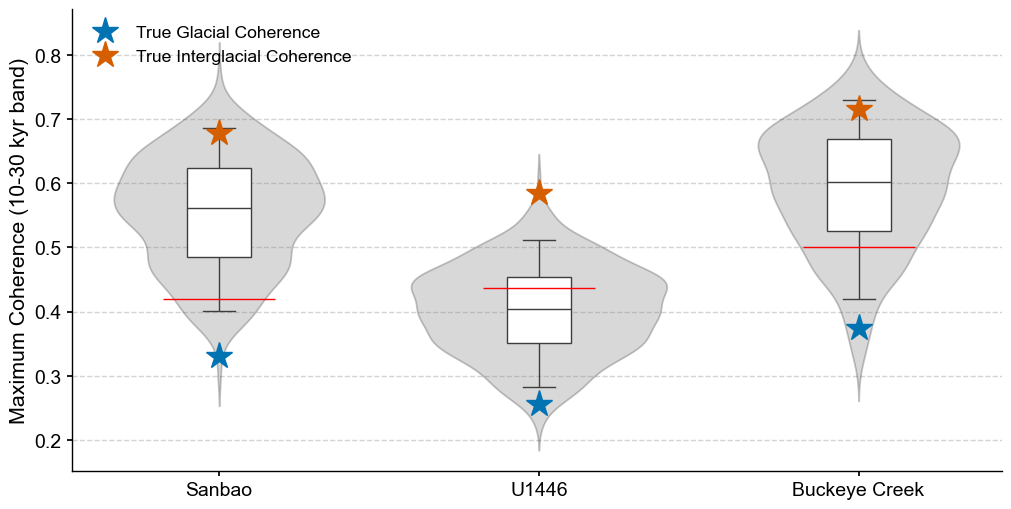

In [11]:
#Violin plots

surrogate_df = pd.DataFrame(columns = ['Sanbao','U1446','Buckeye Creek'],data = np.array(list(surrogate_coh.values())).T)
# surrogate_df = surrogate_df[['Sanbao','Buckeye Creek','U1446']]
palette = sns.color_palette("colorblind")
glacial_color = palette[0]
interglacial_color = palette[3]
surrogate_color = 'grey'

fig,ax = plt.subplots(figsize=(12,6))
sns.violinplot(surrogate_df,ax=ax,color=surrogate_color,alpha=.3,inner=None)
sns.boxplot(surrogate_df, width=0.2, color='white', saturation=1, showfliers=False,whis=[5,95])
for idx,series in tqdm(enumerate(list(ms.series_list))):
    surr_coh = surr_coh_dict[series.label]
    ax.plot(idx,np.percentile(surr_coh,95),color='red',marker='_',markersize=80)
    ax.plot(idx,gcoh_band_power(glacial_coh_dict[series.label],10,30),'bo',marker='*',markersize=20,color=glacial_color,label='True Glacial Coherence')
    ax.plot(idx,gcoh_band_power(interglacial_coh_dict[series.label],10,30),'ro',marker='*',markersize=20,color=interglacial_color, label='True Interglacial Coherence')
    # ax.plot(idx,np.percentile(surrogate_df[series.label],5),color='black',marker='_',markersize=80)
    # ax.plot(idx,np.percentile(surrogate_df[series.label],95),color='black',marker='_',markersize=80)
    if idx == 0:
        ax.legend(loc='upper left')

ax.set_ylabel('Maximum Coherence (10-30 kyr band)')
#ax.axhline(.4,color='red',linestyle='--',linewidth=.5)